# Implementing the Trained Model on a Video

In [ ]:
#GPU Check
!nvidia-smi

Wed Sep 18 19:07:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Change Directory
%cd /content/drive/MyDrive/Football_Project/Implementation

#Check Directory
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/Football_Project/Implementation


In [ ]:
#Installing Ultralytics
#Installing Supervision
#Install UMAP (Uniform Manifold Approximation and Projection) Library used for dimensionality reduction
#Installing a Python package from GitHub for using a class TeamClassifier used for classification hosted by roboflow
!pip install -q ultralytics
!pip install -q supervision>=0.23.0
!pip install umap-learn
!pip install -q git+https://github.com/roboflow/sports.git

**Source Videos**:https://drive.google.com/drive/folders/1rARvT2itkCWH2AceFytKDYXMW591nitB?usp=sharing


##Generating a Single Frame of Video

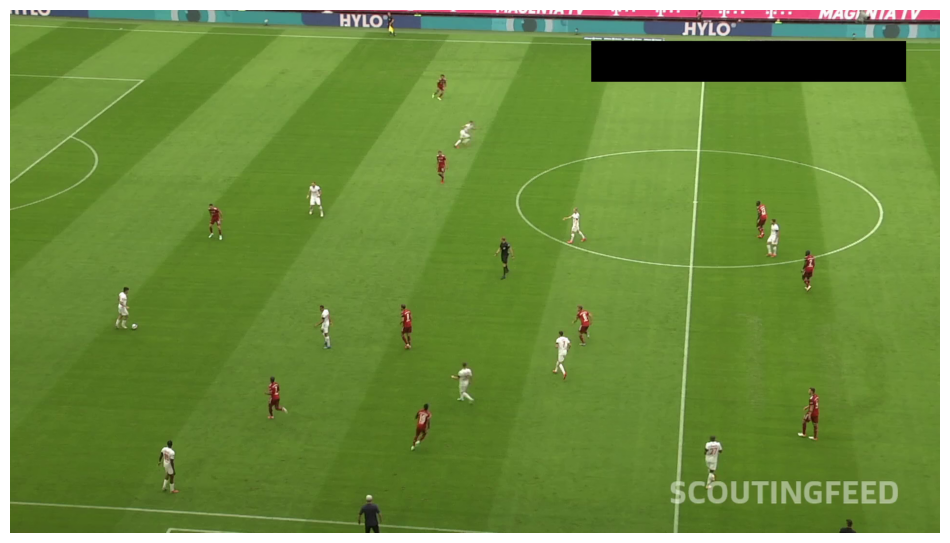

In [ ]:
#Importing Required Dependencies
import os
import supervision as sv

#Generating Frames of the Video, Just to make sure if it is working

S_Video_1 = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"

frame_generator = sv.get_video_frames_generator(S_Video_1)
frame = next(frame_generator)

sv.plot_image(frame)

##Generating Annotations to a Single Frame of Video


0: 736x1280 1 Ball, 20 Players, 2 Referees, 175.7ms
Speed: 32.5ms preprocess, 175.7ms inference, 1674.4ms postprocess per image at shape (1, 3, 736, 1280)


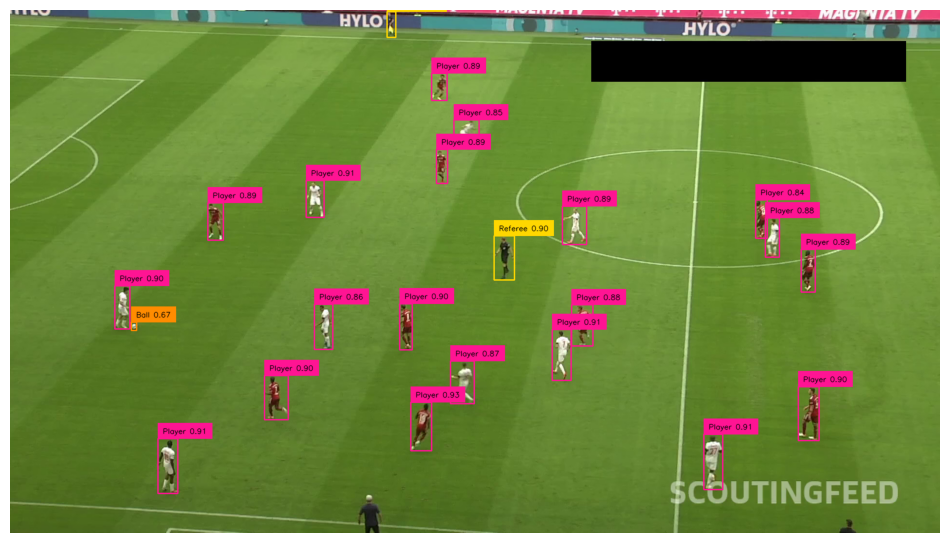

In [ ]:
#Generating annotations in the Frame of Video

#Importing Libraries required in this cell
from ultralytics import YOLO
import numpy as np

#Assigning the video path to a variable
S_Video_1 = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"

#Assigning the pretrained YOLO model to a variable
Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

#Storing the pretrained YOLO model to another variable
player_detection_model = YOLO(Pretrained_Model)

#Generating the frames of the source video
frame_generator = sv.get_video_frames_generator(S_Video_1)
frame = next(frame_generator)

#Performing inference using the pretrained model on the saved frame of the video and save the results(Only if confidance is more than 30%)
results = player_detection_model(frame, conf=0.3)

#Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

#To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

#Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
detections = sv.Detections(
    xyxy=boxes,
    confidence=confidences,
    class_id=class_ids.astype(int)
)

#Generates a label with class name and confidence score(Upto 2 decimals) by Retrieving the name of the detected class using the class ID
labels = [
    f"{player_detection_model.names[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

#Initializes an object of the BoxAnnotator from the supervision for drawing the bounding boxes with assigned color
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

#Initializes an object of the LabelAnnotator from the supervision for adding text labels with assigned color
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

#Creates a copy of the original frame, modify it by applying the bounding boxes using the detections object
#And modify the annotated frame by applying the labels beside bounding boxes using the previously generated labels
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(annotated_frame,detections)
annotated_frame = label_annotator.annotate(annotated_frame,detections,labels)

#Displaying the annotated frame
sv.plot_image(annotated_frame)


##Generating Annotations to the Complete Video

In [ ]:
#Generating annotations to the complete video


#Importing the Required Libraries
from ultralytics import YOLO
import numpy as np
import supervision as sv
from tqdm import tqdm

#Assigning the video paths to variables
S_Video = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"
S_Video_Output = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0_Results_Elps.mp4"

#Assigning the pretrained YOLO model to a variable
Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

#Storing the pretrained YOLO model to another variable
player_detection_model = YOLO(Pretrained_Model)

#Initializes an object of the BoxAnnotator from the supervision for drawing the bounding boxes with assigned color
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

#Initializes an object of the LabelAnnotator from the supervision for adding text labels with assigned color
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)


#Retrieves metadata from the video file, such as frame rate, frame size, resolution and total number of frames.
#VideoSink Initializes a video writer for saving the processed video frames.
#Generating the frames of the source video
#And Get the total number of frames using supervision's video info
video_info = sv.VideoInfo.from_video_path(S_Video)
video_sink = sv.VideoSink(S_Video_Output, video_info)
frame_generator = sv.get_video_frames_generator(S_Video)
total_frames = video_info.total_frames


#Opens the video writer context to write frames
with video_sink:

  #Iterate over each frame in the video and to show the progress bar using tqdm
  for frame in tqdm(frame_generator, total=video_info.total_frames):

      #Perform inference on the frame
      results = player_detection_model(frame, conf=0.3)

      #Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
      boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
      confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
      class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

      #To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
      boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
      confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
      class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

      #Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
      detections = sv.Detections(
          xyxy=boxes,
          confidence=confidences,
          class_id=class_ids.astype(int)
      )

      #Generates a label with class name and confidence score(Upto 2 decimals) by Retrieving the name of the detected class using the class ID
      labels = [
          f"{player_detection_model.names[class_id]} {confidence:.2f}"
          for class_id, confidence in zip(detections.class_id, detections.confidence)
      ]

      #Creates a copy of the original frame, modify it by applying the bounding boxes using the detections object
      #And modify the annotated frame by applying the labels beside bounding boxes using the previously generated labels
      annotated_frame = frame.copy()
      annotated_frame = ellipse_annotator.annotate(annotated_frame,detections)
      annotated_frame = label_annotator.annotate(annotated_frame,detections,labels=labels)

      # Write the annotated frame to the output video using videosink writer
      video_sink.write_frame(annotated_frame)


  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.0ms
Speed: 6.4ms preprocess, 126.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 1/750 [00:01<14:30,  1.16s/it]


0: 736x1280 2 Balls, 21 Players, 2 Referees, 119.7ms
Speed: 8.8ms preprocess, 119.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 2/750 [00:01<07:10,  1.74it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.3ms
Speed: 8.5ms preprocess, 120.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 3/750 [00:01<04:49,  2.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.1ms
Speed: 9.8ms preprocess, 119.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 4/750 [00:01<03:44,  3.32it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 120.4ms
Speed: 8.6ms preprocess, 120.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 5/750 [00:01<03:07,  3.96it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.4ms
Speed: 9.7ms preprocess, 119.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 6/750 [00:01<02:45,  4.48it/s]


0: 736x1280 20 Players, 2 Referees, 119.5ms
Speed: 8.3ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 7/750 [00:02<02:32,  4.86it/s]


0: 736x1280 20 Players, 2 Referees, 119.6ms
Speed: 10.1ms preprocess, 119.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 8/750 [00:02<02:23,  5.18it/s]


0: 736x1280 20 Players, 2 Referees, 121.3ms
Speed: 11.3ms preprocess, 121.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 9/750 [00:02<02:17,  5.41it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 118.8ms
Speed: 6.3ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  1%|▏         | 10/750 [00:02<02:13,  5.53it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 118.2ms
Speed: 9.5ms preprocess, 118.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  1%|▏         | 11/750 [00:02<02:11,  5.63it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 120.4ms
Speed: 8.1ms preprocess, 120.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 12/750 [00:03<02:10,  5.67it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.4ms
Speed: 9.3ms preprocess, 120.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 13/750 [00:03<02:07,  5.77it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 118.8ms
Speed: 7.5ms preprocess, 118.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 14/750 [00:03<02:05,  5.87it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 118.6ms
Speed: 9.0ms preprocess, 118.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 15/750 [00:03<02:03,  5.95it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.0ms
Speed: 9.3ms preprocess, 121.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 16/750 [00:03<02:02,  6.01it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 118.5ms
Speed: 11.1ms preprocess, 118.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 17/750 [00:03<02:01,  6.02it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.6ms
Speed: 7.3ms preprocess, 119.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 18/750 [00:03<02:01,  6.03it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.6ms
Speed: 9.9ms preprocess, 120.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 19/750 [00:04<02:00,  6.06it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.6ms
Speed: 6.7ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 20/750 [00:04<02:00,  6.05it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.1ms
Speed: 7.9ms preprocess, 120.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 21/750 [00:04<01:59,  6.09it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.2ms
Speed: 6.3ms preprocess, 120.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 22/750 [00:04<01:59,  6.09it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.0ms
Speed: 10.9ms preprocess, 119.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 23/750 [00:04<01:58,  6.12it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.2ms
Speed: 7.0ms preprocess, 119.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 24/750 [00:04<02:00,  6.00it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 118.9ms
Speed: 9.4ms preprocess, 118.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 25/750 [00:05<02:01,  5.99it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.2ms
Speed: 9.8ms preprocess, 119.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 26/750 [00:05<01:59,  6.04it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 112.4ms
Speed: 7.6ms preprocess, 112.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▎         | 27/750 [00:05<01:58,  6.11it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.5ms
Speed: 9.7ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▎         | 28/750 [00:05<01:58,  6.08it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.6ms
Speed: 7.4ms preprocess, 119.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 29/750 [00:05<01:58,  6.11it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.5ms
Speed: 6.6ms preprocess, 120.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 30/750 [00:05<01:58,  6.05it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.1ms
Speed: 14.9ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 31/750 [00:06<02:00,  5.98it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.1ms
Speed: 6.9ms preprocess, 121.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 32/750 [00:06<01:59,  5.99it/s]


0: 736x1280 20 Players, 2 Referees, 119.6ms
Speed: 10.8ms preprocess, 119.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 33/750 [00:06<01:59,  6.00it/s]


0: 736x1280 20 Players, 2 Referees, 122.0ms
Speed: 7.2ms preprocess, 122.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 34/750 [00:06<01:59,  6.00it/s]


0: 736x1280 20 Players, 2 Referees, 119.8ms
Speed: 8.1ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 35/750 [00:06<01:58,  6.05it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 120.2ms
Speed: 7.9ms preprocess, 120.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 36/750 [00:06<02:00,  5.91it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.6ms
Speed: 15.9ms preprocess, 121.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 37/750 [00:07<02:08,  5.55it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.9ms
Speed: 9.2ms preprocess, 121.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 38/750 [00:07<02:11,  5.40it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.0ms
Speed: 11.6ms preprocess, 122.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 39/750 [00:07<02:11,  5.43it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.5ms
Speed: 9.7ms preprocess, 121.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 40/750 [00:07<02:10,  5.46it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 93.9ms
Speed: 17.2ms preprocess, 93.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 41/750 [00:07<02:06,  5.60it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.4ms
Speed: 9.5ms preprocess, 121.4ms inference, 5.5ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 42/750 [00:08<02:06,  5.60it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 119.7ms
Speed: 13.5ms preprocess, 119.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 43/750 [00:08<02:06,  5.57it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.2ms
Speed: 9.5ms preprocess, 120.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 44/750 [00:08<02:05,  5.61it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 11.4ms preprocess, 121.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 45/750 [00:08<02:09,  5.46it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.5ms
Speed: 10.0ms preprocess, 121.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 46/750 [00:08<02:10,  5.38it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 120.3ms
Speed: 10.5ms preprocess, 120.3ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▋         | 47/750 [00:09<02:11,  5.34it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 119.8ms
Speed: 14.4ms preprocess, 119.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▋         | 48/750 [00:09<02:11,  5.35it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 119.9ms
Speed: 13.6ms preprocess, 119.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 49/750 [00:09<02:11,  5.35it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 119.3ms
Speed: 9.6ms preprocess, 119.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 50/750 [00:09<02:10,  5.36it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.7ms
Speed: 11.6ms preprocess, 121.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 51/750 [00:09<02:07,  5.48it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.7ms
Speed: 9.1ms preprocess, 120.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 52/750 [00:09<02:07,  5.50it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.5ms
Speed: 9.5ms preprocess, 121.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 53/750 [00:10<02:06,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.4ms
Speed: 10.6ms preprocess, 120.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 54/750 [00:10<02:04,  5.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.2ms
Speed: 11.0ms preprocess, 120.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 55/750 [00:10<02:03,  5.62it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.6ms
Speed: 8.7ms preprocess, 120.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 56/750 [00:10<02:03,  5.63it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 120.2ms
Speed: 9.2ms preprocess, 120.2ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 57/750 [00:10<02:03,  5.62it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 119.5ms
Speed: 10.1ms preprocess, 119.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 58/750 [00:10<02:01,  5.68it/s]


0: 736x1280 20 Players, 2 Referees, 120.1ms
Speed: 10.2ms preprocess, 120.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 59/750 [00:11<02:00,  5.75it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.9ms
Speed: 9.2ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 60/750 [00:11<01:57,  5.88it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 120.1ms
Speed: 9.7ms preprocess, 120.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 61/750 [00:11<01:56,  5.92it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.8ms
Speed: 7.1ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 62/750 [00:11<01:55,  5.95it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.6ms
Speed: 6.7ms preprocess, 120.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 63/750 [00:11<01:54,  6.00it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 119.5ms
Speed: 6.5ms preprocess, 119.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▊         | 64/750 [00:11<01:54,  6.01it/s]


0: 736x1280 20 Players, 2 Referees, 119.8ms
Speed: 10.5ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▊         | 65/750 [00:12<01:54,  6.01it/s]


0: 736x1280 20 Players, 2 Referees, 121.1ms
Speed: 7.4ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 66/750 [00:12<01:53,  6.03it/s]


0: 736x1280 20 Players, 2 Referees, 120.1ms
Speed: 7.3ms preprocess, 120.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 67/750 [00:12<01:53,  6.04it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.7ms
Speed: 6.7ms preprocess, 120.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 68/750 [00:12<01:52,  6.07it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.8ms
Speed: 10.2ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 69/750 [00:12<01:52,  6.04it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.1ms
Speed: 7.5ms preprocess, 122.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 70/750 [00:12<01:53,  5.98it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.4ms
Speed: 7.3ms preprocess, 121.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 71/750 [00:13<01:55,  5.88it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.9ms
Speed: 6.3ms preprocess, 120.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 72/750 [00:13<01:54,  5.93it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.1ms
Speed: 7.1ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 73/750 [00:13<01:54,  5.91it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.5ms
Speed: 7.3ms preprocess, 119.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 74/750 [00:13<01:54,  5.92it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 6.9ms preprocess, 121.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 75/750 [00:13<01:53,  5.93it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.7ms
Speed: 9.5ms preprocess, 120.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 76/750 [00:14<01:54,  5.90it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.1ms
Speed: 9.9ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 77/750 [00:14<01:53,  5.93it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.8ms
Speed: 8.4ms preprocess, 121.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 78/750 [00:14<01:53,  5.90it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.5ms
Speed: 11.0ms preprocess, 121.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 79/750 [00:14<01:54,  5.89it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.1ms
Speed: 10.6ms preprocess, 120.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 80/750 [00:14<01:53,  5.88it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.5ms
Speed: 10.0ms preprocess, 121.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 81/750 [00:14<01:53,  5.90it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.1ms
Speed: 10.2ms preprocess, 122.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 82/750 [00:15<01:55,  5.79it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.8ms
Speed: 10.0ms preprocess, 119.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 83/750 [00:15<01:53,  5.89it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.6ms
Speed: 6.7ms preprocess, 122.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 84/750 [00:15<01:54,  5.84it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 120.0ms
Speed: 11.3ms preprocess, 120.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█▏        | 85/750 [00:15<01:52,  5.89it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 120.6ms
Speed: 9.9ms preprocess, 120.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█▏        | 86/750 [00:15<01:52,  5.92it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 121.0ms
Speed: 7.4ms preprocess, 121.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 87/750 [00:15<01:52,  5.92it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.2ms
Speed: 8.6ms preprocess, 122.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 88/750 [00:16<01:52,  5.89it/s]


0: 736x1280 1 Ball, 20 Players, 4 Referees, 122.6ms
Speed: 9.5ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 89/750 [00:16<01:52,  5.86it/s]


0: 736x1280 1 Ball, 20 Players, 5 Referees, 121.4ms
Speed: 9.1ms preprocess, 121.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 90/750 [00:16<01:52,  5.89it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.4ms
Speed: 10.0ms preprocess, 122.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 91/750 [00:16<01:52,  5.87it/s]


0: 736x1280 20 Players, 5 Referees, 121.8ms
Speed: 6.9ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 92/750 [00:16<01:51,  5.88it/s]


0: 736x1280 1 Ball, 21 Players, 5 Referees, 120.5ms
Speed: 7.5ms preprocess, 120.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 93/750 [00:16<01:51,  5.92it/s]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 121.8ms
Speed: 9.9ms preprocess, 121.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 94/750 [00:17<01:50,  5.96it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 109.2ms
Speed: 9.8ms preprocess, 109.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 95/750 [00:17<01:48,  6.06it/s]


0: 736x1280 22 Players, 3 Referees, 121.3ms
Speed: 11.8ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 96/750 [00:17<01:48,  6.05it/s]


0: 736x1280 22 Players, 3 Referees, 123.3ms
Speed: 8.4ms preprocess, 123.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 97/750 [00:17<01:48,  6.01it/s]


0: 736x1280 21 Players, 3 Referees, 123.6ms
Speed: 6.9ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 98/750 [00:17<01:49,  5.96it/s]


0: 736x1280 22 Players, 2 Referees, 122.6ms
Speed: 9.4ms preprocess, 122.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 99/750 [00:17<01:49,  5.92it/s]


0: 736x1280 22 Players, 4 Referees, 121.9ms
Speed: 9.0ms preprocess, 121.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 100/750 [00:18<01:50,  5.88it/s]


0: 736x1280 21 Players, 3 Referees, 121.2ms
Speed: 6.3ms preprocess, 121.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 101/750 [00:18<01:51,  5.85it/s]


0: 736x1280 21 Players, 3 Referees, 122.8ms
Speed: 10.1ms preprocess, 122.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▎        | 102/750 [00:18<01:50,  5.88it/s]


0: 736x1280 20 Players, 3 Referees, 120.9ms
Speed: 8.8ms preprocess, 120.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▎        | 103/750 [00:18<01:49,  5.89it/s]


0: 736x1280 20 Players, 3 Referees, 121.7ms
Speed: 10.3ms preprocess, 121.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 104/750 [00:18<01:49,  5.92it/s]


0: 736x1280 22 Players, 3 Referees, 123.8ms
Speed: 10.2ms preprocess, 123.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 105/750 [00:18<01:48,  5.92it/s]


0: 736x1280 20 Players, 3 Referees, 123.9ms
Speed: 9.7ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 106/750 [00:19<01:48,  5.93it/s]


0: 736x1280 20 Players, 3 Referees, 109.5ms
Speed: 15.6ms preprocess, 109.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 107/750 [00:19<01:49,  5.85it/s]


0: 736x1280 21 Players, 3 Referees, 121.6ms
Speed: 10.0ms preprocess, 121.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 108/750 [00:19<01:48,  5.91it/s]


0: 736x1280 21 Players, 2 Referees, 123.4ms
Speed: 8.0ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 109/750 [00:19<01:48,  5.89it/s]


0: 736x1280 21 Players, 2 Referees, 123.4ms
Speed: 8.8ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 110/750 [00:19<01:48,  5.89it/s]


0: 736x1280 21 Players, 3 Referees, 122.2ms
Speed: 10.8ms preprocess, 122.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 111/750 [00:19<01:49,  5.86it/s]


0: 736x1280 21 Players, 3 Referees, 122.6ms
Speed: 11.4ms preprocess, 122.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 112/750 [00:20<01:49,  5.81it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 122.8ms
Speed: 8.1ms preprocess, 122.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 113/750 [00:20<01:51,  5.71it/s]


0: 736x1280 22 Players, 4 Referees, 123.1ms
Speed: 10.6ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 114/750 [00:20<01:50,  5.76it/s]


0: 736x1280 22 Players, 3 Referees, 122.7ms
Speed: 7.0ms preprocess, 122.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 115/750 [00:20<01:49,  5.78it/s]


0: 736x1280 21 Players, 3 Referees, 122.6ms
Speed: 7.1ms preprocess, 122.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 116/750 [00:20<01:49,  5.80it/s]


0: 736x1280 20 Players, 3 Referees, 123.7ms
Speed: 7.3ms preprocess, 123.7ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 117/750 [00:20<01:51,  5.70it/s]


0: 736x1280 21 Players, 3 Referees, 122.4ms
Speed: 19.6ms preprocess, 122.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 118/750 [00:21<01:52,  5.61it/s]


0: 736x1280 21 Players, 3 Referees, 124.5ms
Speed: 10.0ms preprocess, 124.5ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 119/750 [00:21<01:55,  5.46it/s]


0: 736x1280 21 Players, 3 Referees, 124.6ms
Speed: 10.2ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 120/750 [00:21<01:58,  5.30it/s]


0: 736x1280 21 Players, 3 Referees, 123.9ms
Speed: 10.0ms preprocess, 123.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 121/750 [00:21<01:58,  5.30it/s]


0: 736x1280 21 Players, 3 Referees, 122.2ms
Speed: 12.9ms preprocess, 122.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▋        | 122/750 [00:21<01:58,  5.31it/s]


0: 736x1280 21 Players, 3 Referees, 120.9ms
Speed: 19.0ms preprocess, 120.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▋        | 123/750 [00:22<01:58,  5.31it/s]


0: 736x1280 23 Players, 3 Referees, 124.7ms
Speed: 11.3ms preprocess, 124.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 124/750 [00:22<01:57,  5.34it/s]


0: 736x1280 23 Players, 3 Referees, 125.1ms
Speed: 10.1ms preprocess, 125.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 125/750 [00:22<01:54,  5.44it/s]


0: 736x1280 21 Players, 3 Referees, 123.0ms
Speed: 9.2ms preprocess, 123.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 126/750 [00:22<01:55,  5.42it/s]


0: 736x1280 23 Players, 3 Referees, 137.8ms
Speed: 9.7ms preprocess, 137.8ms inference, 10.2ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 127/750 [00:22<02:02,  5.09it/s]


0: 736x1280 22 Players, 3 Referees, 122.5ms
Speed: 16.9ms preprocess, 122.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 128/750 [00:23<02:04,  5.00it/s]


0: 736x1280 21 Players, 3 Referees, 124.5ms
Speed: 16.1ms preprocess, 124.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 129/750 [00:23<02:01,  5.10it/s]


0: 736x1280 21 Players, 3 Referees, 123.6ms
Speed: 11.6ms preprocess, 123.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 130/750 [00:23<01:59,  5.18it/s]


0: 736x1280 21 Players, 3 Referees, 123.7ms
Speed: 26.1ms preprocess, 123.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 131/750 [00:23<02:02,  5.05it/s]


0: 736x1280 21 Players, 3 Referees, 122.2ms
Speed: 11.8ms preprocess, 122.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 132/750 [00:23<02:00,  5.14it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.9ms
Speed: 10.6ms preprocess, 122.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 133/750 [00:24<01:58,  5.19it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.6ms
Speed: 10.0ms preprocess, 122.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 134/750 [00:24<01:57,  5.25it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 123.5ms
Speed: 9.4ms preprocess, 123.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 135/750 [00:24<01:54,  5.38it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 124.4ms
Speed: 11.5ms preprocess, 124.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 136/750 [00:24<01:55,  5.33it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.5ms
Speed: 9.4ms preprocess, 123.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 137/750 [00:24<01:52,  5.44it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.8ms
Speed: 9.4ms preprocess, 123.8ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 138/750 [00:24<01:54,  5.37it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.0ms
Speed: 24.6ms preprocess, 122.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▊        | 139/750 [00:25<01:52,  5.41it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.7ms
Speed: 9.4ms preprocess, 126.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▊        | 140/750 [00:25<01:50,  5.54it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.7ms
Speed: 12.5ms preprocess, 123.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 141/750 [00:25<01:49,  5.55it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 124.2ms
Speed: 7.3ms preprocess, 124.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 142/750 [00:25<01:49,  5.53it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 125.0ms
Speed: 7.8ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 143/750 [00:25<01:48,  5.62it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.4ms
Speed: 9.1ms preprocess, 123.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 144/750 [00:26<01:45,  5.72it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.4ms
Speed: 14.1ms preprocess, 124.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 145/750 [00:26<01:46,  5.69it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.7ms
Speed: 6.8ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 146/750 [00:26<01:45,  5.73it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 125.8ms
Speed: 9.5ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 147/750 [00:26<01:47,  5.62it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.4ms
Speed: 10.1ms preprocess, 124.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 148/750 [00:26<01:45,  5.70it/s]


0: 736x1280 22 Players, 4 Referees, 123.5ms
Speed: 8.7ms preprocess, 123.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 149/750 [00:26<01:44,  5.77it/s]


0: 736x1280 22 Players, 4 Referees, 123.6ms
Speed: 9.4ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 150/750 [00:27<01:43,  5.77it/s]


0: 736x1280 22 Players, 4 Referees, 124.3ms
Speed: 9.1ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 151/750 [00:27<01:42,  5.82it/s]


0: 736x1280 23 Players, 3 Referees, 123.8ms
Speed: 6.1ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 152/750 [00:27<01:42,  5.82it/s]


0: 736x1280 22 Players, 3 Referees, 124.7ms
Speed: 8.6ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 153/750 [00:27<01:42,  5.84it/s]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 123.1ms
Speed: 9.5ms preprocess, 123.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 154/750 [00:27<01:44,  5.73it/s]


0: 736x1280 22 Players, 3 Referees, 123.8ms
Speed: 11.3ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 155/750 [00:27<01:43,  5.74it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.2ms
Speed: 10.2ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 156/750 [00:28<01:42,  5.77it/s]


0: 736x1280 1 Ball, 26 Players, 2 Referees, 123.8ms
Speed: 10.6ms preprocess, 123.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 157/750 [00:28<01:42,  5.76it/s]


0: 736x1280 24 Players, 2 Referees, 124.6ms
Speed: 7.6ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 158/750 [00:28<01:42,  5.76it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.6ms
Speed: 11.0ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 159/750 [00:28<01:42,  5.74it/s]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 122.4ms
Speed: 14.8ms preprocess, 122.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██▏       | 160/750 [00:28<01:42,  5.76it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 125.0ms
Speed: 9.5ms preprocess, 125.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██▏       | 161/750 [00:29<01:43,  5.68it/s]


0: 736x1280 22 Players, 4 Referees, 125.2ms
Speed: 10.2ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 162/750 [00:29<01:42,  5.71it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.1ms
Speed: 8.9ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 163/750 [00:29<01:42,  5.74it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 124.2ms
Speed: 11.4ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 164/750 [00:29<01:41,  5.76it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.7ms
Speed: 9.2ms preprocess, 124.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 165/750 [00:29<01:41,  5.74it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.5ms
Speed: 8.7ms preprocess, 124.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 166/750 [00:29<01:42,  5.68it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.1ms
Speed: 8.4ms preprocess, 123.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 167/750 [00:30<01:41,  5.73it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 123.5ms
Speed: 9.6ms preprocess, 123.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 168/750 [00:30<01:40,  5.79it/s]


0: 736x1280 22 Players, 4 Referees, 125.5ms
Speed: 9.1ms preprocess, 125.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 169/750 [00:30<01:39,  5.81it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.2ms
Speed: 9.2ms preprocess, 124.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 170/750 [00:30<01:39,  5.85it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.7ms
Speed: 10.4ms preprocess, 123.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 171/750 [00:30<01:40,  5.77it/s]


0: 736x1280 21 Players, 3 Referees, 123.4ms
Speed: 8.5ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 172/750 [00:30<01:40,  5.77it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.5ms
Speed: 8.7ms preprocess, 124.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 173/750 [00:31<01:39,  5.79it/s]


0: 736x1280 24 Players, 3 Referees, 125.1ms
Speed: 9.1ms preprocess, 125.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 174/750 [00:31<01:38,  5.82it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 124.4ms
Speed: 6.9ms preprocess, 124.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 175/750 [00:31<01:38,  5.82it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.0ms
Speed: 5.9ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 176/750 [00:31<01:38,  5.81it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 125.9ms
Speed: 9.6ms preprocess, 125.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▎       | 177/750 [00:31<01:40,  5.70it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.5ms
Speed: 9.1ms preprocess, 123.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▎       | 178/750 [00:31<01:40,  5.67it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 125.3ms
Speed: 9.8ms preprocess, 125.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 179/750 [00:32<01:39,  5.73it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.6ms
Speed: 9.4ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 180/750 [00:32<01:39,  5.75it/s]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 125.0ms
Speed: 9.5ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 181/750 [00:32<01:38,  5.79it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 95.1ms
Speed: 9.7ms preprocess, 95.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 182/750 [00:32<01:34,  6.04it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 125.7ms
Speed: 9.8ms preprocess, 125.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 183/750 [00:32<01:34,  5.98it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 125.7ms
Speed: 14.3ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 184/750 [00:32<01:37,  5.80it/s]


0: 736x1280 21 Players, 4 Referees, 125.0ms
Speed: 10.7ms preprocess, 125.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 185/750 [00:33<01:37,  5.77it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 126.7ms
Speed: 7.7ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 186/750 [00:33<01:38,  5.70it/s]


0: 736x1280 22 Players, 4 Referees, 125.0ms
Speed: 6.5ms preprocess, 125.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 187/750 [00:33<01:39,  5.68it/s]


0: 736x1280 22 Players, 3 Referees, 125.3ms
Speed: 7.7ms preprocess, 125.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 188/750 [00:33<01:38,  5.70it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.4ms
Speed: 9.8ms preprocess, 125.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 189/750 [00:33<01:39,  5.63it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.4ms
Speed: 7.7ms preprocess, 124.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 190/750 [00:34<01:40,  5.59it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.8ms
Speed: 14.3ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 191/750 [00:34<01:39,  5.60it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.2ms
Speed: 9.4ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 192/750 [00:34<01:38,  5.66it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.2ms
Speed: 10.1ms preprocess, 126.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 193/750 [00:34<01:45,  5.28it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.8ms
Speed: 30.3ms preprocess, 123.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 194/750 [00:34<01:48,  5.12it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.5ms
Speed: 14.4ms preprocess, 124.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 195/750 [00:35<01:49,  5.06it/s]


0: 736x1280 1 Ball, 22 Players, 5 Referees, 124.9ms
Speed: 9.5ms preprocess, 124.9ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 196/750 [00:35<01:46,  5.20it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 126.4ms
Speed: 9.1ms preprocess, 126.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▋       | 197/750 [00:35<01:44,  5.30it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 125.5ms
Speed: 23.5ms preprocess, 125.5ms inference, 13.1ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▋       | 198/750 [00:35<02:10,  4.23it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.2ms
Speed: 37.5ms preprocess, 126.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 199/750 [00:35<02:13,  4.12it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.5ms
Speed: 12.2ms preprocess, 125.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 200/750 [00:36<02:05,  4.40it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.8ms
Speed: 16.0ms preprocess, 126.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 201/750 [00:36<02:00,  4.56it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 126.0ms
Speed: 9.9ms preprocess, 126.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 202/750 [00:36<01:57,  4.68it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 127.8ms
Speed: 13.2ms preprocess, 127.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 203/750 [00:36<01:52,  4.88it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 125.0ms
Speed: 9.8ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 204/750 [00:36<01:48,  5.01it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.9ms
Speed: 10.8ms preprocess, 126.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 205/750 [00:37<01:45,  5.17it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 94.6ms
Speed: 10.0ms preprocess, 94.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 206/750 [00:37<01:41,  5.34it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.0ms
Speed: 10.6ms preprocess, 127.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 207/750 [00:37<01:42,  5.31it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.7ms
Speed: 10.7ms preprocess, 126.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 208/750 [00:37<01:42,  5.31it/s]


0: 736x1280 22 Players, 2 Referees, 125.5ms
Speed: 12.2ms preprocess, 125.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 209/750 [00:37<01:41,  5.33it/s]


0: 736x1280 22 Players, 2 Referees, 124.3ms
Speed: 9.5ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 210/750 [00:38<01:42,  5.29it/s]


0: 736x1280 22 Players, 2 Referees, 123.9ms
Speed: 9.4ms preprocess, 123.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 211/750 [00:38<01:41,  5.29it/s]


0: 736x1280 22 Players, 2 Referees, 124.4ms
Speed: 13.1ms preprocess, 124.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 212/750 [00:38<01:41,  5.32it/s]


0: 736x1280 21 Players, 2 Referees, 124.7ms
Speed: 16.5ms preprocess, 124.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 213/750 [00:38<01:41,  5.29it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 124.7ms
Speed: 9.8ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▊       | 214/750 [00:38<01:40,  5.31it/s]


0: 736x1280 2 Balls, 22 Players, 2 Referees, 126.7ms
Speed: 9.0ms preprocess, 126.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▊       | 215/750 [00:39<01:41,  5.28it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.0ms
Speed: 11.7ms preprocess, 129.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 216/750 [00:39<01:42,  5.21it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 14.0ms preprocess, 125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 217/750 [00:39<01:41,  5.27it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.0ms
Speed: 9.2ms preprocess, 126.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 218/750 [00:39<01:38,  5.39it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.2ms
Speed: 7.5ms preprocess, 127.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 219/750 [00:39<01:37,  5.47it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.1ms
Speed: 11.7ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 220/750 [00:39<01:35,  5.55it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.0ms
Speed: 10.4ms preprocess, 124.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 221/750 [00:40<01:34,  5.62it/s]


0: 736x1280 21 Players, 2 Referees, 126.2ms
Speed: 9.5ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 222/750 [00:40<01:32,  5.68it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 8.5ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 223/750 [00:40<01:32,  5.69it/s]


0: 736x1280 21 Players, 2 Referees, 126.3ms
Speed: 8.8ms preprocess, 126.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 224/750 [00:40<01:32,  5.71it/s]


0: 736x1280 22 Players, 1 Referee, 125.6ms
Speed: 10.2ms preprocess, 125.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 225/750 [00:40<01:31,  5.75it/s]


0: 736x1280 22 Players, 2 Referees, 125.4ms
Speed: 9.2ms preprocess, 125.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 226/750 [00:40<01:30,  5.79it/s]


0: 736x1280 22 Players, 2 Referees, 126.2ms
Speed: 14.3ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 227/750 [00:41<01:31,  5.75it/s]


0: 736x1280 22 Players, 2 Referees, 126.2ms
Speed: 11.1ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 228/750 [00:41<01:30,  5.74it/s]


0: 736x1280 21 Players, 2 Referees, 125.3ms
Speed: 9.8ms preprocess, 125.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 229/750 [00:41<01:31,  5.70it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 11.7ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 230/750 [00:41<01:31,  5.70it/s]


0: 736x1280 21 Players, 2 Referees, 126.7ms
Speed: 9.9ms preprocess, 126.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 231/750 [00:41<01:30,  5.75it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 8.7ms preprocess, 125.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 232/750 [00:42<01:30,  5.73it/s]


0: 736x1280 21 Players, 3 Referees, 125.6ms
Speed: 9.4ms preprocess, 125.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 233/750 [00:42<01:30,  5.69it/s]


0: 736x1280 21 Players, 3 Referees, 126.1ms
Speed: 9.6ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 234/750 [00:42<01:30,  5.71it/s]


0: 736x1280 22 Players, 3 Referees, 125.3ms
Speed: 11.3ms preprocess, 125.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███▏      | 235/750 [00:42<01:30,  5.68it/s]


0: 736x1280 23 Players, 3 Referees, 124.6ms
Speed: 7.9ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███▏      | 236/750 [00:42<01:30,  5.71it/s]


0: 736x1280 22 Players, 2 Referees, 126.8ms
Speed: 9.0ms preprocess, 126.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 237/750 [00:42<01:29,  5.71it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 8.5ms preprocess, 125.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 238/750 [00:43<01:30,  5.67it/s]


0: 736x1280 21 Players, 2 Referees, 126.3ms
Speed: 9.3ms preprocess, 126.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 239/750 [00:43<01:31,  5.61it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 9.3ms preprocess, 126.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 240/750 [00:43<01:31,  5.58it/s]


0: 736x1280 22 Players, 2 Referees, 125.5ms
Speed: 8.3ms preprocess, 125.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 241/750 [00:43<01:31,  5.58it/s]


0: 736x1280 23 Players, 2 Referees, 125.0ms
Speed: 10.4ms preprocess, 125.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 242/750 [00:43<01:30,  5.62it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 10.1ms preprocess, 125.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 243/750 [00:43<01:30,  5.62it/s]


0: 736x1280 21 Players, 2 Referees, 127.6ms
Speed: 10.0ms preprocess, 127.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 244/750 [00:44<01:30,  5.58it/s]


0: 736x1280 23 Players, 2 Referees, 127.1ms
Speed: 11.1ms preprocess, 127.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 245/750 [00:44<01:30,  5.57it/s]


0: 736x1280 21 Players, 2 Referees, 127.5ms
Speed: 8.2ms preprocess, 127.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 246/750 [00:44<01:30,  5.58it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 124.8ms
Speed: 9.4ms preprocess, 124.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 247/750 [00:44<01:28,  5.67it/s]


0: 736x1280 22 Players, 3 Referees, 126.8ms
Speed: 8.9ms preprocess, 126.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 248/750 [00:44<01:29,  5.58it/s]


0: 736x1280 22 Players, 2 Referees, 125.0ms
Speed: 10.7ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 249/750 [00:45<01:31,  5.50it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.4ms
Speed: 10.1ms preprocess, 125.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 250/750 [00:45<01:29,  5.59it/s]


0: 736x1280 21 Players, 2 Referees, 126.1ms
Speed: 7.9ms preprocess, 126.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 251/750 [00:45<01:29,  5.59it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 126.4ms
Speed: 9.3ms preprocess, 126.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▎      | 252/750 [00:45<01:28,  5.66it/s]


0: 736x1280 20 Players, 3 Referees, 127.1ms
Speed: 13.1ms preprocess, 127.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▎      | 253/750 [00:45<01:27,  5.68it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 127.2ms
Speed: 9.7ms preprocess, 127.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 254/750 [00:45<01:27,  5.68it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 126.6ms
Speed: 9.1ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 255/750 [00:46<01:27,  5.69it/s]


0: 736x1280 20 Players, 3 Referees, 127.2ms
Speed: 9.7ms preprocess, 127.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 256/750 [00:46<01:26,  5.69it/s]


0: 736x1280 1 Ball, 19 Players, 3 Referees, 127.6ms
Speed: 10.2ms preprocess, 127.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 257/750 [00:46<01:27,  5.64it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 128.3ms
Speed: 10.0ms preprocess, 128.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 258/750 [00:46<01:27,  5.64it/s]


0: 736x1280 20 Players, 3 Referees, 128.2ms
Speed: 9.5ms preprocess, 128.2ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 259/750 [00:46<01:27,  5.61it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.1ms
Speed: 11.5ms preprocess, 127.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 260/750 [00:46<01:27,  5.60it/s]


0: 736x1280 20 Players, 2 Referees, 126.3ms
Speed: 14.2ms preprocess, 126.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 261/750 [00:47<01:27,  5.59it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 9.2ms preprocess, 126.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 262/750 [00:47<01:26,  5.62it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.4ms
Speed: 8.3ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 263/750 [00:47<01:27,  5.59it/s]


0: 736x1280 20 Players, 2 Referees, 128.2ms
Speed: 9.9ms preprocess, 128.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 264/750 [00:47<01:26,  5.63it/s]


0: 736x1280 20 Players, 2 Referees, 128.3ms
Speed: 13.0ms preprocess, 128.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 265/750 [00:47<01:26,  5.60it/s]


0: 736x1280 20 Players, 2 Referees, 126.4ms
Speed: 9.7ms preprocess, 126.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 266/750 [00:48<01:26,  5.63it/s]


0: 736x1280 20 Players, 2 Referees, 128.1ms
Speed: 8.4ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 267/750 [00:48<01:25,  5.64it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.2ms
Speed: 9.7ms preprocess, 125.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 268/750 [00:48<01:25,  5.66it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.6ms
Speed: 10.0ms preprocess, 128.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 269/750 [00:48<01:24,  5.69it/s]


0: 736x1280 20 Players, 2 Referees, 126.4ms
Speed: 10.0ms preprocess, 126.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 270/750 [00:48<01:24,  5.70it/s]


0: 736x1280 21 Players, 2 Referees, 128.5ms
Speed: 9.1ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 271/750 [00:48<01:24,  5.68it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.2ms
Speed: 9.0ms preprocess, 127.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▋      | 272/750 [00:49<01:24,  5.67it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.2ms
Speed: 9.2ms preprocess, 127.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▋      | 273/750 [00:49<01:24,  5.64it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.9ms
Speed: 13.7ms preprocess, 127.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 274/750 [00:49<01:26,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.0ms
Speed: 12.6ms preprocess, 128.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 275/750 [00:49<01:27,  5.43it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.6ms
Speed: 18.7ms preprocess, 128.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 276/750 [00:49<01:30,  5.23it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 104.1ms
Speed: 11.0ms preprocess, 104.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 277/750 [00:50<01:27,  5.40it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.2ms
Speed: 16.0ms preprocess, 128.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 278/750 [00:50<01:31,  5.17it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.3ms
Speed: 14.6ms preprocess, 126.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 279/750 [00:50<01:29,  5.24it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.1ms
Speed: 16.2ms preprocess, 128.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 280/750 [00:50<01:30,  5.22it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.0ms
Speed: 11.6ms preprocess, 129.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 281/750 [00:50<01:30,  5.19it/s]


0: 736x1280 1 Ball, 18 Players, 2 Referees, 128.8ms
Speed: 10.5ms preprocess, 128.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 282/750 [00:51<01:30,  5.17it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 126.4ms
Speed: 13.5ms preprocess, 126.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 283/750 [00:51<01:30,  5.17it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 127.8ms
Speed: 9.4ms preprocess, 127.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 284/750 [00:51<01:27,  5.31it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 130.0ms
Speed: 10.2ms preprocess, 130.0ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 285/750 [00:51<01:29,  5.21it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 128.8ms
Speed: 9.4ms preprocess, 128.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 286/750 [00:51<01:27,  5.32it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 125.6ms
Speed: 9.8ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 287/750 [00:51<01:28,  5.25it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.2ms
Speed: 11.8ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 288/750 [00:52<01:28,  5.25it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.4ms
Speed: 9.5ms preprocess, 128.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▊      | 289/750 [00:52<01:28,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 128.1ms
Speed: 9.4ms preprocess, 128.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▊      | 290/750 [00:52<01:26,  5.34it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.3ms
Speed: 11.9ms preprocess, 129.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 291/750 [00:52<01:26,  5.31it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.1ms
Speed: 13.2ms preprocess, 128.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 292/750 [00:52<01:28,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 128.7ms
Speed: 10.7ms preprocess, 128.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 293/750 [00:53<01:27,  5.25it/s]


0: 736x1280 19 Players, 2 Referees, 127.8ms
Speed: 10.2ms preprocess, 127.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 294/750 [00:53<01:27,  5.22it/s]


0: 736x1280 20 Players, 3 Referees, 128.4ms
Speed: 10.7ms preprocess, 128.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 295/750 [00:53<01:28,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 108.2ms
Speed: 10.7ms preprocess, 108.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 296/750 [00:53<01:25,  5.29it/s]


0: 736x1280 20 Players, 3 Referees, 127.1ms
Speed: 9.3ms preprocess, 127.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 297/750 [00:53<01:24,  5.39it/s]


0: 736x1280 21 Players, 2 Referees, 127.7ms
Speed: 10.3ms preprocess, 127.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 298/750 [00:54<01:23,  5.40it/s]


0: 736x1280 20 Players, 2 Referees, 127.3ms
Speed: 8.0ms preprocess, 127.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 299/750 [00:54<01:22,  5.44it/s]


0: 736x1280 20 Players, 2 Referees, 128.0ms
Speed: 8.9ms preprocess, 128.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 300/750 [00:54<01:21,  5.51it/s]


0: 736x1280 20 Players, 2 Referees, 127.9ms
Speed: 9.9ms preprocess, 127.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 301/750 [00:54<01:20,  5.60it/s]


0: 736x1280 20 Players, 2 Referees, 126.8ms
Speed: 9.8ms preprocess, 126.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 302/750 [00:54<01:19,  5.62it/s]


0: 736x1280 20 Players, 2 Referees, 129.4ms
Speed: 9.5ms preprocess, 129.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 303/750 [00:54<01:19,  5.64it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 128.0ms
Speed: 11.4ms preprocess, 128.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 304/750 [00:55<01:19,  5.63it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.9ms
Speed: 8.5ms preprocess, 126.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 305/750 [00:55<01:18,  5.64it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 14.9ms preprocess, 126.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 306/750 [00:55<01:18,  5.67it/s]


0: 736x1280 21 Players, 2 Referees, 129.0ms
Speed: 8.4ms preprocess, 129.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 307/750 [00:55<01:18,  5.63it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.7ms
Speed: 9.9ms preprocess, 127.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 308/750 [00:55<01:18,  5.64it/s]


0: 736x1280 21 Players, 2 Referees, 127.9ms
Speed: 8.4ms preprocess, 127.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 309/750 [00:55<01:18,  5.59it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.8ms
Speed: 11.7ms preprocess, 127.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████▏     | 310/750 [00:56<01:18,  5.59it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 126.3ms
Speed: 8.3ms preprocess, 126.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████▏     | 311/750 [00:56<01:18,  5.59it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 128.5ms
Speed: 9.7ms preprocess, 128.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 312/750 [00:56<01:17,  5.67it/s]


0: 736x1280 21 Players, 2 Referees, 127.5ms
Speed: 11.0ms preprocess, 127.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 313/750 [00:56<01:16,  5.70it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.4ms
Speed: 8.9ms preprocess, 126.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 314/750 [00:56<01:17,  5.65it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 127.1ms
Speed: 9.1ms preprocess, 127.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 315/750 [00:57<01:16,  5.65it/s]


0: 736x1280 21 Players, 2 Referees, 127.8ms
Speed: 10.4ms preprocess, 127.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 316/750 [00:57<01:16,  5.70it/s]


0: 736x1280 20 Players, 2 Referees, 129.1ms
Speed: 8.3ms preprocess, 129.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 317/750 [00:57<01:16,  5.65it/s]


0: 736x1280 22 Players, 2 Referees, 126.1ms
Speed: 9.3ms preprocess, 126.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 318/750 [00:57<01:16,  5.68it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.1ms
Speed: 13.5ms preprocess, 128.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 319/750 [00:57<01:16,  5.66it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.2ms
Speed: 8.7ms preprocess, 128.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 320/750 [00:57<01:18,  5.50it/s]


0: 736x1280 20 Players, 2 Referees, 127.8ms
Speed: 11.9ms preprocess, 127.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 321/750 [00:58<01:17,  5.51it/s]


0: 736x1280 19 Players, 3 Referees, 127.6ms
Speed: 8.9ms preprocess, 127.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 322/750 [00:58<01:17,  5.53it/s]


0: 736x1280 19 Players, 3 Referees, 129.5ms
Speed: 9.4ms preprocess, 129.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 323/750 [00:58<01:16,  5.55it/s]


0: 736x1280 19 Players, 2 Referees, 128.5ms
Speed: 8.9ms preprocess, 128.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 324/750 [00:58<01:16,  5.59it/s]


0: 736x1280 19 Players, 2 Referees, 128.9ms
Speed: 8.8ms preprocess, 128.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 325/750 [00:58<01:15,  5.60it/s]


0: 736x1280 21 Players, 2 Referees, 128.3ms
Speed: 10.5ms preprocess, 128.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 326/750 [00:59<01:15,  5.58it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.4ms
Speed: 14.3ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▎     | 327/750 [00:59<01:15,  5.57it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.0ms
Speed: 8.7ms preprocess, 127.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▎     | 328/750 [00:59<01:15,  5.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.6ms
Speed: 10.1ms preprocess, 127.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 329/750 [00:59<01:15,  5.55it/s]


0: 736x1280 21 Players, 2 Referees, 128.5ms
Speed: 10.9ms preprocess, 128.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 330/750 [00:59<01:15,  5.56it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 130.5ms
Speed: 15.2ms preprocess, 130.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 331/750 [00:59<01:15,  5.55it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.7ms
Speed: 9.4ms preprocess, 128.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 332/750 [01:00<01:14,  5.63it/s]


0: 736x1280 24 Players, 2 Referees, 127.7ms
Speed: 11.3ms preprocess, 127.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 333/750 [01:00<01:13,  5.67it/s]


0: 736x1280 22 Players, 2 Referees, 126.9ms
Speed: 12.6ms preprocess, 126.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 334/750 [01:00<01:13,  5.68it/s]


0: 736x1280 20 Players, 2 Referees, 129.8ms
Speed: 9.3ms preprocess, 129.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 335/750 [01:00<01:14,  5.59it/s]


0: 736x1280 20 Players, 2 Referees, 128.6ms
Speed: 8.4ms preprocess, 128.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 336/750 [01:00<01:14,  5.59it/s]


0: 736x1280 20 Players, 2 Referees, 128.9ms
Speed: 9.6ms preprocess, 128.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 337/750 [01:01<01:14,  5.52it/s]


0: 736x1280 24 Players, 2 Referees, 129.8ms
Speed: 9.5ms preprocess, 129.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 338/750 [01:01<01:14,  5.50it/s]


0: 736x1280 20 Players, 2 Referees, 129.6ms
Speed: 11.9ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 339/750 [01:01<01:15,  5.46it/s]


0: 736x1280 22 Players, 2 Referees, 130.2ms
Speed: 10.0ms preprocess, 130.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 340/750 [01:01<01:14,  5.51it/s]


0: 736x1280 22 Players, 2 Referees, 127.3ms
Speed: 9.4ms preprocess, 127.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 341/750 [01:01<01:13,  5.56it/s]


0: 736x1280 2 Balls, 20 Players, 2 Referees, 130.1ms
Speed: 10.3ms preprocess, 130.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 342/750 [01:01<01:13,  5.54it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 130.1ms
Speed: 10.5ms preprocess, 130.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 343/750 [01:02<01:14,  5.48it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.3ms
Speed: 10.4ms preprocess, 128.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 344/750 [01:02<01:13,  5.53it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.6ms
Speed: 12.3ms preprocess, 129.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 345/750 [01:02<01:13,  5.50it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.4ms
Speed: 11.0ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 346/750 [01:02<01:12,  5.57it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.1ms
Speed: 11.3ms preprocess, 128.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▋     | 347/750 [01:02<01:12,  5.59it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 131.3ms
Speed: 10.7ms preprocess, 131.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▋     | 348/750 [01:02<01:12,  5.52it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.7ms
Speed: 14.0ms preprocess, 127.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 349/750 [01:03<01:12,  5.54it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 130.8ms
Speed: 9.2ms preprocess, 130.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 350/750 [01:03<01:12,  5.51it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.4ms
Speed: 9.3ms preprocess, 127.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 351/750 [01:03<01:12,  5.49it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 130.0ms
Speed: 9.2ms preprocess, 130.0ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 352/750 [01:03<01:13,  5.45it/s]


0: 736x1280 21 Players, 3 Referees, 130.1ms
Speed: 9.3ms preprocess, 130.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 353/750 [01:03<01:14,  5.32it/s]


0: 736x1280 20 Players, 2 Referees, 129.7ms
Speed: 9.2ms preprocess, 129.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 354/750 [01:04<01:14,  5.32it/s]


0: 736x1280 19 Players, 2 Referees, 129.3ms
Speed: 9.3ms preprocess, 129.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 355/750 [01:04<01:14,  5.30it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.6ms
Speed: 10.0ms preprocess, 128.6ms inference, 8.0ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 356/750 [01:04<01:16,  5.12it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 128.6ms
Speed: 10.2ms preprocess, 128.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 357/750 [01:04<01:16,  5.16it/s]


0: 736x1280 20 Players, 2 Referees, 129.7ms
Speed: 11.6ms preprocess, 129.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 358/750 [01:04<01:16,  5.13it/s]


0: 736x1280 20 Players, 1 Referee, 130.7ms
Speed: 12.6ms preprocess, 130.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 359/750 [01:05<01:17,  5.06it/s]


0: 736x1280 20 Players, 2 Referees, 130.9ms
Speed: 10.0ms preprocess, 130.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 360/750 [01:05<01:15,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 132.7ms
Speed: 10.5ms preprocess, 132.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 361/750 [01:05<01:15,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 131.4ms
Speed: 9.3ms preprocess, 131.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 362/750 [01:05<01:14,  5.23it/s]


0: 736x1280 20 Players, 2 Referees, 130.0ms
Speed: 9.9ms preprocess, 130.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 363/750 [01:05<01:13,  5.29it/s]


0: 736x1280 20 Players, 2 Referees, 128.3ms
Speed: 10.9ms preprocess, 128.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▊     | 364/750 [01:06<01:12,  5.29it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.6ms
Speed: 19.9ms preprocess, 129.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▊     | 365/750 [01:06<01:13,  5.23it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 129.9ms
Speed: 10.1ms preprocess, 129.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 366/750 [01:06<01:13,  5.26it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 130.6ms
Speed: 9.8ms preprocess, 130.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 367/750 [01:06<01:13,  5.22it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 129.1ms
Speed: 12.9ms preprocess, 129.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 368/750 [01:06<01:12,  5.24it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 129.7ms
Speed: 10.9ms preprocess, 129.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 369/750 [01:07<01:14,  5.13it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.9ms
Speed: 10.3ms preprocess, 129.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 370/750 [01:07<01:15,  5.04it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 131.8ms
Speed: 9.9ms preprocess, 131.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 371/750 [01:07<01:15,  5.03it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 131.3ms
Speed: 8.8ms preprocess, 131.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 372/750 [01:07<01:14,  5.10it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 132.3ms
Speed: 9.3ms preprocess, 132.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 373/750 [01:07<01:13,  5.14it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 129.8ms
Speed: 12.7ms preprocess, 129.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 374/750 [01:07<01:12,  5.16it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.9ms
Speed: 14.3ms preprocess, 128.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 375/750 [01:08<01:11,  5.22it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.1ms
Speed: 15.7ms preprocess, 129.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 376/750 [01:08<01:10,  5.31it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 130.4ms
Speed: 9.9ms preprocess, 130.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 377/750 [01:08<01:09,  5.36it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 130.0ms
Speed: 10.6ms preprocess, 130.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 378/750 [01:08<01:08,  5.44it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 130.2ms
Speed: 8.5ms preprocess, 130.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 379/750 [01:08<01:08,  5.44it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 128.4ms
Speed: 9.8ms preprocess, 128.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 380/750 [01:09<01:07,  5.48it/s]


0: 736x1280 1 Ball, 22 Players, 133.6ms
Speed: 11.2ms preprocess, 133.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 381/750 [01:09<01:07,  5.49it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 131.0ms
Speed: 9.5ms preprocess, 131.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 382/750 [01:09<01:06,  5.54it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 132.5ms
Speed: 12.7ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 383/750 [01:09<01:06,  5.48it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 132.7ms
Speed: 9.7ms preprocess, 132.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 384/750 [01:09<01:07,  5.43it/s]


0: 736x1280 1 Ball, 22 Players, 1 Referee, 131.4ms
Speed: 9.8ms preprocess, 131.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████▏    | 385/750 [01:09<01:06,  5.46it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 130.0ms
Speed: 12.9ms preprocess, 130.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████▏    | 386/750 [01:10<01:07,  5.43it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 131.3ms
Speed: 9.9ms preprocess, 131.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 387/750 [01:10<01:06,  5.43it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 131.4ms
Speed: 9.6ms preprocess, 131.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 388/750 [01:10<01:06,  5.42it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 131.5ms
Speed: 10.7ms preprocess, 131.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 389/750 [01:10<01:06,  5.43it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 131.4ms
Speed: 8.8ms preprocess, 131.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 390/750 [01:10<01:06,  5.42it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 95.8ms
Speed: 12.7ms preprocess, 95.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 391/750 [01:11<01:02,  5.75it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 138.8ms
Speed: 9.2ms preprocess, 138.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 392/750 [01:11<01:04,  5.51it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 134.4ms
Speed: 9.8ms preprocess, 134.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 393/750 [01:11<01:04,  5.51it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 132.2ms
Speed: 10.0ms preprocess, 132.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 394/750 [01:11<01:05,  5.46it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 130.8ms
Speed: 10.3ms preprocess, 130.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 395/750 [01:11<01:04,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 131.4ms
Speed: 8.7ms preprocess, 131.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 396/750 [01:11<01:04,  5.50it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 131.2ms
Speed: 11.3ms preprocess, 131.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 397/750 [01:12<01:04,  5.46it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 132.8ms
Speed: 9.4ms preprocess, 132.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 398/750 [01:12<01:04,  5.49it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 130.8ms
Speed: 9.2ms preprocess, 130.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 399/750 [01:12<01:03,  5.57it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.5ms
Speed: 13.7ms preprocess, 129.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 400/750 [01:12<01:03,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 132.4ms
Speed: 10.4ms preprocess, 132.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 401/750 [01:12<01:03,  5.48it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 130.4ms
Speed: 10.6ms preprocess, 130.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▎    | 402/750 [01:13<01:03,  5.49it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 131.8ms
Speed: 8.7ms preprocess, 131.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▎    | 403/750 [01:13<01:03,  5.45it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 133.1ms
Speed: 13.4ms preprocess, 133.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 404/750 [01:13<01:03,  5.43it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 132.4ms
Speed: 9.4ms preprocess, 132.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 405/750 [01:13<01:03,  5.42it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.9ms
Speed: 9.8ms preprocess, 129.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 406/750 [01:13<01:02,  5.46it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 132.6ms
Speed: 10.1ms preprocess, 132.6ms inference, 4.9ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 407/750 [01:14<01:03,  5.42it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 132.9ms
Speed: 17.3ms preprocess, 132.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 408/750 [01:14<01:03,  5.36it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 133.3ms
Speed: 8.8ms preprocess, 133.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 409/750 [01:14<01:03,  5.34it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 131.6ms
Speed: 12.8ms preprocess, 131.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 410/750 [01:14<01:03,  5.32it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 132.4ms
Speed: 12.5ms preprocess, 132.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 411/750 [01:14<01:03,  5.34it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 98.0ms
Speed: 9.1ms preprocess, 98.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 412/750 [01:14<01:00,  5.63it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 131.6ms
Speed: 10.6ms preprocess, 131.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 413/750 [01:15<01:00,  5.57it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 131.3ms
Speed: 10.6ms preprocess, 131.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 414/750 [01:15<01:01,  5.46it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 130.3ms
Speed: 9.4ms preprocess, 130.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 415/750 [01:15<01:01,  5.47it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 139.0ms
Speed: 9.1ms preprocess, 139.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 416/750 [01:15<01:01,  5.47it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 134.0ms
Speed: 9.3ms preprocess, 134.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 417/750 [01:15<01:00,  5.46it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 133.1ms
Speed: 15.5ms preprocess, 133.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 418/750 [01:16<01:01,  5.37it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 132.6ms
Speed: 9.6ms preprocess, 132.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 419/750 [01:16<01:00,  5.46it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 132.5ms
Speed: 9.1ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 420/750 [01:16<01:01,  5.40it/s]


0: 736x1280 1 GoalKeeper, 24 Players, 2 Referees, 131.3ms
Speed: 10.7ms preprocess, 131.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 421/750 [01:16<01:01,  5.37it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.6ms
Speed: 9.8ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▋    | 422/750 [01:16<01:01,  5.32it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 132.5ms
Speed: 9.5ms preprocess, 132.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▋    | 423/750 [01:16<01:01,  5.35it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 129.6ms
Speed: 16.1ms preprocess, 129.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 424/750 [01:17<01:01,  5.31it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 132.4ms
Speed: 12.5ms preprocess, 132.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 425/750 [01:17<01:00,  5.35it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 132.6ms
Speed: 9.9ms preprocess, 132.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 426/750 [01:17<01:00,  5.35it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.5ms
Speed: 10.3ms preprocess, 134.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 427/750 [01:17<01:00,  5.37it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 132.1ms
Speed: 9.8ms preprocess, 132.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 428/750 [01:17<00:59,  5.44it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 131.2ms
Speed: 10.8ms preprocess, 131.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 429/750 [01:18<00:59,  5.41it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 132.3ms
Speed: 16.4ms preprocess, 132.3ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 430/750 [01:18<01:02,  5.15it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 22 Players, 2 Referees, 134.5ms
Speed: 9.8ms preprocess, 134.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 431/750 [01:18<01:02,  5.13it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 134.6ms
Speed: 11.1ms preprocess, 134.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 432/750 [01:18<01:04,  4.92it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 133.0ms
Speed: 26.6ms preprocess, 133.0ms inference, 10.9ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 433/750 [01:18<01:09,  4.56it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 134.3ms
Speed: 21.7ms preprocess, 134.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 434/750 [01:19<01:11,  4.41it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 134.0ms
Speed: 18.5ms preprocess, 134.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 435/750 [01:19<01:12,  4.36it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 133.6ms
Speed: 14.2ms preprocess, 133.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 436/750 [01:19<01:17,  4.04it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 132.3ms
Speed: 22.8ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 437/750 [01:20<01:20,  3.91it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 146.0ms
Speed: 34.9ms preprocess, 146.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 438/750 [01:20<01:23,  3.72it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 136.1ms
Speed: 16.7ms preprocess, 136.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▊    | 439/750 [01:20<01:24,  3.69it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.9ms
Speed: 31.6ms preprocess, 133.9ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▊    | 440/750 [01:20<01:24,  3.65it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.0ms
Speed: 20.7ms preprocess, 134.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 441/750 [01:21<01:21,  3.77it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 3 Referees, 136.4ms
Speed: 12.2ms preprocess, 136.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 442/750 [01:21<01:21,  3.80it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 136.5ms
Speed: 28.6ms preprocess, 136.5ms inference, 3.9ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 443/750 [01:21<01:24,  3.65it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 134.0ms
Speed: 23.5ms preprocess, 134.0ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 444/750 [01:21<01:26,  3.53it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.0ms
Speed: 17.9ms preprocess, 133.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 445/750 [01:22<01:25,  3.56it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 131.8ms
Speed: 31.8ms preprocess, 131.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 446/750 [01:22<01:26,  3.51it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 132.8ms
Speed: 35.6ms preprocess, 132.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 447/750 [01:22<01:27,  3.45it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 137.4ms
Speed: 29.7ms preprocess, 137.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 448/750 [01:23<01:26,  3.50it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 135.2ms
Speed: 29.4ms preprocess, 135.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 449/750 [01:23<01:23,  3.59it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 133.0ms
Speed: 19.2ms preprocess, 133.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 450/750 [01:23<01:18,  3.84it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 138.0ms
Speed: 11.6ms preprocess, 138.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 451/750 [01:23<01:20,  3.73it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 135.0ms
Speed: 25.0ms preprocess, 135.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 452/750 [01:24<01:17,  3.84it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 132.8ms
Speed: 9.7ms preprocess, 132.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 453/750 [01:24<01:15,  3.93it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 134.4ms
Speed: 20.3ms preprocess, 134.4ms inference, 8.9ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 454/750 [01:24<01:13,  4.03it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 132.9ms
Speed: 10.7ms preprocess, 132.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 455/750 [01:24<01:09,  4.23it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 136.6ms
Speed: 15.0ms preprocess, 136.6ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 456/750 [01:25<01:09,  4.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 133.4ms
Speed: 10.7ms preprocess, 133.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 457/750 [01:25<01:08,  4.26it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 137.3ms
Speed: 12.4ms preprocess, 137.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 458/750 [01:25<01:09,  4.17it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 135.0ms
Speed: 19.5ms preprocess, 135.0ms inference, 9.3ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 459/750 [01:25<01:09,  4.16it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 134.8ms
Speed: 9.5ms preprocess, 134.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████▏   | 460/750 [01:26<01:08,  4.22it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 132.3ms
Speed: 25.5ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████▏   | 461/750 [01:26<01:07,  4.28it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 132.4ms
Speed: 9.7ms preprocess, 132.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 462/750 [01:26<01:06,  4.35it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 134.3ms
Speed: 28.3ms preprocess, 134.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 463/750 [01:26<01:08,  4.20it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.1ms
Speed: 26.2ms preprocess, 138.1ms inference, 9.1ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 464/750 [01:26<01:08,  4.16it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 134.3ms
Speed: 24.1ms preprocess, 134.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 465/750 [01:27<01:09,  4.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 134.0ms
Speed: 13.0ms preprocess, 134.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 466/750 [01:27<01:08,  4.15it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 132.4ms
Speed: 13.7ms preprocess, 132.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 467/750 [01:27<01:08,  4.15it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 134.7ms
Speed: 24.8ms preprocess, 134.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 468/750 [01:27<01:06,  4.23it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 136.7ms
Speed: 21.9ms preprocess, 136.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 469/750 [01:28<01:09,  4.02it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.8ms
Speed: 32.6ms preprocess, 134.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 470/750 [01:28<01:09,  4.06it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.2ms
Speed: 25.0ms preprocess, 134.2ms inference, 13.6ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 471/750 [01:28<01:13,  3.77it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 136.7ms
Speed: 9.9ms preprocess, 136.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 472/750 [01:28<01:07,  4.11it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 19 Players, 2 Referees, 138.9ms
Speed: 9.7ms preprocess, 138.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 473/750 [01:29<01:03,  4.37it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 137.7ms
Speed: 20.1ms preprocess, 137.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 474/750 [01:29<01:01,  4.52it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.6ms
Speed: 9.1ms preprocess, 135.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 475/750 [01:29<00:58,  4.71it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 136.8ms
Speed: 8.5ms preprocess, 136.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 476/750 [01:29<00:56,  4.86it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 133.4ms
Speed: 9.3ms preprocess, 133.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▎   | 477/750 [01:29<00:54,  5.01it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.4ms
Speed: 9.8ms preprocess, 134.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▎   | 478/750 [01:30<00:53,  5.13it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 134.2ms
Speed: 10.9ms preprocess, 134.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 479/750 [01:30<00:51,  5.23it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 135.9ms
Speed: 9.1ms preprocess, 135.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 480/750 [01:30<00:51,  5.24it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.9ms
Speed: 12.3ms preprocess, 134.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 481/750 [01:30<00:51,  5.26it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.9ms
Speed: 11.5ms preprocess, 135.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 482/750 [01:30<00:51,  5.22it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 136.5ms
Speed: 12.3ms preprocess, 136.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 483/750 [01:31<00:51,  5.23it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 21 Players, 2 Referees, 136.7ms
Speed: 9.5ms preprocess, 136.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 484/750 [01:31<00:50,  5.26it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 133.8ms
Speed: 8.9ms preprocess, 133.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 485/750 [01:31<00:50,  5.30it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.8ms
Speed: 11.4ms preprocess, 135.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 486/750 [01:31<00:50,  5.23it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 136.5ms
Speed: 11.1ms preprocess, 136.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 487/750 [01:31<00:50,  5.23it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.7ms
Speed: 11.3ms preprocess, 135.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 488/750 [01:31<00:50,  5.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.2ms
Speed: 11.3ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 489/750 [01:32<00:50,  5.21it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.4ms
Speed: 16.3ms preprocess, 135.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 490/750 [01:32<00:50,  5.14it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 138.2ms
Speed: 9.4ms preprocess, 138.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 491/750 [01:32<00:50,  5.15it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 134.2ms
Speed: 9.3ms preprocess, 134.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 492/750 [01:32<00:49,  5.20it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 137.6ms
Speed: 9.6ms preprocess, 137.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 493/750 [01:32<00:48,  5.25it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 138.9ms
Speed: 16.3ms preprocess, 138.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 494/750 [01:33<00:49,  5.17it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 137.2ms
Speed: 10.9ms preprocess, 137.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 495/750 [01:33<00:49,  5.15it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 137.1ms
Speed: 10.4ms preprocess, 137.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 496/750 [01:33<00:51,  4.98it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.6ms
Speed: 10.8ms preprocess, 135.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▋   | 497/750 [01:33<00:50,  4.99it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 136.9ms
Speed: 14.5ms preprocess, 136.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▋   | 498/750 [01:33<00:51,  4.85it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 134.8ms
Speed: 13.2ms preprocess, 134.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 499/750 [01:34<00:51,  4.87it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 136.4ms
Speed: 18.7ms preprocess, 136.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 500/750 [01:34<00:51,  4.89it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 135.7ms
Speed: 13.1ms preprocess, 135.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 501/750 [01:34<00:50,  4.93it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 139.8ms
Speed: 15.7ms preprocess, 139.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 502/750 [01:34<00:50,  4.91it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.2ms
Speed: 10.2ms preprocess, 135.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 503/750 [01:34<00:49,  4.97it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.9ms
Speed: 13.5ms preprocess, 135.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 504/750 [01:35<00:49,  4.92it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.8ms
Speed: 13.2ms preprocess, 135.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 505/750 [01:35<00:49,  4.95it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 135.2ms
Speed: 10.9ms preprocess, 135.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 506/750 [01:35<00:48,  5.02it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 137.7ms
Speed: 14.9ms preprocess, 137.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 507/750 [01:35<00:48,  5.04it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 136.5ms
Speed: 10.5ms preprocess, 136.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 508/750 [01:35<00:47,  5.05it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 137.2ms
Speed: 21.1ms preprocess, 137.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 509/750 [01:36<00:49,  4.86it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 118.3ms
Speed: 8.9ms preprocess, 118.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 510/750 [01:36<00:47,  5.02it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 136.8ms
Speed: 13.0ms preprocess, 136.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 511/750 [01:36<00:48,  4.96it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 134.4ms
Speed: 13.7ms preprocess, 134.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 512/750 [01:36<00:47,  5.04it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 139.1ms
Speed: 9.2ms preprocess, 139.1ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 513/750 [01:36<00:47,  4.95it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 139.1ms
Speed: 13.3ms preprocess, 139.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▊   | 514/750 [01:37<00:48,  4.91it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 136.9ms
Speed: 9.0ms preprocess, 136.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▊   | 515/750 [01:37<00:47,  4.98it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 140.4ms
Speed: 9.1ms preprocess, 140.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 516/750 [01:37<00:46,  4.99it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 136.7ms
Speed: 10.4ms preprocess, 136.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 517/750 [01:37<00:46,  5.04it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.1ms
Speed: 10.5ms preprocess, 138.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 518/750 [01:37<00:45,  5.05it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 138.5ms
Speed: 9.2ms preprocess, 138.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 519/750 [01:38<00:45,  5.10it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 137.2ms
Speed: 9.3ms preprocess, 137.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 520/750 [01:38<00:44,  5.14it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 138.7ms
Speed: 9.4ms preprocess, 138.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 521/750 [01:38<00:44,  5.15it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 140.1ms
Speed: 9.9ms preprocess, 140.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 522/750 [01:38<00:44,  5.15it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 138.1ms
Speed: 10.4ms preprocess, 138.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 523/750 [01:38<00:43,  5.17it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 142.3ms
Speed: 9.8ms preprocess, 142.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 524/750 [01:39<00:43,  5.18it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 140.8ms
Speed: 9.9ms preprocess, 140.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 525/750 [01:39<00:43,  5.22it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 140.2ms
Speed: 10.0ms preprocess, 140.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 526/750 [01:39<00:43,  5.15it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 136.5ms
Speed: 9.8ms preprocess, 136.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 527/750 [01:39<00:42,  5.24it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.5ms
Speed: 9.2ms preprocess, 138.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 528/750 [01:39<00:42,  5.27it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.6ms
Speed: 10.2ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 529/750 [01:40<00:41,  5.28it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 139.9ms
Speed: 8.8ms preprocess, 139.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 530/750 [01:40<00:41,  5.24it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 138.0ms
Speed: 9.3ms preprocess, 138.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 531/750 [01:40<00:41,  5.31it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.6ms
Speed: 8.6ms preprocess, 126.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 532/750 [01:40<00:40,  5.38it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 136.8ms
Speed: 10.0ms preprocess, 136.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 533/750 [01:40<00:40,  5.40it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 137.2ms
Speed: 9.1ms preprocess, 137.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 534/750 [01:41<00:39,  5.41it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 138.1ms
Speed: 9.1ms preprocess, 138.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████▏  | 535/750 [01:41<00:39,  5.42it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 138.7ms
Speed: 9.4ms preprocess, 138.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████▏  | 536/750 [01:41<00:39,  5.44it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.3ms
Speed: 14.9ms preprocess, 138.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 537/750 [01:41<00:39,  5.33it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.5ms
Speed: 9.1ms preprocess, 138.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 538/750 [01:41<00:39,  5.31it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 138.2ms
Speed: 10.1ms preprocess, 138.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 539/750 [01:41<00:39,  5.32it/s]


0: 736x1280 21 Players, 2 Referees, 138.4ms
Speed: 9.6ms preprocess, 138.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 540/750 [01:42<00:39,  5.28it/s]


0: 736x1280 21 Players, 2 Referees, 138.2ms
Speed: 9.3ms preprocess, 138.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 541/750 [01:42<00:39,  5.29it/s]


0: 736x1280 21 Players, 2 Referees, 139.2ms
Speed: 9.4ms preprocess, 139.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 542/750 [01:42<00:39,  5.31it/s]


0: 736x1280 21 Players, 2 Referees, 138.4ms
Speed: 9.1ms preprocess, 138.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 543/750 [01:42<00:38,  5.31it/s]


0: 736x1280 21 Players, 2 Referees, 138.9ms
Speed: 9.2ms preprocess, 138.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 544/750 [01:42<00:38,  5.31it/s]


0: 736x1280 21 Players, 2 Referees, 138.5ms
Speed: 10.2ms preprocess, 138.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 545/750 [01:43<00:38,  5.32it/s]


0: 736x1280 21 Players, 2 Referees, 139.9ms
Speed: 9.0ms preprocess, 139.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 546/750 [01:43<00:38,  5.30it/s]


0: 736x1280 21 Players, 2 Referees, 138.6ms
Speed: 8.9ms preprocess, 138.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 547/750 [01:43<00:38,  5.28it/s]


0: 736x1280 21 Players, 2 Referees, 138.7ms
Speed: 9.2ms preprocess, 138.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 548/750 [01:43<00:38,  5.29it/s]


0: 736x1280 21 Players, 2 Referees, 139.9ms
Speed: 9.6ms preprocess, 139.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 549/750 [01:43<00:38,  5.26it/s]


0: 736x1280 21 Players, 2 Referees, 141.0ms
Speed: 9.8ms preprocess, 141.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 550/750 [01:44<00:38,  5.24it/s]


0: 736x1280 20 Players, 2 Referees, 137.5ms
Speed: 12.1ms preprocess, 137.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 551/750 [01:44<00:37,  5.25it/s]


0: 736x1280 21 Players, 2 Referees, 138.9ms
Speed: 9.0ms preprocess, 138.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 552/750 [01:44<00:37,  5.26it/s]


0: 736x1280 21 Players, 3 Referees, 138.5ms
Speed: 14.3ms preprocess, 138.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 553/750 [01:44<00:37,  5.19it/s]


0: 736x1280 21 Players, 2 Referees, 137.3ms
Speed: 15.0ms preprocess, 137.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 554/750 [01:44<00:37,  5.19it/s]


0: 736x1280 21 Players, 2 Referees, 139.0ms
Speed: 10.0ms preprocess, 139.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 555/750 [01:45<00:37,  5.15it/s]


0: 736x1280 20 Players, 2 Referees, 142.3ms
Speed: 10.4ms preprocess, 142.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 556/750 [01:45<00:38,  5.10it/s]


0: 736x1280 20 Players, 2 Referees, 142.2ms
Speed: 9.3ms preprocess, 142.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 557/750 [01:45<00:37,  5.10it/s]


0: 736x1280 20 Players, 2 Referees, 140.5ms
Speed: 9.6ms preprocess, 140.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 558/750 [01:45<00:37,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 140.3ms
Speed: 9.5ms preprocess, 140.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 559/750 [01:45<00:36,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 142.1ms
Speed: 9.3ms preprocess, 142.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 560/750 [01:45<00:36,  5.15it/s]


0: 736x1280 22 Players, 2 Referees, 138.0ms
Speed: 12.5ms preprocess, 138.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 561/750 [01:46<00:37,  5.09it/s]


0: 736x1280 21 Players, 2 Referees, 139.3ms
Speed: 11.8ms preprocess, 139.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 562/750 [01:46<00:36,  5.17it/s]


0: 736x1280 19 Players, 2 Referees, 138.7ms
Speed: 9.5ms preprocess, 138.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 563/750 [01:46<00:35,  5.24it/s]


0: 736x1280 19 Players, 2 Referees, 143.0ms
Speed: 9.4ms preprocess, 143.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 564/750 [01:46<00:35,  5.23it/s]


0: 736x1280 20 Players, 2 Referees, 140.9ms
Speed: 10.7ms preprocess, 140.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 565/750 [01:46<00:36,  5.10it/s]


0: 736x1280 21 Players, 2 Referees, 141.0ms
Speed: 11.4ms preprocess, 141.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 566/750 [01:47<00:36,  5.08it/s]


0: 736x1280 20 Players, 2 Referees, 140.0ms
Speed: 9.4ms preprocess, 140.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 567/750 [01:47<00:35,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 139.7ms
Speed: 9.2ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 568/750 [01:47<00:35,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 142.9ms
Speed: 12.2ms preprocess, 142.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 569/750 [01:47<00:35,  5.04it/s]


0: 736x1280 20 Players, 2 Referees, 140.5ms
Speed: 10.5ms preprocess, 140.5ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 570/750 [01:47<00:35,  5.06it/s]


0: 736x1280 20 Players, 2 Referees, 140.7ms
Speed: 9.8ms preprocess, 140.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 571/750 [01:48<00:35,  5.06it/s]


0: 736x1280 22 Players, 2 Referees, 139.6ms
Speed: 9.9ms preprocess, 139.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▋  | 572/750 [01:48<00:34,  5.09it/s]


0: 736x1280 21 Players, 2 Referees, 139.2ms
Speed: 13.0ms preprocess, 139.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▋  | 573/750 [01:48<00:35,  5.05it/s]


0: 736x1280 21 Players, 2 Referees, 143.0ms
Speed: 9.4ms preprocess, 143.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 574/750 [01:48<00:34,  5.07it/s]


0: 736x1280 21 Players, 2 Referees, 140.6ms
Speed: 9.1ms preprocess, 140.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 575/750 [01:48<00:34,  5.06it/s]


0: 736x1280 20 Players, 2 Referees, 139.8ms
Speed: 12.7ms preprocess, 139.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 576/750 [01:49<00:34,  5.02it/s]


0: 736x1280 20 Players, 2 Referees, 141.3ms
Speed: 11.2ms preprocess, 141.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 577/750 [01:49<00:35,  4.89it/s]


0: 736x1280 20 Players, 2 Referees, 140.7ms
Speed: 9.9ms preprocess, 140.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 578/750 [01:49<00:34,  4.99it/s]


0: 736x1280 20 Players, 2 Referees, 141.7ms
Speed: 9.5ms preprocess, 141.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 579/750 [01:49<00:33,  5.09it/s]


0: 736x1280 20 Players, 2 Referees, 139.7ms
Speed: 9.4ms preprocess, 139.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 580/750 [01:49<00:33,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 146.6ms
Speed: 11.3ms preprocess, 146.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 581/750 [01:50<00:32,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 142.0ms
Speed: 10.2ms preprocess, 142.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 582/750 [01:50<00:32,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 144.1ms
Speed: 9.6ms preprocess, 144.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 583/750 [01:50<00:32,  5.18it/s]


0: 736x1280 20 Players, 2 Referees, 140.8ms
Speed: 9.5ms preprocess, 140.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 584/750 [01:50<00:32,  5.09it/s]


0: 736x1280 20 Players, 2 Referees, 138.7ms
Speed: 10.8ms preprocess, 138.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 585/750 [01:50<00:33,  4.92it/s]


0: 736x1280 20 Players, 2 Referees, 139.1ms
Speed: 13.8ms preprocess, 139.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 586/750 [01:51<00:34,  4.82it/s]


0: 736x1280 20 Players, 2 Referees, 139.2ms
Speed: 12.1ms preprocess, 139.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 587/750 [01:51<00:33,  4.91it/s]


0: 736x1280 20 Players, 2 Referees, 138.9ms
Speed: 9.3ms preprocess, 138.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 588/750 [01:51<00:32,  4.99it/s]


0: 736x1280 20 Players, 2 Referees, 141.4ms
Speed: 12.4ms preprocess, 141.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▊  | 589/750 [01:51<00:33,  4.86it/s]


0: 736x1280 20 Players, 2 Referees, 141.2ms
Speed: 13.4ms preprocess, 141.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▊  | 590/750 [01:51<00:33,  4.72it/s]


0: 736x1280 20 Players, 2 Referees, 138.2ms
Speed: 9.7ms preprocess, 138.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 591/750 [01:52<00:33,  4.81it/s]


0: 736x1280 21 Players, 2 Referees, 139.0ms
Speed: 10.3ms preprocess, 139.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 592/750 [01:52<00:32,  4.86it/s]


0: 736x1280 20 Players, 2 Referees, 141.3ms
Speed: 9.6ms preprocess, 141.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 593/750 [01:52<00:31,  4.97it/s]


0: 736x1280 21 Players, 2 Referees, 144.7ms
Speed: 9.8ms preprocess, 144.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 594/750 [01:52<00:31,  4.95it/s]


0: 736x1280 21 Players, 2 Referees, 146.6ms
Speed: 10.1ms preprocess, 146.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 595/750 [01:52<00:31,  4.98it/s]


0: 736x1280 20 Players, 2 Referees, 138.9ms
Speed: 10.1ms preprocess, 138.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 596/750 [01:53<00:30,  5.06it/s]


0: 736x1280 20 Players, 2 Referees, 139.7ms
Speed: 10.2ms preprocess, 139.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 597/750 [01:53<00:29,  5.15it/s]


0: 736x1280 20 Players, 2 Referees, 139.5ms
Speed: 11.1ms preprocess, 139.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 598/750 [01:53<00:29,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 139.6ms
Speed: 9.8ms preprocess, 139.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 599/750 [01:53<00:29,  5.18it/s]


0: 736x1280 20 Players, 2 Referees, 140.7ms
Speed: 9.7ms preprocess, 140.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 600/750 [01:53<00:28,  5.21it/s]


0: 736x1280 21 Players, 2 Referees, 141.0ms
Speed: 10.4ms preprocess, 141.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 601/750 [01:54<00:29,  5.10it/s]


0: 736x1280 21 Players, 2 Referees, 142.0ms
Speed: 10.4ms preprocess, 142.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 602/750 [01:54<00:28,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 140.1ms
Speed: 9.3ms preprocess, 140.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 603/750 [01:54<00:28,  5.17it/s]


0: 736x1280 22 Players, 2 Referees, 138.4ms
Speed: 9.1ms preprocess, 138.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 604/750 [01:54<00:28,  5.15it/s]


0: 736x1280 20 Players, 2 Referees, 141.8ms
Speed: 9.5ms preprocess, 141.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 605/750 [01:54<00:28,  5.18it/s]


0: 736x1280 20 Players, 2 Referees, 140.9ms
Speed: 10.1ms preprocess, 140.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 606/750 [01:55<00:28,  5.14it/s]


0: 736x1280 21 Players, 2 Referees, 141.3ms
Speed: 9.8ms preprocess, 141.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 607/750 [01:55<00:27,  5.17it/s]


0: 736x1280 21 Players, 2 Referees, 139.6ms
Speed: 9.6ms preprocess, 139.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 608/750 [01:55<00:27,  5.19it/s]


0: 736x1280 21 Players, 2 Referees, 139.6ms
Speed: 9.7ms preprocess, 139.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 609/750 [01:55<00:27,  5.15it/s]


0: 736x1280 20 Players, 2 Referees, 136.7ms
Speed: 9.3ms preprocess, 136.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 610/750 [01:55<00:27,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 139.2ms
Speed: 10.9ms preprocess, 139.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 611/750 [01:56<00:27,  5.12it/s]


0: 736x1280 22 Players, 2 Referees, 138.7ms
Speed: 10.1ms preprocess, 138.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 612/750 [01:56<00:26,  5.13it/s]


0: 736x1280 22 Players, 2 Referees, 141.6ms
Speed: 12.7ms preprocess, 141.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 613/750 [01:56<00:26,  5.12it/s]


0: 736x1280 20 Players, 2 Referees, 140.6ms
Speed: 13.8ms preprocess, 140.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 614/750 [01:56<00:26,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 140.0ms
Speed: 9.0ms preprocess, 140.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 615/750 [01:56<00:26,  5.17it/s]


0: 736x1280 21 Players, 3 Referees, 140.8ms
Speed: 9.2ms preprocess, 140.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 616/750 [01:57<00:26,  5.14it/s]


0: 736x1280 21 Players, 3 Referees, 139.3ms
Speed: 18.2ms preprocess, 139.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 617/750 [01:57<00:26,  5.09it/s]


0: 736x1280 20 Players, 3 Referees, 139.8ms
Speed: 9.7ms preprocess, 139.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 618/750 [01:57<00:25,  5.17it/s]


0: 736x1280 21 Players, 2 Referees, 139.6ms
Speed: 11.2ms preprocess, 139.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 619/750 [01:57<00:25,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 139.5ms
Speed: 9.4ms preprocess, 139.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 620/750 [01:57<00:25,  5.14it/s]


0: 736x1280 21 Players, 2 Referees, 141.5ms
Speed: 10.0ms preprocess, 141.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 621/750 [01:57<00:25,  5.13it/s]


0: 736x1280 20 Players, 3 Referees, 136.8ms
Speed: 14.2ms preprocess, 136.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 622/750 [01:58<00:25,  5.12it/s]


0: 736x1280 21 Players, 3 Referees, 138.1ms
Speed: 9.5ms preprocess, 138.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 623/750 [01:58<00:25,  5.06it/s]


0: 736x1280 20 Players, 3 Referees, 139.3ms
Speed: 9.1ms preprocess, 139.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 624/750 [01:58<00:24,  5.11it/s]


0: 736x1280 20 Players, 3 Referees, 137.7ms
Speed: 9.9ms preprocess, 137.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 625/750 [01:58<00:24,  5.09it/s]


0: 736x1280 20 Players, 3 Referees, 138.3ms
Speed: 11.3ms preprocess, 138.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 626/750 [01:58<00:24,  5.09it/s]


0: 736x1280 21 Players, 2 Referees, 141.7ms
Speed: 10.6ms preprocess, 141.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▎ | 627/750 [01:59<00:24,  5.12it/s]


0: 736x1280 21 Players, 2 Referees, 138.3ms
Speed: 12.9ms preprocess, 138.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▎ | 628/750 [01:59<00:23,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 137.9ms
Speed: 10.1ms preprocess, 137.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 629/750 [01:59<00:23,  5.14it/s]


0: 736x1280 21 Players, 2 Referees, 138.2ms
Speed: 9.4ms preprocess, 138.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 630/750 [01:59<00:23,  5.22it/s]


0: 736x1280 21 Players, 2 Referees, 138.1ms
Speed: 10.4ms preprocess, 138.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 631/750 [01:59<00:22,  5.24it/s]


0: 736x1280 21 Players, 3 Referees, 137.8ms
Speed: 9.2ms preprocess, 137.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 632/750 [02:00<00:22,  5.18it/s]


0: 736x1280 20 Players, 3 Referees, 139.1ms
Speed: 9.7ms preprocess, 139.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 633/750 [02:00<00:22,  5.23it/s]


0: 736x1280 21 Players, 3 Referees, 136.9ms
Speed: 9.6ms preprocess, 136.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 634/750 [02:00<00:22,  5.22it/s]


0: 736x1280 21 Players, 3 Referees, 137.3ms
Speed: 9.8ms preprocess, 137.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 635/750 [02:00<00:22,  5.19it/s]


0: 736x1280 22 Players, 3 Referees, 138.6ms
Speed: 9.9ms preprocess, 138.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 636/750 [02:00<00:22,  5.15it/s]


0: 736x1280 22 Players, 3 Referees, 135.8ms
Speed: 14.3ms preprocess, 135.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 637/750 [02:01<00:22,  5.09it/s]


0: 736x1280 22 Players, 2 Referees, 137.8ms
Speed: 12.2ms preprocess, 137.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 638/750 [02:01<00:21,  5.10it/s]


0: 736x1280 21 Players, 2 Referees, 137.5ms
Speed: 10.0ms preprocess, 137.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 639/750 [02:01<00:21,  5.11it/s]


0: 736x1280 21 Players, 2 Referees, 136.2ms
Speed: 9.2ms preprocess, 136.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 640/750 [02:01<00:21,  5.11it/s]


0: 736x1280 20 Players, 3 Referees, 138.1ms
Speed: 9.2ms preprocess, 138.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 641/750 [02:01<00:21,  5.17it/s]


0: 736x1280 20 Players, 3 Referees, 135.1ms
Speed: 9.4ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 642/750 [02:02<00:20,  5.18it/s]


0: 736x1280 20 Players, 3 Referees, 138.2ms
Speed: 9.7ms preprocess, 138.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 643/750 [02:02<00:20,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 137.9ms
Speed: 9.3ms preprocess, 137.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 644/750 [02:02<00:20,  5.11it/s]


0: 736x1280 20 Players, 3 Referees, 136.0ms
Speed: 9.5ms preprocess, 136.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 645/750 [02:02<00:20,  5.10it/s]


0: 736x1280 21 Players, 3 Referees, 134.9ms
Speed: 9.3ms preprocess, 134.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 646/750 [02:02<00:20,  5.01it/s]


0: 736x1280 21 Players, 3 Referees, 136.6ms
Speed: 9.5ms preprocess, 136.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▋ | 647/750 [02:03<00:20,  5.12it/s]


0: 736x1280 21 Players, 3 Referees, 134.9ms
Speed: 9.6ms preprocess, 134.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▋ | 648/750 [02:03<00:19,  5.15it/s]


0: 736x1280 20 Players, 3 Referees, 134.6ms
Speed: 10.1ms preprocess, 134.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 649/750 [02:03<00:19,  5.18it/s]


0: 736x1280 20 Players, 3 Referees, 137.8ms
Speed: 12.6ms preprocess, 137.8ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 650/750 [02:03<00:19,  5.06it/s]


0: 736x1280 21 Players, 3 Referees, 136.6ms
Speed: 14.9ms preprocess, 136.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 651/750 [02:03<00:19,  5.01it/s]


0: 736x1280 21 Players, 3 Referees, 135.9ms
Speed: 13.4ms preprocess, 135.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 652/750 [02:04<00:19,  4.98it/s]


0: 736x1280 21 Players, 2 Referees, 134.7ms
Speed: 9.5ms preprocess, 134.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 653/750 [02:04<00:19,  5.02it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 135.6ms
Speed: 12.9ms preprocess, 135.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 654/750 [02:04<00:18,  5.08it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 136.8ms
Speed: 11.5ms preprocess, 136.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 655/750 [02:04<00:18,  5.03it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 136.0ms
Speed: 12.0ms preprocess, 136.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 656/750 [02:04<00:18,  5.11it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 136.0ms
Speed: 10.1ms preprocess, 136.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 657/750 [02:05<00:18,  5.02it/s]


0: 736x1280 20 Players, 2 Referees, 135.9ms
Speed: 25.0ms preprocess, 135.9ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 658/750 [02:05<00:18,  4.95it/s]


0: 736x1280 21 Players, 2 Referees, 136.0ms
Speed: 9.2ms preprocess, 136.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 659/750 [02:05<00:18,  4.96it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 136.5ms
Speed: 9.7ms preprocess, 136.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 660/750 [02:05<00:18,  4.98it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 135.4ms
Speed: 9.8ms preprocess, 135.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 661/750 [02:05<00:17,  5.05it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 136.7ms
Speed: 9.5ms preprocess, 136.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 662/750 [02:06<00:17,  5.05it/s]


0: 736x1280 21 Players, 2 Referees, 135.8ms
Speed: 15.1ms preprocess, 135.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 663/750 [02:06<00:17,  4.96it/s]


0: 736x1280 21 Players, 3 Referees, 136.0ms
Speed: 11.4ms preprocess, 136.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 664/750 [02:06<00:17,  5.04it/s]


0: 736x1280 20 Players, 3 Referees, 137.0ms
Speed: 11.3ms preprocess, 137.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 665/750 [02:06<00:16,  5.01it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 134.6ms
Speed: 10.5ms preprocess, 134.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 666/750 [02:06<00:16,  5.04it/s]


0: 736x1280 21 Players, 3 Referees, 135.9ms
Speed: 10.3ms preprocess, 135.9ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 667/750 [02:07<00:17,  4.85it/s]


0: 736x1280 20 Players, 3 Referees, 135.0ms
Speed: 14.6ms preprocess, 135.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 668/750 [02:07<00:16,  4.88it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 135.0ms
Speed: 10.6ms preprocess, 135.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 669/750 [02:07<00:16,  5.01it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 134.4ms
Speed: 10.1ms preprocess, 134.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 670/750 [02:07<00:15,  5.02it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 136.9ms
Speed: 10.5ms preprocess, 136.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 671/750 [02:07<00:15,  5.08it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 137.3ms
Speed: 9.9ms preprocess, 137.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 672/750 [02:08<00:15,  5.14it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 133.7ms
Speed: 11.1ms preprocess, 133.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 673/750 [02:08<00:15,  5.06it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 135.9ms
Speed: 12.0ms preprocess, 135.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 674/750 [02:08<00:14,  5.10it/s]


0: 736x1280 21 Players, 2 Referees, 136.4ms
Speed: 9.5ms preprocess, 136.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 675/750 [02:08<00:14,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 137.8ms
Speed: 13.8ms preprocess, 137.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 676/750 [02:08<00:14,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 136.6ms
Speed: 12.6ms preprocess, 136.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 677/750 [02:09<00:14,  5.11it/s]


0: 736x1280 20 Players, 3 Referees, 136.1ms
Speed: 9.9ms preprocess, 136.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 678/750 [02:09<00:13,  5.17it/s]


0: 736x1280 20 Players, 3 Referees, 135.3ms
Speed: 10.5ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 679/750 [02:09<00:13,  5.17it/s]


0: 736x1280 21 Players, 2 Referees, 137.1ms
Speed: 9.4ms preprocess, 137.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 680/750 [02:09<00:13,  5.20it/s]


0: 736x1280 21 Players, 2 Referees, 135.8ms
Speed: 9.7ms preprocess, 135.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 681/750 [02:09<00:13,  5.26it/s]


0: 736x1280 21 Players, 2 Referees, 138.3ms
Speed: 10.7ms preprocess, 138.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 682/750 [02:09<00:13,  5.21it/s]


0: 736x1280 21 Players, 3 Referees, 136.4ms
Speed: 11.0ms preprocess, 136.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 683/750 [02:10<00:13,  5.12it/s]


0: 736x1280 21 Players, 2 Referees, 136.1ms
Speed: 10.8ms preprocess, 136.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 684/750 [02:10<00:12,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 137.4ms
Speed: 11.8ms preprocess, 137.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 685/750 [02:10<00:12,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 135.2ms
Speed: 7.1ms preprocess, 135.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 686/750 [02:10<00:12,  5.16it/s]


0: 736x1280 22 Players, 2 Referees, 138.0ms
Speed: 8.6ms preprocess, 138.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 687/750 [02:10<00:12,  5.22it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 135.0ms
Speed: 9.7ms preprocess, 135.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 688/750 [02:11<00:11,  5.20it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 134.2ms
Speed: 10.5ms preprocess, 134.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 689/750 [02:11<00:11,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 134.4ms
Speed: 9.7ms preprocess, 134.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 690/750 [02:11<00:11,  5.24it/s]


0: 736x1280 20 Players, 2 Referees, 135.5ms
Speed: 10.1ms preprocess, 135.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 691/750 [02:11<00:11,  5.31it/s]


0: 736x1280 20 Players, 2 Referees, 135.1ms
Speed: 9.4ms preprocess, 135.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 692/750 [02:11<00:10,  5.31it/s]


0: 736x1280 20 Players, 3 Referees, 134.2ms
Speed: 9.7ms preprocess, 134.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 693/750 [02:12<00:10,  5.38it/s]


0: 736x1280 20 Players, 2 Referees, 134.9ms
Speed: 9.5ms preprocess, 134.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 694/750 [02:12<00:10,  5.31it/s]


0: 736x1280 20 Players, 2 Referees, 134.9ms
Speed: 9.5ms preprocess, 134.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 695/750 [02:12<00:10,  5.33it/s]


0: 736x1280 20 Players, 2 Referees, 132.5ms
Speed: 9.9ms preprocess, 132.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 696/750 [02:12<00:10,  5.35it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.1ms
Speed: 10.1ms preprocess, 134.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 697/750 [02:12<00:09,  5.37it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.3ms
Speed: 6.9ms preprocess, 134.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 698/750 [02:13<00:09,  5.26it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 135.2ms
Speed: 18.7ms preprocess, 135.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 699/750 [02:13<00:09,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 135.3ms
Speed: 9.2ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 700/750 [02:13<00:09,  5.16it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 134.7ms
Speed: 10.5ms preprocess, 134.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 701/750 [02:13<00:09,  5.20it/s]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 137.0ms
Speed: 14.0ms preprocess, 137.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▎| 702/750 [02:13<00:09,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 134.8ms
Speed: 10.7ms preprocess, 134.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▎| 703/750 [02:14<00:09,  5.06it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 133.0ms
Speed: 9.7ms preprocess, 133.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 704/750 [02:14<00:09,  5.08it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 133.0ms
Speed: 10.4ms preprocess, 133.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 705/750 [02:14<00:08,  5.19it/s]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 134.9ms
Speed: 9.8ms preprocess, 134.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 706/750 [02:14<00:08,  5.18it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 135.3ms
Speed: 10.3ms preprocess, 135.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 707/750 [02:14<00:08,  5.24it/s]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 135.7ms
Speed: 9.9ms preprocess, 135.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 708/750 [02:14<00:07,  5.26it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 134.5ms
Speed: 14.8ms preprocess, 134.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 709/750 [02:15<00:07,  5.19it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 133.9ms
Speed: 9.6ms preprocess, 133.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 710/750 [02:15<00:07,  5.16it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 135.2ms
Speed: 10.5ms preprocess, 135.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 711/750 [02:15<00:07,  5.21it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.5ms
Speed: 12.1ms preprocess, 134.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 712/750 [02:15<00:07,  5.24it/s]


0: 736x1280 20 Players, 3 Referees, 133.2ms
Speed: 9.3ms preprocess, 133.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 713/750 [02:15<00:06,  5.31it/s]


0: 736x1280 20 Players, 3 Referees, 133.2ms
Speed: 9.6ms preprocess, 133.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 714/750 [02:16<00:06,  5.36it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 4 Referees, 133.9ms
Speed: 9.0ms preprocess, 133.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 715/750 [02:16<00:06,  5.39it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 132.9ms
Speed: 9.4ms preprocess, 132.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 716/750 [02:16<00:06,  5.43it/s]


0: 736x1280 20 Players, 3 Referees, 133.8ms
Speed: 10.9ms preprocess, 133.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 717/750 [02:16<00:06,  5.44it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 134.0ms
Speed: 12.2ms preprocess, 134.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 718/750 [02:16<00:05,  5.39it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 133.7ms
Speed: 11.7ms preprocess, 133.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 719/750 [02:17<00:05,  5.28it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 3 Referees, 134.0ms
Speed: 10.4ms preprocess, 134.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 720/750 [02:17<00:05,  5.24it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 133.8ms
Speed: 15.6ms preprocess, 133.8ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 721/750 [02:17<00:05,  5.05it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 135.0ms
Speed: 10.4ms preprocess, 135.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▋| 722/750 [02:17<00:05,  5.12it/s]


0: 736x1280 21 Players, 2 Referees, 133.1ms
Speed: 9.8ms preprocess, 133.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▋| 723/750 [02:17<00:05,  5.22it/s]


0: 736x1280 1 Ball, 2 GoalKeepers, 20 Players, 2 Referees, 132.3ms
Speed: 9.5ms preprocess, 132.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 724/750 [02:17<00:04,  5.29it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 133.5ms
Speed: 9.0ms preprocess, 133.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 725/750 [02:18<00:04,  5.35it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.4ms
Speed: 11.0ms preprocess, 133.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 726/750 [02:18<00:04,  5.35it/s]


0: 736x1280 20 Players, 2 Referees, 135.1ms
Speed: 9.3ms preprocess, 135.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 727/750 [02:18<00:04,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 133.7ms
Speed: 9.9ms preprocess, 133.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 728/750 [02:18<00:04,  5.21it/s]


0: 736x1280 21 Players, 2 Referees, 133.6ms
Speed: 13.3ms preprocess, 133.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 729/750 [02:18<00:04,  5.03it/s]


0: 736x1280 20 Players, 2 Referees, 135.3ms
Speed: 13.3ms preprocess, 135.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 730/750 [02:19<00:03,  5.07it/s]


0: 736x1280 20 Players, 2 Referees, 134.4ms
Speed: 9.6ms preprocess, 134.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 731/750 [02:19<00:03,  5.11it/s]


0: 736x1280 21 Players, 2 Referees, 134.3ms
Speed: 9.3ms preprocess, 134.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 732/750 [02:19<00:03,  5.15it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.9ms
Speed: 11.1ms preprocess, 133.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 733/750 [02:19<00:03,  4.94it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.6ms
Speed: 10.6ms preprocess, 133.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 734/750 [02:19<00:03,  4.93it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 132.4ms
Speed: 12.2ms preprocess, 132.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 735/750 [02:20<00:02,  5.03it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 133.2ms
Speed: 15.7ms preprocess, 133.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 736/750 [02:20<00:02,  4.93it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 96.8ms
Speed: 9.8ms preprocess, 96.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 737/750 [02:20<00:02,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 135.9ms
Speed: 9.2ms preprocess, 135.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 738/750 [02:20<00:02,  5.08it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 132.9ms
Speed: 13.1ms preprocess, 132.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 739/750 [02:20<00:02,  5.05it/s]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 134.1ms
Speed: 10.9ms preprocess, 134.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 740/750 [02:21<00:01,  5.00it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 133.3ms
Speed: 13.1ms preprocess, 133.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 741/750 [02:21<00:01,  5.04it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 135.0ms
Speed: 10.0ms preprocess, 135.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 742/750 [02:21<00:01,  5.09it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 133.4ms
Speed: 9.4ms preprocess, 133.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 743/750 [02:21<00:01,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 133.5ms
Speed: 9.3ms preprocess, 133.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 744/750 [02:21<00:01,  5.17it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 134.0ms
Speed: 9.5ms preprocess, 134.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 745/750 [02:22<00:00,  5.24it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 135.2ms
Speed: 9.5ms preprocess, 135.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 746/750 [02:22<00:00,  5.29it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.8ms
Speed: 8.7ms preprocess, 134.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 747/750 [02:22<00:00,  5.29it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 134.8ms
Speed: 9.1ms preprocess, 134.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 748/750 [02:22<00:00,  5.32it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.0ms
Speed: 9.5ms preprocess, 133.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 749/750 [02:22<00:00,  5.38it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 133.8ms
Speed: 10.6ms preprocess, 133.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 750/750 [02:23<00:00,  5.24it/s]


##Generating Seperate Annotations Triangle to Ball, Ellipse to Players in the Complete Video

In [ ]:
#Generating annotations to the complete video


#Importing the Required Libraries
from ultralytics import YOLO
import numpy as np
import supervision as sv
from tqdm import tqdm

#Assigning the video paths to variables
S_Video = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"
S_Video_Output = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0_Results_Elps.mp4"

#ID for the object class representing the ball, 0 indicates the ball in the model’s classes
Ball_ID = 0

#Initializes an object of the EllipseAnnotator from the supervision for drawing the bounding Ellipse with assigned color
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

#Initializes an object of the LabelAnnotator from the supervision for adding text labels at bottom centre with assigned color
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

#Initializes an object of the TriangleAnnotator from the supervision for drawing the Triangle with assigned color
triangle_annotate = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25, height=20, outline_thickness=2
)

#Initializes the tracker to track objects across frames and the tracker.reset() to reset the tracker state
tracker = sv.ByteTrack()
tracker.reset()

#Assigning the pretrained YOLO model to a variable
Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

#Storing the pretrained YOLO model to another variable
player_detection_model = YOLO(Pretrained_Model)


#Retrieves metadata from the video file, such as frame rate, frame size, resolution and total number of frames.
#VideoSink Initializes a video writer for saving the processed video frames.
#Generating the frames of the source video
#And Get the total number of frames using supervision's video info
video_info = sv.VideoInfo.from_video_path(S_Video)
video_sink = sv.VideoSink(S_Video_Output, video_info)
frame_generator = sv.get_video_frames_generator(S_Video)
total_frames = video_info.total_frames


#Opens the video writer context to write frames
with video_sink:

  #Iterate over each frame in the video and to show the progress bar using tqdm
  for frame in tqdm(frame_generator, total=video_info.total_frames):

      #Perform inference on the frame
      results = player_detection_model(frame, conf=0.3)

      #Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
      boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
      confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
      class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

      #To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
      boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
      confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
      class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

      #Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
      detections = sv.Detections(
          xyxy=boxes,
          confidence=confidences,
          class_id=class_ids.astype(int)
      )

      #Dividing the detections for ball class and all other classes
      #Filters the detections for the ball class and pad the bounding box by 10 pixels
      #Filters all the other detections except ball class
      #Applying Non-Maximum Suppression (NMS) to remove redundant bounding boxes
      #Class IDs are adjusted to match tracker format
      #And finally tracker is updated with remaining detections
      ball_detections = detections[detections.class_id == Ball_ID]
      ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
      other_detections = detections[detections.class_id != Ball_ID]
      other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
      other_detections.class_id -= 1
      other_detections = tracker.update_with_detections(detections=other_detections)


      #Create a list of labels for the detected objects, where each label is the tracker's ID
      labels = [
          f"#{tracker_id}"
          for tracker_id in other_detections.tracker_id
      ]

      #Creates a copy of the original frame
      #Modifying it by applying the Ellipitical boxes using the other_detections object
      #Again Modifying it by applying the Triangle using the ball_detections object
      #And then modify the annotated frame by applying the labels for other_detections objects beside bounding boxes using the previously generated labels
      annotated_frame = frame.copy()
      annotated_frame = ellipse_annotator.annotate(annotated_frame,other_detections)
      annotated_frame = triangle_annotate.annotate(annotated_frame,ball_detections)
      annotated_frame = label_annotator.annotate(annotated_frame,other_detections,labels=labels)

      # Write the annotated frame to the output video using videosink writer
      video_sink.write_frame(annotated_frame)


  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.2ms
Speed: 6.7ms preprocess, 125.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 1/750 [00:01<15:44,  1.26s/it]


0: 736x1280 2 Balls, 21 Players, 2 Referees, 120.6ms
Speed: 8.6ms preprocess, 120.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 2/750 [00:01<07:52,  1.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 119.9ms
Speed: 8.5ms preprocess, 119.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  0%|          | 3/750 [00:01<05:16,  2.36it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.2ms
Speed: 7.1ms preprocess, 120.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 4/750 [00:01<04:05,  3.03it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.0ms
Speed: 13.1ms preprocess, 122.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 5/750 [00:01<03:26,  3.61it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 9.8ms preprocess, 121.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 6/750 [00:02<03:00,  4.13it/s]


0: 736x1280 20 Players, 2 Referees, 120.2ms
Speed: 8.2ms preprocess, 120.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 7/750 [00:02<02:43,  4.53it/s]


0: 736x1280 20 Players, 2 Referees, 121.6ms
Speed: 11.1ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 8/750 [00:02<02:33,  4.84it/s]


0: 736x1280 20 Players, 2 Referees, 120.8ms
Speed: 10.3ms preprocess, 120.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  1%|          | 9/750 [00:02<02:24,  5.11it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.3ms
Speed: 7.9ms preprocess, 121.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  1%|▏         | 10/750 [00:02<02:21,  5.24it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.5ms
Speed: 8.6ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  1%|▏         | 11/750 [00:03<02:17,  5.36it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 121.9ms
Speed: 7.9ms preprocess, 121.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 12/750 [00:03<02:15,  5.46it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.0ms
Speed: 7.7ms preprocess, 121.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 13/750 [00:03<02:13,  5.51it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 119.8ms
Speed: 10.3ms preprocess, 119.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 14/750 [00:03<02:11,  5.61it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.4ms
Speed: 12.1ms preprocess, 121.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 15/750 [00:03<02:10,  5.64it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.9ms
Speed: 12.2ms preprocess, 120.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 16/750 [00:03<02:10,  5.61it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.3ms
Speed: 14.0ms preprocess, 121.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 17/750 [00:04<02:11,  5.56it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.6ms
Speed: 10.8ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  2%|▏         | 18/750 [00:04<02:10,  5.59it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.3ms
Speed: 8.2ms preprocess, 122.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 19/750 [00:04<02:11,  5.56it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.0ms
Speed: 11.4ms preprocess, 122.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 20/750 [00:04<02:10,  5.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.2ms
Speed: 8.1ms preprocess, 122.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 21/750 [00:04<02:12,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.3ms
Speed: 13.8ms preprocess, 121.3ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 22/750 [00:05<02:16,  5.35it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.6ms
Speed: 13.4ms preprocess, 120.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 23/750 [00:05<02:14,  5.41it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 94.2ms
Speed: 7.2ms preprocess, 94.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 24/750 [00:05<02:07,  5.71it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 7.6ms preprocess, 121.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 25/750 [00:05<02:07,  5.70it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.7ms
Speed: 10.8ms preprocess, 120.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  3%|▎         | 26/750 [00:05<02:06,  5.71it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 121.0ms
Speed: 11.5ms preprocess, 121.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▎         | 27/750 [00:05<02:07,  5.66it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.2ms
Speed: 10.0ms preprocess, 122.2ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▎         | 28/750 [00:06<02:09,  5.59it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.3ms
Speed: 7.8ms preprocess, 122.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 29/750 [00:06<02:08,  5.60it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.5ms
Speed: 9.9ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 30/750 [00:06<02:08,  5.62it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.8ms
Speed: 10.4ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 31/750 [00:06<02:08,  5.60it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.5ms
Speed: 10.4ms preprocess, 121.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 32/750 [00:06<02:08,  5.57it/s]


0: 736x1280 20 Players, 2 Referees, 121.4ms
Speed: 11.7ms preprocess, 121.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  4%|▍         | 33/750 [00:06<02:08,  5.56it/s]


0: 736x1280 20 Players, 2 Referees, 121.1ms
Speed: 10.3ms preprocess, 121.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 34/750 [00:07<02:08,  5.57it/s]


0: 736x1280 20 Players, 2 Referees, 120.2ms
Speed: 10.7ms preprocess, 120.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 35/750 [00:07<02:07,  5.62it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.2ms
Speed: 10.5ms preprocess, 122.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 36/750 [00:07<02:06,  5.64it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.9ms
Speed: 11.3ms preprocess, 121.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▍         | 37/750 [00:07<02:07,  5.58it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.5ms
Speed: 7.6ms preprocess, 122.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 38/750 [00:07<02:08,  5.55it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 8.8ms preprocess, 121.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 39/750 [00:08<02:06,  5.60it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.5ms
Speed: 9.6ms preprocess, 121.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 40/750 [00:08<02:06,  5.62it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.8ms
Speed: 7.4ms preprocess, 121.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  5%|▌         | 41/750 [00:08<02:06,  5.59it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.4ms
Speed: 11.4ms preprocess, 122.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 42/750 [00:08<02:05,  5.62it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.3ms
Speed: 8.9ms preprocess, 122.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 43/750 [00:08<02:05,  5.65it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.8ms
Speed: 10.9ms preprocess, 121.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 44/750 [00:08<02:04,  5.66it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 123.2ms
Speed: 11.0ms preprocess, 123.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 45/750 [00:09<02:05,  5.63it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.1ms
Speed: 7.4ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▌         | 46/750 [00:09<02:07,  5.52it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.8ms
Speed: 11.8ms preprocess, 122.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▋         | 47/750 [00:09<02:10,  5.39it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 121.1ms
Speed: 12.6ms preprocess, 121.1ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)


  6%|▋         | 48/750 [00:09<02:13,  5.26it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.2ms
Speed: 11.0ms preprocess, 122.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 49/750 [00:09<02:16,  5.13it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.2ms
Speed: 10.8ms preprocess, 122.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 50/750 [00:10<02:17,  5.09it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.6ms
Speed: 10.0ms preprocess, 121.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 51/750 [00:10<02:18,  5.04it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.6ms
Speed: 11.6ms preprocess, 121.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 52/750 [00:10<02:19,  5.02it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.3ms
Speed: 13.3ms preprocess, 122.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 53/750 [00:10<02:21,  4.93it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.0ms
Speed: 17.9ms preprocess, 122.0ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 54/750 [00:10<02:22,  4.87it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 120.9ms
Speed: 11.2ms preprocess, 120.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 55/750 [00:11<02:21,  4.92it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.4ms
Speed: 11.2ms preprocess, 122.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  7%|▋         | 56/750 [00:11<02:19,  4.98it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.1ms
Speed: 12.1ms preprocess, 122.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 57/750 [00:11<02:19,  4.98it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 123.4ms
Speed: 11.4ms preprocess, 123.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 58/750 [00:11<02:18,  5.01it/s]


0: 736x1280 20 Players, 2 Referees, 122.2ms
Speed: 10.4ms preprocess, 122.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 59/750 [00:11<02:16,  5.06it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.3ms
Speed: 11.6ms preprocess, 122.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 60/750 [00:12<02:16,  5.07it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 121.8ms
Speed: 17.1ms preprocess, 121.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 61/750 [00:12<02:19,  4.94it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 123.0ms
Speed: 14.1ms preprocess, 123.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 62/750 [00:12<02:20,  4.89it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 121.2ms
Speed: 14.8ms preprocess, 121.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  8%|▊         | 63/750 [00:12<02:21,  4.86it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 121.3ms
Speed: 15.2ms preprocess, 121.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▊         | 64/750 [00:12<02:22,  4.82it/s]


0: 736x1280 20 Players, 2 Referees, 123.1ms
Speed: 16.0ms preprocess, 123.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▊         | 65/750 [00:13<02:23,  4.78it/s]


0: 736x1280 20 Players, 2 Referees, 121.4ms
Speed: 12.6ms preprocess, 121.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 66/750 [00:13<02:27,  4.63it/s]


0: 736x1280 20 Players, 2 Referees, 122.7ms
Speed: 15.6ms preprocess, 122.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 67/750 [00:13<02:24,  4.73it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.7ms
Speed: 10.6ms preprocess, 122.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 68/750 [00:13<02:22,  4.80it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.9ms
Speed: 13.2ms preprocess, 122.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 69/750 [00:14<02:22,  4.78it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 123.6ms
Speed: 17.6ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 70/750 [00:14<02:16,  4.97it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 123.5ms
Speed: 11.8ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


  9%|▉         | 71/750 [00:14<02:12,  5.12it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 123.2ms
Speed: 10.8ms preprocess, 123.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 72/750 [00:14<02:09,  5.22it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.7ms
Speed: 7.9ms preprocess, 122.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 73/750 [00:14<02:09,  5.25it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.4ms
Speed: 10.2ms preprocess, 122.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 10%|▉         | 74/750 [00:14<02:06,  5.36it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.4ms
Speed: 7.4ms preprocess, 122.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 75/750 [00:15<02:05,  5.40it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.1ms
Speed: 7.8ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 76/750 [00:15<02:03,  5.45it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 122.6ms
Speed: 8.3ms preprocess, 122.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 77/750 [00:15<02:05,  5.36it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.9ms
Speed: 10.3ms preprocess, 122.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 10%|█         | 78/750 [00:15<02:04,  5.42it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 123.4ms
Speed: 11.7ms preprocess, 123.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 79/750 [00:15<02:05,  5.33it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.5ms
Speed: 10.9ms preprocess, 122.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 80/750 [00:16<02:03,  5.41it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 122.9ms
Speed: 9.9ms preprocess, 122.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 81/750 [00:16<02:02,  5.44it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 123.8ms
Speed: 10.8ms preprocess, 123.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 82/750 [00:16<02:02,  5.46it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 123.2ms
Speed: 10.7ms preprocess, 123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 83/750 [00:16<02:00,  5.52it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 123.7ms
Speed: 9.5ms preprocess, 123.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█         | 84/750 [00:16<02:00,  5.50it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.6ms
Speed: 16.7ms preprocess, 122.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█▏        | 85/750 [00:16<02:01,  5.48it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.3ms
Speed: 11.5ms preprocess, 122.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 11%|█▏        | 86/750 [00:17<02:02,  5.44it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.4ms
Speed: 9.3ms preprocess, 122.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 87/750 [00:17<02:01,  5.46it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.0ms
Speed: 8.3ms preprocess, 122.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 88/750 [00:17<02:00,  5.51it/s]


0: 736x1280 1 Ball, 20 Players, 4 Referees, 122.7ms
Speed: 8.1ms preprocess, 122.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 89/750 [00:17<01:59,  5.53it/s]


0: 736x1280 1 Ball, 20 Players, 5 Referees, 124.1ms
Speed: 8.1ms preprocess, 124.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 90/750 [00:17<02:00,  5.46it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.6ms
Speed: 10.5ms preprocess, 122.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 91/750 [00:18<02:00,  5.45it/s]


0: 736x1280 20 Players, 5 Referees, 123.7ms
Speed: 11.1ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 92/750 [00:18<02:02,  5.38it/s]


0: 736x1280 1 Ball, 21 Players, 5 Referees, 123.2ms
Speed: 8.9ms preprocess, 123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 12%|█▏        | 93/750 [00:18<02:02,  5.37it/s]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 122.2ms
Speed: 8.6ms preprocess, 122.2ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 94/750 [00:18<02:00,  5.43it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.9ms
Speed: 10.4ms preprocess, 124.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 95/750 [00:18<02:00,  5.42it/s]


0: 736x1280 22 Players, 3 Referees, 121.7ms
Speed: 15.0ms preprocess, 121.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 96/750 [00:18<02:00,  5.43it/s]


0: 736x1280 22 Players, 3 Referees, 124.0ms
Speed: 8.9ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 97/750 [00:19<02:00,  5.42it/s]


0: 736x1280 21 Players, 3 Referees, 121.9ms
Speed: 8.1ms preprocess, 121.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 98/750 [00:19<01:59,  5.46it/s]


0: 736x1280 22 Players, 2 Referees, 123.0ms
Speed: 7.8ms preprocess, 123.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 99/750 [00:19<01:58,  5.48it/s]


0: 736x1280 22 Players, 4 Referees, 123.4ms
Speed: 10.2ms preprocess, 123.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 100/750 [00:19<01:58,  5.46it/s]


0: 736x1280 21 Players, 3 Referees, 123.2ms
Speed: 9.3ms preprocess, 123.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 13%|█▎        | 101/750 [00:19<01:59,  5.45it/s]


0: 736x1280 21 Players, 3 Referees, 123.2ms
Speed: 8.8ms preprocess, 123.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▎        | 102/750 [00:20<01:59,  5.43it/s]


0: 736x1280 20 Players, 3 Referees, 122.6ms
Speed: 11.8ms preprocess, 122.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▎        | 103/750 [00:20<01:58,  5.48it/s]


0: 736x1280 20 Players, 3 Referees, 122.9ms
Speed: 10.5ms preprocess, 122.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 104/750 [00:20<01:58,  5.47it/s]


0: 736x1280 22 Players, 3 Referees, 122.6ms
Speed: 11.3ms preprocess, 122.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 105/750 [00:20<01:58,  5.43it/s]


0: 736x1280 20 Players, 3 Referees, 124.3ms
Speed: 17.9ms preprocess, 124.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 106/750 [00:20<02:00,  5.34it/s]


0: 736x1280 20 Players, 3 Referees, 101.1ms
Speed: 10.3ms preprocess, 101.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 107/750 [00:20<01:54,  5.61it/s]


0: 736x1280 21 Players, 3 Referees, 124.4ms
Speed: 11.0ms preprocess, 124.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 14%|█▍        | 108/750 [00:21<01:54,  5.60it/s]


0: 736x1280 21 Players, 2 Referees, 123.0ms
Speed: 7.4ms preprocess, 123.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 109/750 [00:21<01:54,  5.59it/s]


0: 736x1280 21 Players, 2 Referees, 124.0ms
Speed: 16.4ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 110/750 [00:21<01:56,  5.51it/s]


0: 736x1280 21 Players, 3 Referees, 123.4ms
Speed: 9.4ms preprocess, 123.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 111/750 [00:21<01:56,  5.48it/s]


0: 736x1280 21 Players, 3 Referees, 123.2ms
Speed: 7.0ms preprocess, 123.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▍        | 112/750 [00:21<01:56,  5.46it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 123.2ms
Speed: 9.1ms preprocess, 123.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 113/750 [00:22<01:56,  5.45it/s]


0: 736x1280 22 Players, 4 Referees, 123.2ms
Speed: 9.8ms preprocess, 123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 114/750 [00:22<01:56,  5.48it/s]


0: 736x1280 22 Players, 3 Referees, 122.1ms
Speed: 10.9ms preprocess, 122.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 115/750 [00:22<01:55,  5.51it/s]


0: 736x1280 21 Players, 3 Referees, 124.0ms
Speed: 11.0ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 15%|█▌        | 116/750 [00:22<01:54,  5.54it/s]


0: 736x1280 20 Players, 3 Referees, 124.0ms
Speed: 7.5ms preprocess, 124.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 117/750 [00:22<01:56,  5.45it/s]


0: 736x1280 21 Players, 3 Referees, 123.4ms
Speed: 12.4ms preprocess, 123.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 118/750 [00:22<01:57,  5.39it/s]


0: 736x1280 21 Players, 3 Referees, 123.4ms
Speed: 10.0ms preprocess, 123.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 119/750 [00:23<01:55,  5.47it/s]


0: 736x1280 21 Players, 3 Referees, 122.2ms
Speed: 10.0ms preprocess, 122.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 120/750 [00:23<01:54,  5.52it/s]


0: 736x1280 21 Players, 3 Referees, 123.6ms
Speed: 11.4ms preprocess, 123.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▌        | 121/750 [00:23<01:54,  5.52it/s]


0: 736x1280 21 Players, 3 Referees, 123.0ms
Speed: 9.6ms preprocess, 123.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▋        | 122/750 [00:23<01:55,  5.44it/s]


0: 736x1280 21 Players, 3 Referees, 123.4ms
Speed: 14.5ms preprocess, 123.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 16%|█▋        | 123/750 [00:23<01:57,  5.36it/s]


0: 736x1280 23 Players, 3 Referees, 123.3ms
Speed: 9.4ms preprocess, 123.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 124/750 [00:24<01:56,  5.37it/s]


0: 736x1280 23 Players, 3 Referees, 122.9ms
Speed: 7.3ms preprocess, 122.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 125/750 [00:24<01:58,  5.27it/s]


0: 736x1280 21 Players, 3 Referees, 124.4ms
Speed: 14.5ms preprocess, 124.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 126/750 [00:24<02:03,  5.07it/s]


0: 736x1280 23 Players, 3 Referees, 123.9ms
Speed: 11.0ms preprocess, 123.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 127/750 [00:24<02:01,  5.12it/s]


0: 736x1280 22 Players, 3 Referees, 125.4ms
Speed: 10.8ms preprocess, 125.4ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 128/750 [00:24<02:05,  4.97it/s]


0: 736x1280 21 Players, 3 Referees, 123.6ms
Speed: 10.4ms preprocess, 123.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 129/750 [00:25<02:03,  5.04it/s]


0: 736x1280 21 Players, 3 Referees, 123.1ms
Speed: 14.2ms preprocess, 123.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 130/750 [00:25<02:03,  5.03it/s]


0: 736x1280 21 Players, 3 Referees, 125.3ms
Speed: 13.5ms preprocess, 125.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 17%|█▋        | 131/750 [00:25<02:06,  4.88it/s]


0: 736x1280 21 Players, 3 Referees, 124.0ms
Speed: 13.9ms preprocess, 124.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 132/750 [00:25<02:05,  4.94it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 125.5ms
Speed: 11.4ms preprocess, 125.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 133/750 [00:25<02:07,  4.84it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.2ms
Speed: 14.0ms preprocess, 123.2ms inference, 5.5ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 134/750 [00:26<02:06,  4.85it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 124.4ms
Speed: 10.9ms preprocess, 124.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 135/750 [00:26<02:05,  4.89it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 123.8ms
Speed: 11.5ms preprocess, 123.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 136/750 [00:26<02:06,  4.85it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.1ms
Speed: 10.5ms preprocess, 123.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 137/750 [00:26<02:05,  4.88it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.1ms
Speed: 9.9ms preprocess, 123.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 18%|█▊        | 138/750 [00:26<02:03,  4.95it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 122.9ms
Speed: 14.3ms preprocess, 122.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▊        | 139/750 [00:27<02:02,  5.00it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.4ms
Speed: 11.8ms preprocess, 124.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▊        | 140/750 [00:27<02:06,  4.83it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 122.8ms
Speed: 13.7ms preprocess, 122.8ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 141/750 [00:27<02:06,  4.82it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 123.8ms
Speed: 12.2ms preprocess, 123.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 142/750 [00:27<02:07,  4.77it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 122.3ms
Speed: 12.8ms preprocess, 122.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 143/750 [00:27<02:05,  4.84it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.9ms
Speed: 12.4ms preprocess, 123.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 144/750 [00:28<02:05,  4.83it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.0ms
Speed: 11.1ms preprocess, 124.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 145/750 [00:28<02:02,  4.93it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 123.7ms
Speed: 12.1ms preprocess, 123.7ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 19%|█▉        | 146/750 [00:28<02:04,  4.87it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 123.5ms
Speed: 12.2ms preprocess, 123.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 147/750 [00:28<02:04,  4.83it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.9ms
Speed: 14.8ms preprocess, 123.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 148/750 [00:29<02:06,  4.77it/s]


0: 736x1280 22 Players, 4 Referees, 124.3ms
Speed: 10.4ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 20%|█▉        | 149/750 [00:29<02:00,  4.99it/s]


0: 736x1280 22 Players, 4 Referees, 125.2ms
Speed: 11.3ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 150/750 [00:29<01:57,  5.12it/s]


0: 736x1280 22 Players, 4 Referees, 124.2ms
Speed: 12.0ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 151/750 [00:29<01:55,  5.18it/s]


0: 736x1280 23 Players, 3 Referees, 123.8ms
Speed: 9.8ms preprocess, 123.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 152/750 [00:29<01:53,  5.25it/s]


0: 736x1280 22 Players, 3 Referees, 124.3ms
Speed: 10.8ms preprocess, 124.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 20%|██        | 153/750 [00:29<01:53,  5.27it/s]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 124.5ms
Speed: 9.7ms preprocess, 124.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 154/750 [00:30<01:53,  5.24it/s]


0: 736x1280 22 Players, 3 Referees, 123.3ms
Speed: 13.3ms preprocess, 123.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 155/750 [00:30<01:53,  5.26it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.3ms
Speed: 9.3ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 156/750 [00:30<01:52,  5.27it/s]


0: 736x1280 1 Ball, 26 Players, 2 Referees, 124.1ms
Speed: 7.9ms preprocess, 124.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 157/750 [00:30<01:52,  5.28it/s]


0: 736x1280 24 Players, 2 Referees, 123.4ms
Speed: 7.6ms preprocess, 123.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 158/750 [00:30<01:52,  5.27it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.2ms
Speed: 12.2ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██        | 159/750 [00:31<01:51,  5.29it/s]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 123.5ms
Speed: 10.0ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██▏       | 160/750 [00:31<01:51,  5.29it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 123.7ms
Speed: 11.8ms preprocess, 123.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 21%|██▏       | 161/750 [00:31<01:49,  5.37it/s]


0: 736x1280 22 Players, 4 Referees, 124.2ms
Speed: 10.5ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 162/750 [00:31<01:49,  5.36it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.8ms
Speed: 9.6ms preprocess, 123.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 163/750 [00:31<01:51,  5.28it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 124.9ms
Speed: 12.1ms preprocess, 124.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 164/750 [00:32<01:52,  5.21it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.4ms
Speed: 10.6ms preprocess, 125.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 165/750 [00:32<01:53,  5.16it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.5ms
Speed: 9.0ms preprocess, 124.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 166/750 [00:32<01:52,  5.21it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.2ms
Speed: 16.9ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 167/750 [00:32<01:51,  5.22it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 125.8ms
Speed: 11.0ms preprocess, 125.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 22%|██▏       | 168/750 [00:32<01:52,  5.19it/s]


0: 736x1280 22 Players, 4 Referees, 124.6ms
Speed: 18.2ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 169/750 [00:33<01:53,  5.14it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.4ms
Speed: 10.3ms preprocess, 124.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 170/750 [00:33<01:51,  5.21it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 123.5ms
Speed: 7.9ms preprocess, 123.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 171/750 [00:33<01:50,  5.26it/s]


0: 736x1280 21 Players, 3 Referees, 123.9ms
Speed: 10.9ms preprocess, 123.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 172/750 [00:33<01:48,  5.31it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.8ms
Speed: 9.7ms preprocess, 123.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 173/750 [00:33<01:48,  5.33it/s]


0: 736x1280 24 Players, 3 Referees, 123.3ms
Speed: 11.7ms preprocess, 123.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 174/750 [00:33<01:47,  5.34it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 125.7ms
Speed: 13.2ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 175/750 [00:34<01:48,  5.32it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.0ms
Speed: 9.6ms preprocess, 126.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 23%|██▎       | 176/750 [00:34<01:47,  5.32it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 123.7ms
Speed: 10.0ms preprocess, 123.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▎       | 177/750 [00:34<01:47,  5.34it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.2ms
Speed: 9.7ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▎       | 178/750 [00:34<01:46,  5.35it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.5ms
Speed: 8.9ms preprocess, 124.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 179/750 [00:34<01:47,  5.33it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.2ms
Speed: 11.3ms preprocess, 123.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 180/750 [00:35<01:47,  5.31it/s]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 124.8ms
Speed: 14.8ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 181/750 [00:35<01:46,  5.32it/s]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 124.9ms
Speed: 12.8ms preprocess, 124.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 182/750 [00:35<01:47,  5.28it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.1ms
Speed: 10.2ms preprocess, 124.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 24%|██▍       | 183/750 [00:35<01:46,  5.30it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 125.1ms
Speed: 15.0ms preprocess, 125.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 184/750 [00:35<01:48,  5.23it/s]


0: 736x1280 21 Players, 4 Referees, 124.4ms
Speed: 11.2ms preprocess, 124.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 185/750 [00:36<01:46,  5.30it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 124.6ms
Speed: 10.4ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 186/750 [00:36<01:46,  5.31it/s]


0: 736x1280 22 Players, 4 Referees, 124.7ms
Speed: 15.6ms preprocess, 124.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▍       | 187/750 [00:36<01:48,  5.20it/s]


0: 736x1280 22 Players, 3 Referees, 124.8ms
Speed: 10.6ms preprocess, 124.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 188/750 [00:36<01:47,  5.24it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.0ms
Speed: 11.1ms preprocess, 124.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 189/750 [00:36<01:47,  5.24it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 123.2ms
Speed: 11.8ms preprocess, 123.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 190/750 [00:36<01:47,  5.21it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.2ms
Speed: 8.8ms preprocess, 124.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 25%|██▌       | 191/750 [00:37<01:46,  5.25it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.7ms
Speed: 9.2ms preprocess, 124.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 192/750 [00:37<01:46,  5.25it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 123.8ms
Speed: 13.2ms preprocess, 123.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 193/750 [00:37<01:45,  5.30it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.1ms
Speed: 10.5ms preprocess, 126.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 194/750 [00:37<01:45,  5.28it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.6ms
Speed: 8.6ms preprocess, 124.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 195/750 [00:37<01:46,  5.23it/s]


0: 736x1280 1 Ball, 22 Players, 5 Referees, 124.9ms
Speed: 11.1ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▌       | 196/750 [00:38<01:45,  5.26it/s]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 124.9ms
Speed: 13.7ms preprocess, 124.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▋       | 197/750 [00:38<01:44,  5.30it/s]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 124.9ms
Speed: 8.4ms preprocess, 124.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 26%|██▋       | 198/750 [00:38<01:44,  5.29it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.1ms
Speed: 10.3ms preprocess, 126.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 199/750 [00:38<01:44,  5.28it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.5ms
Speed: 11.9ms preprocess, 124.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 200/750 [00:38<01:44,  5.27it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 126.1ms
Speed: 12.7ms preprocess, 126.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 201/750 [00:39<01:48,  5.07it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.9ms
Speed: 11.2ms preprocess, 124.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 202/750 [00:39<01:48,  5.07it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 124.6ms
Speed: 13.9ms preprocess, 124.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 203/750 [00:39<01:52,  4.87it/s]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 125.7ms
Speed: 11.7ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 204/750 [00:39<01:50,  4.95it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.3ms
Speed: 11.1ms preprocess, 126.3ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 205/750 [00:39<01:50,  4.93it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 124.2ms
Speed: 14.2ms preprocess, 124.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 27%|██▋       | 206/750 [00:40<01:49,  4.97it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.1ms
Speed: 12.7ms preprocess, 125.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 207/750 [00:40<01:50,  4.90it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.3ms
Speed: 18.2ms preprocess, 124.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 208/750 [00:40<01:51,  4.87it/s]


0: 736x1280 22 Players, 2 Referees, 124.3ms
Speed: 18.2ms preprocess, 124.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 209/750 [00:40<01:52,  4.81it/s]


0: 736x1280 22 Players, 2 Referees, 126.0ms
Speed: 12.7ms preprocess, 126.0ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 210/750 [00:40<01:52,  4.79it/s]


0: 736x1280 22 Players, 2 Referees, 124.9ms
Speed: 10.3ms preprocess, 124.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 211/750 [00:41<01:53,  4.74it/s]


0: 736x1280 22 Players, 2 Referees, 126.5ms
Speed: 15.9ms preprocess, 126.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 212/750 [00:41<01:56,  4.61it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 14.1ms preprocess, 125.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 28%|██▊       | 213/750 [00:41<01:55,  4.66it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 124.7ms
Speed: 14.1ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▊       | 214/750 [00:41<01:55,  4.62it/s]


0: 736x1280 2 Balls, 22 Players, 2 Referees, 116.2ms
Speed: 30.3ms preprocess, 116.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▊       | 215/750 [00:42<01:55,  4.63it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.3ms
Speed: 12.5ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 216/750 [00:42<01:54,  4.65it/s]


0: 736x1280 21 Players, 2 Referees, 125.7ms
Speed: 12.4ms preprocess, 125.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 217/750 [00:42<01:55,  4.63it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.1ms
Speed: 18.9ms preprocess, 126.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 218/750 [00:42<01:56,  4.56it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.7ms
Speed: 11.2ms preprocess, 126.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 219/750 [00:42<01:54,  4.65it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.0ms
Speed: 16.5ms preprocess, 124.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 220/750 [00:43<01:55,  4.59it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.0ms
Speed: 11.5ms preprocess, 126.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 29%|██▉       | 221/750 [00:43<01:52,  4.70it/s]


0: 736x1280 21 Players, 2 Referees, 125.1ms
Speed: 10.5ms preprocess, 125.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 222/750 [00:43<01:52,  4.70it/s]


0: 736x1280 21 Players, 2 Referees, 124.8ms
Speed: 13.2ms preprocess, 124.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 223/750 [00:43<01:49,  4.79it/s]


0: 736x1280 21 Players, 2 Referees, 127.5ms
Speed: 13.4ms preprocess, 127.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 30%|██▉       | 224/750 [00:44<02:09,  4.05it/s]


0: 736x1280 22 Players, 1 Referee, 126.4ms
Speed: 36.7ms preprocess, 126.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 225/750 [00:44<02:10,  4.03it/s]


0: 736x1280 22 Players, 2 Referees, 124.8ms
Speed: 9.2ms preprocess, 124.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 226/750 [00:44<02:00,  4.34it/s]


0: 736x1280 22 Players, 2 Referees, 125.2ms
Speed: 9.7ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 227/750 [00:44<01:53,  4.59it/s]


0: 736x1280 22 Players, 2 Referees, 123.6ms
Speed: 11.1ms preprocess, 123.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 30%|███       | 228/750 [00:44<01:48,  4.83it/s]


0: 736x1280 21 Players, 2 Referees, 126.1ms
Speed: 11.2ms preprocess, 126.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 229/750 [00:45<01:46,  4.91it/s]


0: 736x1280 21 Players, 2 Referees, 123.7ms
Speed: 10.0ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 230/750 [00:45<01:43,  5.01it/s]


0: 736x1280 21 Players, 2 Referees, 124.8ms
Speed: 10.8ms preprocess, 124.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 231/750 [00:45<01:40,  5.14it/s]


0: 736x1280 21 Players, 2 Referees, 126.2ms
Speed: 10.2ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 232/750 [00:45<01:39,  5.23it/s]


0: 736x1280 21 Players, 3 Referees, 125.8ms
Speed: 11.6ms preprocess, 125.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 233/750 [00:45<01:39,  5.22it/s]


0: 736x1280 21 Players, 3 Referees, 124.7ms
Speed: 14.4ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███       | 234/750 [00:46<01:41,  5.08it/s]


0: 736x1280 22 Players, 3 Referees, 126.7ms
Speed: 12.9ms preprocess, 126.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███▏      | 235/750 [00:46<01:39,  5.15it/s]


0: 736x1280 23 Players, 3 Referees, 126.6ms
Speed: 9.9ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 31%|███▏      | 236/750 [00:46<01:39,  5.16it/s]


0: 736x1280 22 Players, 2 Referees, 125.7ms
Speed: 8.9ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 237/750 [00:46<01:38,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 10.3ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 238/750 [00:46<01:37,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 11.2ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 239/750 [00:46<01:36,  5.29it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 11.0ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 240/750 [00:47<01:35,  5.35it/s]


0: 736x1280 22 Players, 2 Referees, 124.6ms
Speed: 11.8ms preprocess, 124.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 241/750 [00:47<01:35,  5.35it/s]


0: 736x1280 23 Players, 2 Referees, 123.9ms
Speed: 12.6ms preprocess, 123.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 242/750 [00:47<01:35,  5.34it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 7.4ms preprocess, 125.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 32%|███▏      | 243/750 [00:47<01:36,  5.28it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 10.9ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 244/750 [00:47<01:35,  5.30it/s]


0: 736x1280 23 Players, 2 Referees, 125.2ms
Speed: 11.0ms preprocess, 125.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 245/750 [00:48<01:36,  5.22it/s]


0: 736x1280 21 Players, 2 Referees, 124.3ms
Speed: 13.1ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 246/750 [00:48<01:35,  5.28it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.3ms
Speed: 10.3ms preprocess, 126.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 247/750 [00:48<01:35,  5.27it/s]


0: 736x1280 22 Players, 3 Referees, 125.5ms
Speed: 7.0ms preprocess, 125.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 248/750 [00:48<01:35,  5.25it/s]


0: 736x1280 22 Players, 2 Referees, 125.2ms
Speed: 15.2ms preprocess, 125.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 249/750 [00:48<01:36,  5.19it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.4ms
Speed: 10.4ms preprocess, 127.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 250/750 [00:49<01:35,  5.24it/s]


0: 736x1280 21 Players, 2 Referees, 126.2ms
Speed: 13.8ms preprocess, 126.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 33%|███▎      | 251/750 [00:49<01:35,  5.22it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 125.4ms
Speed: 11.8ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▎      | 252/750 [00:49<01:35,  5.23it/s]


0: 736x1280 20 Players, 3 Referees, 125.1ms
Speed: 10.6ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▎      | 253/750 [00:49<01:34,  5.25it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 125.7ms
Speed: 7.3ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 254/750 [00:49<01:36,  5.16it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 124.9ms
Speed: 17.0ms preprocess, 124.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 255/750 [00:50<01:36,  5.12it/s]


0: 736x1280 20 Players, 3 Referees, 125.7ms
Speed: 11.7ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 256/750 [00:50<01:35,  5.18it/s]


0: 736x1280 1 Ball, 19 Players, 3 Referees, 126.2ms
Speed: 11.5ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 257/750 [00:50<01:33,  5.26it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 126.3ms
Speed: 8.2ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 34%|███▍      | 258/750 [00:50<01:33,  5.28it/s]


0: 736x1280 20 Players, 3 Referees, 126.6ms
Speed: 9.9ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 259/750 [00:50<01:33,  5.26it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.1ms
Speed: 10.7ms preprocess, 127.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 260/750 [00:50<01:32,  5.28it/s]


0: 736x1280 20 Players, 2 Referees, 125.4ms
Speed: 10.4ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 261/750 [00:51<01:33,  5.23it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.0ms
Speed: 17.0ms preprocess, 126.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▍      | 262/750 [00:51<01:33,  5.24it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.3ms
Speed: 9.7ms preprocess, 126.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 263/750 [00:51<01:32,  5.26it/s]


0: 736x1280 20 Players, 2 Referees, 125.8ms
Speed: 10.8ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 264/750 [00:51<01:31,  5.30it/s]


0: 736x1280 20 Players, 2 Referees, 124.6ms
Speed: 12.0ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 265/750 [00:51<01:32,  5.26it/s]


0: 736x1280 20 Players, 2 Referees, 125.3ms
Speed: 9.4ms preprocess, 125.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 35%|███▌      | 266/750 [00:52<01:31,  5.27it/s]


0: 736x1280 20 Players, 2 Referees, 126.4ms
Speed: 9.5ms preprocess, 126.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 267/750 [00:52<01:31,  5.27it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 10.4ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 268/750 [00:52<01:30,  5.33it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.3ms
Speed: 11.9ms preprocess, 126.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 269/750 [00:52<01:29,  5.35it/s]


0: 736x1280 20 Players, 2 Referees, 125.0ms
Speed: 10.4ms preprocess, 125.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 270/750 [00:52<01:30,  5.30it/s]


0: 736x1280 21 Players, 2 Referees, 126.1ms
Speed: 10.5ms preprocess, 126.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▌      | 271/750 [00:53<01:43,  4.65it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.3ms
Speed: 12.9ms preprocess, 127.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▋      | 272/750 [00:53<01:44,  4.55it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.0ms
Speed: 11.8ms preprocess, 126.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 36%|███▋      | 273/750 [00:53<01:39,  4.78it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.7ms
Speed: 11.9ms preprocess, 125.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 274/750 [00:53<01:36,  4.94it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.0ms
Speed: 12.5ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 275/750 [00:53<01:33,  5.06it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.2ms
Speed: 10.5ms preprocess, 125.2ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 276/750 [00:54<01:34,  5.02it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 124.2ms
Speed: 12.0ms preprocess, 124.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 277/750 [00:54<01:37,  4.86it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.9ms
Speed: 11.6ms preprocess, 125.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 278/750 [00:54<01:39,  4.76it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.2ms
Speed: 12.0ms preprocess, 125.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 279/750 [00:54<01:36,  4.90it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.6ms
Speed: 11.3ms preprocess, 125.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 280/750 [00:54<01:35,  4.91it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.8ms
Speed: 11.1ms preprocess, 126.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 37%|███▋      | 281/750 [00:55<01:33,  4.99it/s]


0: 736x1280 1 Ball, 18 Players, 2 Referees, 125.2ms
Speed: 15.2ms preprocess, 125.2ms inference, 5.4ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 282/750 [00:55<01:36,  4.87it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 126.5ms
Speed: 12.0ms preprocess, 126.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 283/750 [00:55<01:36,  4.86it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 126.5ms
Speed: 10.9ms preprocess, 126.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 284/750 [00:55<01:34,  4.93it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.1ms
Speed: 17.2ms preprocess, 127.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 285/750 [00:55<01:35,  4.89it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 126.2ms
Speed: 15.3ms preprocess, 126.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 286/750 [00:56<01:35,  4.83it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 125.1ms
Speed: 11.7ms preprocess, 125.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 287/750 [00:56<01:35,  4.85it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.4ms
Speed: 15.2ms preprocess, 125.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 38%|███▊      | 288/750 [00:56<01:35,  4.84it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.0ms
Speed: 15.7ms preprocess, 127.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▊      | 289/750 [00:56<01:36,  4.77it/s]


0: 736x1280 21 Players, 2 Referees, 127.3ms
Speed: 14.5ms preprocess, 127.3ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▊      | 290/750 [00:57<01:37,  4.71it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.5ms
Speed: 10.8ms preprocess, 127.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 291/750 [00:57<01:36,  4.75it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.1ms
Speed: 12.6ms preprocess, 127.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 292/750 [00:57<01:36,  4.75it/s]


0: 736x1280 20 Players, 2 Referees, 126.8ms
Speed: 17.8ms preprocess, 126.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 293/750 [00:57<01:35,  4.77it/s]


0: 736x1280 19 Players, 2 Referees, 126.3ms
Speed: 10.3ms preprocess, 126.3ms inference, 3.6ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 294/750 [00:57<01:37,  4.69it/s]


0: 736x1280 20 Players, 3 Referees, 127.1ms
Speed: 16.8ms preprocess, 127.1ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 295/750 [00:58<01:39,  4.59it/s]


0: 736x1280 20 Players, 2 Referees, 127.5ms
Speed: 11.8ms preprocess, 127.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 39%|███▉      | 296/750 [00:58<01:37,  4.65it/s]


0: 736x1280 20 Players, 3 Referees, 126.8ms
Speed: 17.0ms preprocess, 126.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 297/750 [00:58<01:36,  4.70it/s]


0: 736x1280 21 Players, 2 Referees, 126.7ms
Speed: 15.6ms preprocess, 126.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 298/750 [00:58<01:35,  4.75it/s]


0: 736x1280 20 Players, 2 Referees, 126.0ms
Speed: 11.8ms preprocess, 126.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 40%|███▉      | 299/750 [00:58<01:33,  4.81it/s]


0: 736x1280 20 Players, 2 Referees, 125.7ms
Speed: 11.0ms preprocess, 125.7ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 300/750 [00:59<01:33,  4.82it/s]


0: 736x1280 20 Players, 2 Referees, 126.4ms
Speed: 16.8ms preprocess, 126.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 301/750 [00:59<01:32,  4.85it/s]


0: 736x1280 20 Players, 2 Referees, 127.5ms
Speed: 9.1ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 302/750 [00:59<01:30,  4.96it/s]


0: 736x1280 20 Players, 2 Referees, 127.5ms
Speed: 10.3ms preprocess, 127.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


 40%|████      | 303/750 [00:59<01:28,  5.08it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.1ms
Speed: 11.3ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 304/750 [00:59<01:26,  5.17it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.5ms
Speed: 10.9ms preprocess, 127.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 305/750 [01:00<01:26,  5.14it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.4ms
Speed: 10.2ms preprocess, 127.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 306/750 [01:00<01:24,  5.24it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 14.1ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 307/750 [01:00<01:25,  5.19it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.8ms
Speed: 13.4ms preprocess, 127.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 308/750 [01:00<01:26,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 125.7ms
Speed: 14.1ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████      | 309/750 [01:00<01:25,  5.17it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.8ms
Speed: 16.6ms preprocess, 126.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████▏     | 310/750 [01:01<01:24,  5.19it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 126.6ms
Speed: 11.3ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 41%|████▏     | 311/750 [01:01<01:23,  5.26it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.8ms
Speed: 9.2ms preprocess, 127.8ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 312/750 [01:01<01:23,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 126.7ms
Speed: 10.5ms preprocess, 126.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 313/750 [01:01<01:23,  5.22it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 125.7ms
Speed: 9.2ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 314/750 [01:01<01:24,  5.15it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 126.4ms
Speed: 10.2ms preprocess, 126.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 315/750 [01:02<01:24,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 126.4ms
Speed: 14.0ms preprocess, 126.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 316/750 [01:02<01:23,  5.19it/s]


0: 736x1280 20 Players, 2 Referees, 126.7ms
Speed: 14.1ms preprocess, 126.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 317/750 [01:02<01:22,  5.23it/s]


0: 736x1280 22 Players, 2 Referees, 128.1ms
Speed: 11.1ms preprocess, 128.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 42%|████▏     | 318/750 [01:02<01:21,  5.28it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.4ms
Speed: 10.6ms preprocess, 127.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 319/750 [01:02<01:22,  5.22it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.9ms
Speed: 11.9ms preprocess, 126.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 320/750 [01:02<01:22,  5.24it/s]


0: 736x1280 20 Players, 2 Referees, 126.9ms
Speed: 8.5ms preprocess, 126.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 321/750 [01:03<01:22,  5.21it/s]


0: 736x1280 19 Players, 3 Referees, 125.9ms
Speed: 13.4ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 322/750 [01:03<01:21,  5.22it/s]


0: 736x1280 19 Players, 3 Referees, 126.6ms
Speed: 11.3ms preprocess, 126.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 323/750 [01:03<01:21,  5.24it/s]


0: 736x1280 19 Players, 2 Referees, 126.6ms
Speed: 10.5ms preprocess, 126.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 324/750 [01:03<01:21,  5.24it/s]


0: 736x1280 19 Players, 2 Referees, 127.5ms
Speed: 18.2ms preprocess, 127.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 325/750 [01:03<01:22,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 127.2ms
Speed: 11.3ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 43%|████▎     | 326/750 [01:04<01:21,  5.17it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.9ms
Speed: 10.8ms preprocess, 127.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▎     | 327/750 [01:04<01:20,  5.25it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.7ms
Speed: 11.8ms preprocess, 126.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▎     | 328/750 [01:04<01:20,  5.26it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.2ms
Speed: 12.6ms preprocess, 125.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 329/750 [01:04<01:20,  5.26it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 14.0ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 330/750 [01:04<01:19,  5.25it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.2ms
Speed: 11.2ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 331/750 [01:05<01:20,  5.22it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.8ms
Speed: 13.3ms preprocess, 125.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 332/750 [01:05<01:20,  5.22it/s]


0: 736x1280 24 Players, 2 Referees, 127.1ms
Speed: 12.5ms preprocess, 127.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 44%|████▍     | 333/750 [01:05<01:19,  5.25it/s]


0: 736x1280 22 Players, 2 Referees, 128.0ms
Speed: 9.2ms preprocess, 128.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 334/750 [01:05<01:19,  5.21it/s]


0: 736x1280 20 Players, 2 Referees, 127.4ms
Speed: 10.3ms preprocess, 127.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 335/750 [01:05<01:22,  5.02it/s]


0: 736x1280 20 Players, 2 Referees, 126.6ms
Speed: 10.3ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 336/750 [01:06<01:21,  5.07it/s]


0: 736x1280 20 Players, 2 Referees, 126.7ms
Speed: 11.7ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▍     | 337/750 [01:06<01:19,  5.17it/s]


0: 736x1280 24 Players, 2 Referees, 125.9ms
Speed: 14.5ms preprocess, 125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 338/750 [01:06<01:19,  5.20it/s]


0: 736x1280 20 Players, 2 Referees, 128.0ms
Speed: 17.3ms preprocess, 128.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 339/750 [01:06<01:19,  5.17it/s]


0: 736x1280 22 Players, 2 Referees, 127.1ms
Speed: 13.6ms preprocess, 127.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 340/750 [01:06<01:19,  5.15it/s]


0: 736x1280 22 Players, 2 Referees, 127.3ms
Speed: 15.4ms preprocess, 127.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 45%|████▌     | 341/750 [01:07<01:19,  5.13it/s]


0: 736x1280 2 Balls, 20 Players, 2 Referees, 126.6ms
Speed: 11.9ms preprocess, 126.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 342/750 [01:07<01:19,  5.12it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 127.7ms
Speed: 10.3ms preprocess, 127.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 343/750 [01:07<01:19,  5.14it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.7ms
Speed: 12.4ms preprocess, 126.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 344/750 [01:07<01:19,  5.13it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.2ms
Speed: 13.3ms preprocess, 127.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 345/750 [01:07<01:20,  5.04it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.6ms
Speed: 14.0ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▌     | 346/750 [01:08<01:19,  5.06it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.3ms
Speed: 9.1ms preprocess, 126.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▋     | 347/750 [01:08<01:19,  5.05it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.2ms
Speed: 10.3ms preprocess, 127.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 46%|████▋     | 348/750 [01:08<01:18,  5.13it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.3ms
Speed: 10.2ms preprocess, 126.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 349/750 [01:08<01:17,  5.15it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.0ms
Speed: 11.2ms preprocess, 128.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 350/750 [01:08<01:18,  5.10it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.1ms
Speed: 15.8ms preprocess, 127.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 351/750 [01:09<01:19,  5.05it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.4ms
Speed: 15.5ms preprocess, 127.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 352/750 [01:09<01:18,  5.09it/s]


0: 736x1280 21 Players, 3 Referees, 127.3ms
Speed: 14.3ms preprocess, 127.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 353/750 [01:09<01:19,  5.00it/s]


0: 736x1280 20 Players, 2 Referees, 127.4ms
Speed: 12.4ms preprocess, 127.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 354/750 [01:09<01:20,  4.94it/s]


0: 736x1280 19 Players, 2 Referees, 126.3ms
Speed: 21.0ms preprocess, 126.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 355/750 [01:09<01:24,  4.65it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.5ms
Speed: 12.5ms preprocess, 126.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 47%|████▋     | 356/750 [01:10<01:24,  4.69it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 126.4ms
Speed: 11.7ms preprocess, 126.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 357/750 [01:10<01:22,  4.78it/s]


0: 736x1280 20 Players, 2 Referees, 127.0ms
Speed: 11.4ms preprocess, 127.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 358/750 [01:10<01:20,  4.89it/s]


0: 736x1280 20 Players, 1 Referee, 127.4ms
Speed: 11.5ms preprocess, 127.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 359/750 [01:10<01:19,  4.92it/s]


0: 736x1280 20 Players, 2 Referees, 127.7ms
Speed: 16.3ms preprocess, 127.7ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 360/750 [01:10<01:20,  4.87it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 10.4ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 361/750 [01:11<01:20,  4.81it/s]


0: 736x1280 20 Players, 2 Referees, 126.9ms
Speed: 12.4ms preprocess, 126.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 362/750 [01:11<01:20,  4.82it/s]


0: 736x1280 20 Players, 2 Referees, 125.9ms
Speed: 10.2ms preprocess, 125.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 48%|████▊     | 363/750 [01:11<01:19,  4.85it/s]


0: 736x1280 20 Players, 2 Referees, 126.6ms
Speed: 11.1ms preprocess, 126.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▊     | 364/750 [01:11<01:19,  4.85it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.3ms
Speed: 10.4ms preprocess, 126.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▊     | 365/750 [01:11<01:19,  4.86it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 126.4ms
Speed: 10.7ms preprocess, 126.4ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 366/750 [01:12<01:18,  4.87it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.9ms
Speed: 10.6ms preprocess, 125.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 367/750 [01:12<01:18,  4.87it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 126.5ms
Speed: 10.9ms preprocess, 126.5ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 368/750 [01:12<01:20,  4.75it/s]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 127.4ms
Speed: 15.1ms preprocess, 127.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 369/750 [01:12<01:22,  4.63it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.1ms
Speed: 10.4ms preprocess, 129.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 370/750 [01:12<01:21,  4.67it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.9ms
Speed: 11.2ms preprocess, 126.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 49%|████▉     | 371/750 [01:13<01:20,  4.72it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 126.9ms
Speed: 11.3ms preprocess, 126.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 372/750 [01:13<01:19,  4.73it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 126.4ms
Speed: 11.3ms preprocess, 126.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 373/750 [01:13<01:19,  4.74it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.4ms
Speed: 12.6ms preprocess, 126.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 50%|████▉     | 374/750 [01:13<01:20,  4.65it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.3ms
Speed: 10.4ms preprocess, 127.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 375/750 [01:14<01:19,  4.73it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.6ms
Speed: 12.3ms preprocess, 126.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 376/750 [01:14<01:18,  4.78it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.2ms
Speed: 10.8ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 377/750 [01:14<01:17,  4.82it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 127.3ms
Speed: 13.6ms preprocess, 127.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 50%|█████     | 378/750 [01:14<01:15,  4.92it/s]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 127.1ms
Speed: 13.2ms preprocess, 127.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 379/750 [01:14<01:15,  4.91it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 10.2ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 380/750 [01:15<01:14,  4.95it/s]


0: 736x1280 1 Ball, 22 Players, 126.9ms
Speed: 12.2ms preprocess, 126.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 381/750 [01:15<01:14,  4.97it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 126.5ms
Speed: 12.7ms preprocess, 126.5ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 382/750 [01:15<01:13,  5.01it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 127.2ms
Speed: 11.0ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 383/750 [01:15<01:11,  5.11it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 127.5ms
Speed: 12.8ms preprocess, 127.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████     | 384/750 [01:15<01:12,  5.06it/s]


0: 736x1280 1 Ball, 22 Players, 1 Referee, 126.5ms
Speed: 16.2ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████▏    | 385/750 [01:16<01:12,  5.06it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 125.9ms
Speed: 12.2ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 51%|█████▏    | 386/750 [01:16<01:12,  5.00it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 126.3ms
Speed: 11.0ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 387/750 [01:16<01:13,  4.96it/s]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 126.8ms
Speed: 12.6ms preprocess, 126.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 388/750 [01:16<01:12,  5.02it/s]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 125.9ms
Speed: 10.4ms preprocess, 125.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 389/750 [01:16<01:11,  5.05it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.7ms
Speed: 17.6ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 390/750 [01:17<01:11,  5.03it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.2ms
Speed: 10.1ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 391/750 [01:17<01:10,  5.06it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.6ms
Speed: 10.3ms preprocess, 125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 392/750 [01:17<01:10,  5.05it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.4ms
Speed: 11.5ms preprocess, 126.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 52%|█████▏    | 393/750 [01:17<01:10,  5.03it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.0ms
Speed: 11.8ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 394/750 [01:17<01:10,  5.04it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.6ms
Speed: 11.5ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 395/750 [01:18<01:09,  5.12it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.2ms
Speed: 10.4ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 396/750 [01:18<01:08,  5.15it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.6ms
Speed: 10.6ms preprocess, 126.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 397/750 [01:18<01:08,  5.18it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 124.6ms
Speed: 12.1ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 398/750 [01:18<01:07,  5.22it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.9ms
Speed: 10.7ms preprocess, 126.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 399/750 [01:18<01:07,  5.19it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.9ms
Speed: 19.9ms preprocess, 125.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 400/750 [01:18<01:09,  5.03it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.5ms
Speed: 11.9ms preprocess, 125.5ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 53%|█████▎    | 401/750 [01:19<01:08,  5.09it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.3ms
Speed: 15.8ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▎    | 402/750 [01:19<01:08,  5.06it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 11.1ms preprocess, 126.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▎    | 403/750 [01:19<01:09,  4.99it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 125.7ms
Speed: 10.6ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 404/750 [01:19<01:09,  4.97it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.7ms
Speed: 13.3ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 405/750 [01:19<01:08,  5.00it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.2ms
Speed: 20.6ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 406/750 [01:20<01:08,  5.01it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.6ms
Speed: 11.0ms preprocess, 126.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 407/750 [01:20<01:08,  5.03it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 126.2ms
Speed: 13.9ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 54%|█████▍    | 408/750 [01:20<01:09,  4.94it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.6ms
Speed: 10.2ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 409/750 [01:20<01:08,  5.01it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.2ms
Speed: 12.3ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 410/750 [01:20<01:07,  5.01it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 127.3ms
Speed: 10.0ms preprocess, 127.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 411/750 [01:21<01:07,  5.03it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 125.4ms
Speed: 12.0ms preprocess, 125.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▍    | 412/750 [01:21<01:07,  5.03it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 131.7ms
Speed: 12.0ms preprocess, 131.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 413/750 [01:21<01:06,  5.08it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 127.2ms
Speed: 15.7ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 414/750 [01:21<01:06,  5.05it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 126.1ms
Speed: 12.3ms preprocess, 126.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 415/750 [01:21<01:06,  5.05it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 127.0ms
Speed: 10.7ms preprocess, 127.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 55%|█████▌    | 416/750 [01:22<01:05,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 127.6ms
Speed: 13.9ms preprocess, 127.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 417/750 [01:22<01:04,  5.18it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 126.0ms
Speed: 12.3ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 418/750 [01:22<01:04,  5.14it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.7ms
Speed: 11.6ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 419/750 [01:22<01:03,  5.17it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.9ms
Speed: 11.1ms preprocess, 125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 420/750 [01:22<01:03,  5.17it/s]


0: 736x1280 1 GoalKeeper, 24 Players, 2 Referees, 125.6ms
Speed: 10.0ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▌    | 421/750 [01:23<01:02,  5.25it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.7ms
Speed: 11.0ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▋    | 422/750 [01:23<01:02,  5.23it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.6ms
Speed: 10.4ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 56%|█████▋    | 423/750 [01:23<01:02,  5.27it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 126.7ms
Speed: 11.5ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 424/750 [01:23<01:03,  5.15it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.9ms
Speed: 10.5ms preprocess, 125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 425/750 [01:23<01:03,  5.13it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.6ms
Speed: 8.8ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 426/750 [01:24<01:03,  5.10it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.8ms
Speed: 13.9ms preprocess, 126.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 427/750 [01:24<01:02,  5.15it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 127.2ms
Speed: 14.0ms preprocess, 127.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 428/750 [01:24<01:04,  4.97it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 128.4ms
Speed: 12.1ms preprocess, 128.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 429/750 [01:24<01:05,  4.88it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.6ms
Speed: 20.7ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 430/750 [01:24<01:06,  4.82it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 22 Players, 2 Referees, 125.4ms
Speed: 10.5ms preprocess, 125.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 57%|█████▋    | 431/750 [01:25<01:06,  4.78it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 125.3ms
Speed: 10.4ms preprocess, 125.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 432/750 [01:25<01:05,  4.89it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 127.5ms
Speed: 10.9ms preprocess, 127.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 433/750 [01:25<01:04,  4.88it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 125.0ms
Speed: 11.8ms preprocess, 125.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 434/750 [01:25<01:04,  4.91it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 124.5ms
Speed: 14.9ms preprocess, 124.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 435/750 [01:25<01:06,  4.77it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.5ms
Speed: 10.8ms preprocess, 125.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 436/750 [01:26<01:05,  4.82it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.3ms
Speed: 10.8ms preprocess, 126.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 437/750 [01:26<01:07,  4.66it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.9ms
Speed: 16.9ms preprocess, 124.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 58%|█████▊    | 438/750 [01:26<01:06,  4.72it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.4ms
Speed: 10.8ms preprocess, 125.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▊    | 439/750 [01:26<01:05,  4.75it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.3ms
Speed: 10.7ms preprocess, 126.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▊    | 440/750 [01:27<01:05,  4.72it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 127.0ms
Speed: 11.5ms preprocess, 127.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 441/750 [01:27<01:03,  4.83it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 3 Referees, 125.3ms
Speed: 11.6ms preprocess, 125.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 442/750 [01:27<01:02,  4.92it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 124.5ms
Speed: 13.7ms preprocess, 124.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 443/750 [01:27<01:03,  4.81it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.1ms
Speed: 12.3ms preprocess, 126.1ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 444/750 [01:27<01:04,  4.73it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.2ms
Speed: 15.8ms preprocess, 125.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 445/750 [01:28<01:05,  4.66it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 128.5ms
Speed: 14.4ms preprocess, 128.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 59%|█████▉    | 446/750 [01:28<01:05,  4.63it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.6ms
Speed: 14.7ms preprocess, 126.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 447/750 [01:28<01:05,  4.64it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.9ms
Speed: 12.5ms preprocess, 125.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 448/750 [01:28<01:04,  4.67it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 126.3ms
Speed: 13.0ms preprocess, 126.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|█████▉    | 449/750 [01:28<01:03,  4.76it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.5ms
Speed: 15.7ms preprocess, 125.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 450/750 [01:29<01:03,  4.73it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.4ms
Speed: 11.0ms preprocess, 125.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 451/750 [01:29<01:02,  4.81it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.0ms
Speed: 17.0ms preprocess, 125.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 452/750 [01:29<01:01,  4.83it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 126.3ms
Speed: 14.1ms preprocess, 126.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 60%|██████    | 453/750 [01:29<01:02,  4.78it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 126.1ms
Speed: 19.2ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 454/750 [01:29<01:01,  4.78it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 124.7ms
Speed: 11.6ms preprocess, 124.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 455/750 [01:30<01:00,  4.90it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.3ms
Speed: 11.0ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 456/750 [01:30<00:59,  4.96it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 123.4ms
Speed: 11.1ms preprocess, 123.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 457/750 [01:30<00:57,  5.07it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.8ms
Speed: 10.2ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 458/750 [01:30<00:57,  5.09it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.3ms
Speed: 15.7ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████    | 459/750 [01:30<00:56,  5.15it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 127.1ms
Speed: 11.0ms preprocess, 127.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████▏   | 460/750 [01:31<00:57,  5.02it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 125.7ms
Speed: 10.5ms preprocess, 125.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 61%|██████▏   | 461/750 [01:31<00:56,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 126.5ms
Speed: 10.7ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 462/750 [01:31<00:56,  5.06it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 125.0ms
Speed: 11.3ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 463/750 [01:31<00:56,  5.07it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.8ms
Speed: 10.2ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 464/750 [01:31<00:56,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 126.1ms
Speed: 14.2ms preprocess, 126.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 465/750 [01:32<00:55,  5.13it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 133.2ms
Speed: 18.5ms preprocess, 133.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 466/750 [01:32<00:56,  5.04it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 125.1ms
Speed: 10.8ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 467/750 [01:32<00:55,  5.08it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 125.3ms
Speed: 10.3ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 62%|██████▏   | 468/750 [01:32<00:55,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 124.8ms
Speed: 9.8ms preprocess, 124.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 469/750 [01:32<00:54,  5.12it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 127.0ms
Speed: 10.7ms preprocess, 127.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 470/750 [01:33<00:53,  5.21it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.3ms
Speed: 12.0ms preprocess, 125.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 471/750 [01:33<00:53,  5.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.1ms
Speed: 10.4ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 472/750 [01:33<00:53,  5.18it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 19 Players, 2 Referees, 124.0ms
Speed: 16.9ms preprocess, 124.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 473/750 [01:33<00:53,  5.19it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 125.4ms
Speed: 18.9ms preprocess, 125.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 474/750 [01:33<00:54,  5.04it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.2ms
Speed: 14.6ms preprocess, 124.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 475/750 [01:34<00:53,  5.10it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.7ms
Speed: 13.9ms preprocess, 124.7ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 63%|██████▎   | 476/750 [01:34<00:53,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.4ms
Speed: 10.3ms preprocess, 124.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▎   | 477/750 [01:34<00:53,  5.11it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.1ms
Speed: 11.1ms preprocess, 124.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▎   | 478/750 [01:34<00:53,  5.10it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.5ms
Speed: 10.4ms preprocess, 126.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 479/750 [01:34<00:53,  5.03it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.0ms
Speed: 10.8ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 480/750 [01:35<00:53,  5.06it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.1ms
Speed: 14.2ms preprocess, 125.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 481/750 [01:35<00:52,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.6ms
Speed: 17.4ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 482/750 [01:35<00:52,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.3ms
Speed: 9.9ms preprocess, 126.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 64%|██████▍   | 483/750 [01:35<00:52,  5.10it/s]


0: 736x1280 2 Balls, 1 GoalKeeper, 21 Players, 2 Referees, 125.9ms
Speed: 11.1ms preprocess, 125.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 484/750 [01:35<00:52,  5.08it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.0ms
Speed: 13.2ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 485/750 [01:36<00:51,  5.11it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 126.7ms
Speed: 9.0ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 486/750 [01:36<00:52,  5.07it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.0ms
Speed: 12.8ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▍   | 487/750 [01:36<00:51,  5.07it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.3ms
Speed: 10.3ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 488/750 [01:36<00:51,  5.11it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.6ms
Speed: 10.7ms preprocess, 124.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 489/750 [01:36<00:51,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.0ms
Speed: 13.0ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 490/750 [01:37<00:51,  5.06it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.8ms
Speed: 10.3ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 65%|██████▌   | 491/750 [01:37<00:50,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.8ms
Speed: 11.1ms preprocess, 124.8ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 492/750 [01:37<00:50,  5.09it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.8ms
Speed: 12.3ms preprocess, 124.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 493/750 [01:37<00:50,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.9ms
Speed: 15.2ms preprocess, 125.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 494/750 [01:37<00:50,  5.06it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 124.9ms
Speed: 14.1ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 495/750 [01:37<00:50,  5.06it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.6ms
Speed: 11.3ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▌   | 496/750 [01:38<00:49,  5.15it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 124.8ms
Speed: 11.0ms preprocess, 124.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▋   | 497/750 [01:38<00:49,  5.14it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.0ms
Speed: 14.0ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 66%|██████▋   | 498/750 [01:38<00:49,  5.09it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.4ms
Speed: 20.4ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 499/750 [01:38<00:49,  5.07it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 123.7ms
Speed: 10.7ms preprocess, 123.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 500/750 [01:38<00:48,  5.19it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.0ms
Speed: 10.1ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 501/750 [01:39<00:47,  5.23it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 125.9ms
Speed: 10.9ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 502/750 [01:39<00:47,  5.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.4ms
Speed: 11.8ms preprocess, 125.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 503/750 [01:39<00:47,  5.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.4ms
Speed: 10.8ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 504/750 [01:39<00:47,  5.20it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 124.9ms
Speed: 12.1ms preprocess, 124.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 505/750 [01:39<00:47,  5.12it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.1ms
Speed: 12.0ms preprocess, 125.1ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 67%|██████▋   | 506/750 [01:40<00:47,  5.13it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.8ms
Speed: 10.1ms preprocess, 125.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 507/750 [01:40<00:47,  5.15it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.2ms
Speed: 12.7ms preprocess, 125.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 508/750 [01:40<00:48,  5.04it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 124.6ms
Speed: 16.8ms preprocess, 124.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 509/750 [01:40<00:49,  4.91it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 125.3ms
Speed: 11.5ms preprocess, 125.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 510/750 [01:40<00:49,  4.88it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 125.7ms
Speed: 12.3ms preprocess, 125.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 511/750 [01:41<00:48,  4.95it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 125.1ms
Speed: 14.7ms preprocess, 125.1ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 512/750 [01:41<00:48,  4.95it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.4ms
Speed: 18.6ms preprocess, 124.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 68%|██████▊   | 513/750 [01:41<00:48,  4.91it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.5ms
Speed: 10.9ms preprocess, 124.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▊   | 514/750 [01:41<00:48,  4.84it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.5ms
Speed: 14.1ms preprocess, 125.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▊   | 515/750 [01:41<00:49,  4.79it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.5ms
Speed: 12.7ms preprocess, 124.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 516/750 [01:42<00:48,  4.81it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.3ms
Speed: 12.3ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 517/750 [01:42<00:48,  4.82it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 125.0ms
Speed: 12.5ms preprocess, 125.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 518/750 [01:42<00:47,  4.91it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.0ms
Speed: 20.8ms preprocess, 126.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 519/750 [01:42<00:49,  4.71it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.6ms
Speed: 12.6ms preprocess, 124.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 520/750 [01:43<00:48,  4.74it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.0ms
Speed: 15.1ms preprocess, 125.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 69%|██████▉   | 521/750 [01:43<00:48,  4.72it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.2ms
Speed: 11.5ms preprocess, 124.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 522/750 [01:43<00:47,  4.79it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 123.8ms
Speed: 15.4ms preprocess, 123.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 523/750 [01:43<00:48,  4.66it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 123.4ms
Speed: 11.9ms preprocess, 123.4ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


 70%|██████▉   | 524/750 [01:43<00:48,  4.68it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 122.9ms
Speed: 14.1ms preprocess, 122.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 525/750 [01:44<00:47,  4.72it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.1ms
Speed: 12.0ms preprocess, 124.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 526/750 [01:44<00:46,  4.81it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.1ms
Speed: 11.3ms preprocess, 124.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 527/750 [01:44<00:46,  4.81it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 125.6ms
Speed: 12.1ms preprocess, 125.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 70%|███████   | 528/750 [01:44<00:46,  4.72it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 126.8ms
Speed: 14.2ms preprocess, 126.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 529/750 [01:44<00:47,  4.64it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.8ms
Speed: 11.4ms preprocess, 124.8ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 530/750 [01:45<00:46,  4.69it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.0ms
Speed: 14.8ms preprocess, 125.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 531/750 [01:45<00:45,  4.82it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.0ms
Speed: 11.5ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 532/750 [01:45<00:44,  4.91it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.0ms
Speed: 12.2ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 533/750 [01:45<00:43,  4.99it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.6ms
Speed: 11.3ms preprocess, 124.6ms inference, 3.7ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████   | 534/750 [01:45<00:42,  5.04it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.1ms
Speed: 12.4ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████▏  | 535/750 [01:46<00:42,  5.10it/s]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 124.6ms
Speed: 10.5ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 71%|███████▏  | 536/750 [01:46<00:41,  5.22it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.8ms
Speed: 11.0ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 537/750 [01:46<00:41,  5.19it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 125.2ms
Speed: 11.3ms preprocess, 125.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 538/750 [01:46<00:40,  5.27it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 124.4ms
Speed: 10.8ms preprocess, 124.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 539/750 [01:46<00:40,  5.17it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 10.9ms preprocess, 125.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 540/750 [01:47<00:40,  5.20it/s]


0: 736x1280 21 Players, 2 Referees, 125.3ms
Speed: 10.6ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 541/750 [01:47<00:40,  5.18it/s]


0: 736x1280 21 Players, 2 Referees, 124.3ms
Speed: 10.8ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 542/750 [01:47<00:39,  5.20it/s]


0: 736x1280 21 Players, 2 Referees, 124.3ms
Speed: 9.6ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 72%|███████▏  | 543/750 [01:47<00:39,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 124.7ms
Speed: 10.8ms preprocess, 124.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 544/750 [01:47<00:39,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 124.8ms
Speed: 16.5ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 545/750 [01:48<00:40,  5.06it/s]


0: 736x1280 21 Players, 2 Referees, 126.5ms
Speed: 10.7ms preprocess, 126.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 546/750 [01:48<00:40,  5.08it/s]


0: 736x1280 21 Players, 2 Referees, 124.9ms
Speed: 10.3ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 547/750 [01:48<00:39,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 125.3ms
Speed: 12.1ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 548/750 [01:48<00:39,  5.11it/s]


0: 736x1280 21 Players, 2 Referees, 125.2ms
Speed: 10.9ms preprocess, 125.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 549/750 [01:48<00:39,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 125.1ms
Speed: 11.3ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 550/750 [01:49<00:39,  5.09it/s]


0: 736x1280 20 Players, 2 Referees, 124.3ms
Speed: 10.9ms preprocess, 124.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 73%|███████▎  | 551/750 [01:49<00:38,  5.19it/s]


0: 736x1280 21 Players, 2 Referees, 124.6ms
Speed: 10.7ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 552/750 [01:49<00:38,  5.16it/s]


0: 736x1280 21 Players, 3 Referees, 125.6ms
Speed: 13.0ms preprocess, 125.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▎  | 553/750 [01:49<00:38,  5.09it/s]


0: 736x1280 21 Players, 2 Referees, 124.9ms
Speed: 10.6ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 554/750 [01:49<00:38,  5.04it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 16.9ms preprocess, 126.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 555/750 [01:50<00:38,  5.08it/s]


0: 736x1280 20 Players, 2 Referees, 124.9ms
Speed: 14.5ms preprocess, 124.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 556/750 [01:50<00:38,  5.07it/s]


0: 736x1280 20 Players, 2 Referees, 124.6ms
Speed: 12.4ms preprocess, 124.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 557/750 [01:50<00:37,  5.13it/s]


0: 736x1280 20 Players, 2 Referees, 125.6ms
Speed: 15.7ms preprocess, 125.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 74%|███████▍  | 558/750 [01:50<00:37,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 125.2ms
Speed: 11.6ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 559/750 [01:50<00:37,  5.15it/s]


0: 736x1280 20 Players, 2 Referees, 126.2ms
Speed: 10.1ms preprocess, 126.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 560/750 [01:50<00:36,  5.15it/s]


0: 736x1280 22 Players, 2 Referees, 124.8ms
Speed: 10.6ms preprocess, 124.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 561/750 [01:51<00:36,  5.15it/s]


0: 736x1280 21 Players, 2 Referees, 125.3ms
Speed: 10.8ms preprocess, 125.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▍  | 562/750 [01:51<00:35,  5.24it/s]


0: 736x1280 19 Players, 2 Referees, 126.0ms
Speed: 12.8ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 563/750 [01:51<00:35,  5.23it/s]


0: 736x1280 19 Players, 2 Referees, 124.5ms
Speed: 10.2ms preprocess, 124.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 564/750 [01:51<00:35,  5.24it/s]


0: 736x1280 20 Players, 2 Referees, 125.9ms
Speed: 10.8ms preprocess, 125.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 565/750 [01:51<00:35,  5.20it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 11.0ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 75%|███████▌  | 566/750 [01:52<00:35,  5.12it/s]


0: 736x1280 20 Players, 2 Referees, 126.0ms
Speed: 10.1ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 567/750 [01:52<00:35,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 10.9ms preprocess, 125.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 568/750 [01:52<00:35,  5.16it/s]


0: 736x1280 21 Players, 2 Referees, 123.3ms
Speed: 11.8ms preprocess, 123.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 569/750 [01:52<00:35,  5.16it/s]


0: 736x1280 20 Players, 2 Referees, 125.3ms
Speed: 10.8ms preprocess, 125.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 570/750 [01:52<00:34,  5.21it/s]


0: 736x1280 20 Players, 2 Referees, 124.9ms
Speed: 14.7ms preprocess, 124.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▌  | 571/750 [01:53<00:34,  5.25it/s]


0: 736x1280 22 Players, 2 Referees, 124.7ms
Speed: 10.5ms preprocess, 124.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▋  | 572/750 [01:53<00:33,  5.28it/s]


0: 736x1280 21 Players, 2 Referees, 126.0ms
Speed: 18.6ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 76%|███████▋  | 573/750 [01:53<00:33,  5.23it/s]


0: 736x1280 21 Players, 2 Referees, 125.4ms
Speed: 11.7ms preprocess, 125.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 574/750 [01:53<00:33,  5.21it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 10.7ms preprocess, 125.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 575/750 [01:53<00:33,  5.23it/s]


0: 736x1280 20 Players, 2 Referees, 126.0ms
Speed: 10.6ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 576/750 [01:54<00:32,  5.30it/s]


0: 736x1280 20 Players, 2 Referees, 124.6ms
Speed: 16.1ms preprocess, 124.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 577/750 [01:54<00:33,  5.11it/s]


0: 736x1280 20 Players, 2 Referees, 126.5ms
Speed: 11.0ms preprocess, 126.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 578/750 [01:54<00:33,  5.13it/s]


0: 736x1280 20 Players, 2 Referees, 125.1ms
Speed: 11.0ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 579/750 [01:54<00:33,  5.14it/s]


0: 736x1280 20 Players, 2 Referees, 126.1ms
Speed: 10.6ms preprocess, 126.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 580/750 [01:54<00:33,  5.10it/s]


0: 736x1280 20 Players, 2 Referees, 124.5ms
Speed: 11.5ms preprocess, 124.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 77%|███████▋  | 581/750 [01:55<00:33,  5.05it/s]


0: 736x1280 20 Players, 2 Referees, 126.6ms
Speed: 14.8ms preprocess, 126.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 582/750 [01:55<00:33,  5.05it/s]


0: 736x1280 20 Players, 2 Referees, 125.6ms
Speed: 10.6ms preprocess, 125.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 583/750 [01:55<00:32,  5.06it/s]


0: 736x1280 20 Players, 2 Referees, 125.6ms
Speed: 11.1ms preprocess, 125.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 584/750 [01:55<00:33,  4.99it/s]


0: 736x1280 20 Players, 2 Referees, 124.9ms
Speed: 13.9ms preprocess, 124.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 585/750 [01:55<00:34,  4.79it/s]


0: 736x1280 20 Players, 2 Referees, 125.2ms
Speed: 10.8ms preprocess, 125.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 586/750 [01:56<00:34,  4.81it/s]


0: 736x1280 20 Players, 2 Referees, 124.1ms
Speed: 11.1ms preprocess, 124.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 587/750 [01:56<00:33,  4.88it/s]


0: 736x1280 20 Players, 2 Referees, 124.5ms
Speed: 11.2ms preprocess, 124.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 78%|███████▊  | 588/750 [01:56<00:32,  4.97it/s]


0: 736x1280 20 Players, 2 Referees, 126.3ms
Speed: 18.2ms preprocess, 126.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▊  | 589/750 [01:56<00:33,  4.87it/s]


0: 736x1280 20 Players, 2 Referees, 125.3ms
Speed: 14.2ms preprocess, 125.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▊  | 590/750 [01:56<00:33,  4.82it/s]


0: 736x1280 20 Players, 2 Referees, 125.5ms
Speed: 15.2ms preprocess, 125.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 591/750 [01:57<00:33,  4.70it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 13.3ms preprocess, 125.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 592/750 [01:57<00:33,  4.75it/s]


0: 736x1280 20 Players, 2 Referees, 125.1ms
Speed: 17.5ms preprocess, 125.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 593/750 [01:57<00:33,  4.71it/s]


0: 736x1280 21 Players, 2 Referees, 125.2ms
Speed: 13.7ms preprocess, 125.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 594/750 [01:57<00:32,  4.81it/s]


0: 736x1280 21 Players, 2 Referees, 126.0ms
Speed: 10.8ms preprocess, 126.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 595/750 [01:57<00:32,  4.79it/s]


0: 736x1280 20 Players, 2 Referees, 125.5ms
Speed: 16.8ms preprocess, 125.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 79%|███████▉  | 596/750 [01:58<00:32,  4.79it/s]


0: 736x1280 20 Players, 2 Referees, 123.9ms
Speed: 12.9ms preprocess, 123.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 597/750 [01:58<00:31,  4.89it/s]


0: 736x1280 20 Players, 2 Referees, 124.8ms
Speed: 12.5ms preprocess, 124.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 598/750 [01:58<00:30,  4.93it/s]


0: 736x1280 20 Players, 2 Referees, 127.1ms
Speed: 12.2ms preprocess, 127.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|███████▉  | 599/750 [01:58<00:30,  4.92it/s]


0: 736x1280 20 Players, 2 Referees, 125.7ms
Speed: 18.0ms preprocess, 125.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 600/750 [01:58<00:31,  4.75it/s]


0: 736x1280 21 Players, 2 Referees, 127.2ms
Speed: 20.2ms preprocess, 127.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 601/750 [01:59<00:32,  4.64it/s]


0: 736x1280 21 Players, 2 Referees, 126.1ms
Speed: 15.7ms preprocess, 126.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 602/750 [01:59<00:31,  4.67it/s]


0: 736x1280 20 Players, 2 Referees, 124.2ms
Speed: 19.6ms preprocess, 124.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 80%|████████  | 603/750 [01:59<00:30,  4.76it/s]


0: 736x1280 22 Players, 2 Referees, 125.5ms
Speed: 10.9ms preprocess, 125.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 604/750 [01:59<00:30,  4.71it/s]


0: 736x1280 20 Players, 2 Referees, 124.7ms
Speed: 18.7ms preprocess, 124.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 605/750 [02:00<00:30,  4.68it/s]


0: 736x1280 20 Players, 2 Referees, 123.9ms
Speed: 26.2ms preprocess, 123.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 606/750 [02:00<00:31,  4.63it/s]


0: 736x1280 21 Players, 2 Referees, 125.4ms
Speed: 14.3ms preprocess, 125.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 607/750 [02:00<00:30,  4.74it/s]


0: 736x1280 21 Players, 2 Referees, 126.7ms
Speed: 11.7ms preprocess, 126.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 608/750 [02:00<00:30,  4.69it/s]


0: 736x1280 21 Players, 2 Referees, 124.9ms
Speed: 12.4ms preprocess, 124.9ms inference, 4.4ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████  | 609/750 [02:00<00:29,  4.75it/s]


0: 736x1280 20 Players, 2 Referees, 125.8ms
Speed: 10.0ms preprocess, 125.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 610/750 [02:01<00:28,  4.86it/s]


0: 736x1280 21 Players, 2 Referees, 123.6ms
Speed: 10.5ms preprocess, 123.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 81%|████████▏ | 611/750 [02:01<00:27,  5.04it/s]


0: 736x1280 22 Players, 2 Referees, 125.8ms
Speed: 10.0ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 612/750 [02:01<00:27,  5.10it/s]


0: 736x1280 22 Players, 2 Referees, 125.9ms
Speed: 10.9ms preprocess, 125.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 613/750 [02:01<00:27,  5.01it/s]


0: 736x1280 20 Players, 2 Referees, 123.4ms
Speed: 10.3ms preprocess, 123.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 614/750 [02:01<00:27,  5.01it/s]


0: 736x1280 20 Players, 2 Referees, 124.3ms
Speed: 10.4ms preprocess, 124.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 615/750 [02:02<00:26,  5.04it/s]


0: 736x1280 21 Players, 3 Referees, 125.2ms
Speed: 11.1ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 616/750 [02:02<00:26,  5.04it/s]


0: 736x1280 21 Players, 3 Referees, 126.8ms
Speed: 11.8ms preprocess, 126.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 617/750 [02:02<00:26,  5.06it/s]


0: 736x1280 20 Players, 3 Referees, 125.1ms
Speed: 11.4ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 82%|████████▏ | 618/750 [02:02<00:26,  5.07it/s]


0: 736x1280 21 Players, 2 Referees, 125.4ms
Speed: 11.5ms preprocess, 125.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 619/750 [02:02<00:26,  5.04it/s]


0: 736x1280 21 Players, 2 Referees, 125.7ms
Speed: 11.6ms preprocess, 125.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 620/750 [02:03<00:25,  5.08it/s]


0: 736x1280 21 Players, 2 Referees, 126.0ms
Speed: 13.9ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 621/750 [02:03<00:25,  5.06it/s]


0: 736x1280 20 Players, 3 Referees, 124.9ms
Speed: 11.9ms preprocess, 124.9ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 622/750 [02:03<00:25,  5.06it/s]


0: 736x1280 21 Players, 3 Referees, 125.9ms
Speed: 10.7ms preprocess, 125.9ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 623/750 [02:03<00:24,  5.13it/s]


0: 736x1280 20 Players, 3 Referees, 125.4ms
Speed: 10.0ms preprocess, 125.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 624/750 [02:03<00:25,  5.03it/s]


0: 736x1280 20 Players, 3 Referees, 124.8ms
Speed: 15.3ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 625/750 [02:04<00:25,  4.98it/s]


0: 736x1280 20 Players, 3 Referees, 125.2ms
Speed: 15.5ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 83%|████████▎ | 626/750 [02:04<00:24,  5.03it/s]


0: 736x1280 21 Players, 2 Referees, 124.9ms
Speed: 10.3ms preprocess, 124.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▎ | 627/750 [02:04<00:24,  5.04it/s]


0: 736x1280 21 Players, 2 Referees, 125.6ms
Speed: 11.1ms preprocess, 125.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▎ | 628/750 [02:04<00:23,  5.09it/s]


0: 736x1280 21 Players, 2 Referees, 125.1ms
Speed: 12.0ms preprocess, 125.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 629/750 [02:04<00:23,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 125.8ms
Speed: 11.5ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 630/750 [02:05<00:23,  5.20it/s]


0: 736x1280 21 Players, 2 Referees, 126.5ms
Speed: 13.9ms preprocess, 126.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 631/750 [02:05<00:23,  5.17it/s]


0: 736x1280 21 Players, 3 Referees, 124.2ms
Speed: 11.0ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 632/750 [02:05<00:22,  5.23it/s]


0: 736x1280 20 Players, 3 Referees, 125.9ms
Speed: 13.9ms preprocess, 125.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 84%|████████▍ | 633/750 [02:05<00:22,  5.17it/s]


0: 736x1280 21 Players, 3 Referees, 125.4ms
Speed: 11.8ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 634/750 [02:05<00:22,  5.10it/s]


0: 736x1280 21 Players, 3 Referees, 126.2ms
Speed: 9.9ms preprocess, 126.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 635/750 [02:05<00:22,  5.04it/s]


0: 736x1280 22 Players, 3 Referees, 125.1ms
Speed: 10.3ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 636/750 [02:06<00:22,  5.06it/s]


0: 736x1280 22 Players, 3 Referees, 125.0ms
Speed: 16.2ms preprocess, 125.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▍ | 637/750 [02:06<00:22,  5.00it/s]


0: 736x1280 22 Players, 2 Referees, 126.0ms
Speed: 10.3ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 638/750 [02:06<00:22,  5.02it/s]


0: 736x1280 21 Players, 2 Referees, 126.2ms
Speed: 10.8ms preprocess, 126.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 639/750 [02:06<00:21,  5.06it/s]


0: 736x1280 21 Players, 2 Referees, 125.1ms
Speed: 11.4ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 640/750 [02:06<00:21,  5.14it/s]


0: 736x1280 20 Players, 3 Referees, 126.3ms
Speed: 12.0ms preprocess, 126.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 85%|████████▌ | 641/750 [02:07<00:21,  5.19it/s]


0: 736x1280 20 Players, 3 Referees, 126.4ms
Speed: 14.0ms preprocess, 126.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 642/750 [02:07<00:20,  5.15it/s]


0: 736x1280 20 Players, 3 Referees, 123.5ms
Speed: 11.4ms preprocess, 123.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 643/750 [02:07<00:20,  5.23it/s]


0: 736x1280 20 Players, 2 Referees, 125.4ms
Speed: 10.7ms preprocess, 125.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 644/750 [02:07<00:20,  5.20it/s]


0: 736x1280 20 Players, 3 Referees, 126.0ms
Speed: 13.0ms preprocess, 126.0ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 645/750 [02:07<00:20,  5.18it/s]


0: 736x1280 21 Players, 3 Referees, 126.4ms
Speed: 10.8ms preprocess, 126.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▌ | 646/750 [02:08<00:19,  5.22it/s]


0: 736x1280 21 Players, 3 Referees, 124.3ms
Speed: 10.4ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▋ | 647/750 [02:08<00:19,  5.20it/s]


0: 736x1280 21 Players, 3 Referees, 125.0ms
Speed: 10.5ms preprocess, 125.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 86%|████████▋ | 648/750 [02:08<00:19,  5.23it/s]


0: 736x1280 20 Players, 3 Referees, 125.8ms
Speed: 11.3ms preprocess, 125.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 649/750 [02:08<00:19,  5.19it/s]


0: 736x1280 20 Players, 3 Referees, 124.6ms
Speed: 10.6ms preprocess, 124.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 650/750 [02:08<00:19,  5.15it/s]


0: 736x1280 21 Players, 3 Referees, 125.1ms
Speed: 15.1ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 651/750 [02:09<00:19,  5.18it/s]


0: 736x1280 21 Players, 3 Referees, 125.2ms
Speed: 14.9ms preprocess, 125.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 652/750 [02:09<00:19,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 125.4ms
Speed: 11.5ms preprocess, 125.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 653/750 [02:09<00:18,  5.16it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.6ms
Speed: 14.2ms preprocess, 124.6ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 654/750 [02:09<00:18,  5.18it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.2ms
Speed: 11.1ms preprocess, 126.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 655/750 [02:09<00:18,  5.12it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 124.8ms
Speed: 12.1ms preprocess, 124.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 87%|████████▋ | 656/750 [02:10<00:18,  5.18it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 126.0ms
Speed: 11.9ms preprocess, 126.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 657/750 [02:10<00:18,  5.16it/s]


0: 736x1280 20 Players, 2 Referees, 126.3ms
Speed: 10.0ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 658/750 [02:10<00:17,  5.13it/s]


0: 736x1280 21 Players, 2 Referees, 125.9ms
Speed: 10.3ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 659/750 [02:10<00:17,  5.20it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.3ms
Speed: 10.3ms preprocess, 125.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 660/750 [02:10<00:17,  5.17it/s]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 126.5ms
Speed: 14.1ms preprocess, 126.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 661/750 [02:11<00:17,  5.00it/s]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 125.4ms
Speed: 11.2ms preprocess, 125.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 662/750 [02:11<00:18,  4.85it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 15.3ms preprocess, 125.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 88%|████████▊ | 663/750 [02:11<00:18,  4.83it/s]


0: 736x1280 21 Players, 3 Referees, 124.6ms
Speed: 11.6ms preprocess, 124.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 664/750 [02:11<00:17,  4.92it/s]


0: 736x1280 20 Players, 3 Referees, 124.2ms
Speed: 10.6ms preprocess, 124.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▊ | 665/750 [02:11<00:17,  4.97it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 125.7ms
Speed: 11.6ms preprocess, 125.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 666/750 [02:12<00:16,  5.05it/s]


0: 736x1280 21 Players, 3 Referees, 124.7ms
Speed: 11.5ms preprocess, 124.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 667/750 [02:12<00:16,  4.97it/s]


0: 736x1280 20 Players, 3 Referees, 125.2ms
Speed: 12.2ms preprocess, 125.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 668/750 [02:12<00:16,  4.92it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 124.7ms
Speed: 14.0ms preprocess, 124.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 669/750 [02:12<00:16,  4.89it/s]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 126.6ms
Speed: 17.3ms preprocess, 126.6ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 670/750 [02:12<00:16,  4.87it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 125.0ms
Speed: 11.4ms preprocess, 125.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 89%|████████▉ | 671/750 [02:13<00:16,  4.86it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 124.7ms
Speed: 14.3ms preprocess, 124.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 672/750 [02:13<00:16,  4.87it/s]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 125.4ms
Speed: 13.2ms preprocess, 125.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 673/750 [02:13<00:16,  4.78it/s]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 125.1ms
Speed: 12.0ms preprocess, 125.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|████████▉ | 674/750 [02:13<00:16,  4.71it/s]


0: 736x1280 21 Players, 2 Referees, 125.2ms
Speed: 13.3ms preprocess, 125.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 675/750 [02:13<00:15,  4.71it/s]


0: 736x1280 21 Players, 2 Referees, 125.0ms
Speed: 10.4ms preprocess, 125.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 676/750 [02:14<00:15,  4.74it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 11.9ms preprocess, 126.8ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 677/750 [02:14<00:15,  4.71it/s]


0: 736x1280 20 Players, 3 Referees, 124.9ms
Speed: 14.7ms preprocess, 124.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 90%|█████████ | 678/750 [02:14<00:15,  4.78it/s]


0: 736x1280 20 Players, 3 Referees, 125.4ms
Speed: 11.2ms preprocess, 125.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 679/750 [02:14<00:14,  4.81it/s]


0: 736x1280 21 Players, 2 Referees, 124.8ms
Speed: 12.5ms preprocess, 124.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 680/750 [02:14<00:14,  4.79it/s]


0: 736x1280 21 Players, 2 Referees, 124.6ms
Speed: 20.2ms preprocess, 124.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 681/750 [02:15<00:15,  4.60it/s]


0: 736x1280 21 Players, 2 Referees, 124.7ms
Speed: 10.8ms preprocess, 124.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 682/750 [02:15<00:14,  4.67it/s]


0: 736x1280 21 Players, 3 Referees, 125.4ms
Speed: 16.2ms preprocess, 125.4ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 683/750 [02:15<00:14,  4.71it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 11.7ms preprocess, 126.8ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████ | 684/750 [02:15<00:13,  4.72it/s]


0: 736x1280 21 Players, 2 Referees, 125.5ms
Speed: 13.6ms preprocess, 125.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 685/750 [02:16<00:13,  4.71it/s]


0: 736x1280 21 Players, 2 Referees, 126.6ms
Speed: 9.7ms preprocess, 126.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 91%|█████████▏| 686/750 [02:16<00:13,  4.77it/s]


0: 736x1280 22 Players, 2 Referees, 125.1ms
Speed: 11.8ms preprocess, 125.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 687/750 [02:16<00:13,  4.80it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 125.0ms
Speed: 13.2ms preprocess, 125.0ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 688/750 [02:16<00:13,  4.70it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 126.1ms
Speed: 16.7ms preprocess, 126.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 689/750 [02:16<00:12,  4.72it/s]


0: 736x1280 20 Players, 2 Referees, 126.3ms
Speed: 12.7ms preprocess, 126.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 690/750 [02:17<00:12,  4.80it/s]


0: 736x1280 20 Players, 2 Referees, 126.4ms
Speed: 10.0ms preprocess, 126.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 691/750 [02:17<00:11,  4.95it/s]


0: 736x1280 20 Players, 2 Referees, 125.4ms
Speed: 13.2ms preprocess, 125.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 692/750 [02:17<00:11,  4.95it/s]


0: 736x1280 20 Players, 3 Referees, 125.7ms
Speed: 14.5ms preprocess, 125.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 92%|█████████▏| 693/750 [02:17<00:11,  5.00it/s]


0: 736x1280 20 Players, 2 Referees, 126.5ms
Speed: 10.8ms preprocess, 126.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 694/750 [02:17<00:11,  4.97it/s]


0: 736x1280 20 Players, 2 Referees, 125.8ms
Speed: 11.2ms preprocess, 125.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 695/750 [02:18<00:11,  4.97it/s]


0: 736x1280 20 Players, 2 Referees, 127.1ms
Speed: 10.8ms preprocess, 127.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 696/750 [02:18<00:10,  4.99it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.9ms
Speed: 14.4ms preprocess, 124.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 697/750 [02:18<00:10,  4.89it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.1ms
Speed: 16.7ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 698/750 [02:18<00:10,  4.93it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.2ms
Speed: 13.3ms preprocess, 126.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 699/750 [02:18<00:10,  5.00it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.1ms
Speed: 10.9ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 700/750 [02:19<00:09,  5.07it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 127.2ms
Speed: 18.1ms preprocess, 127.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 93%|█████████▎| 701/750 [02:19<00:09,  5.04it/s]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 124.7ms
Speed: 11.6ms preprocess, 124.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▎| 702/750 [02:19<00:09,  5.00it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.8ms
Speed: 10.3ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▎| 703/750 [02:19<00:09,  5.00it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 126.6ms
Speed: 12.5ms preprocess, 126.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 704/750 [02:19<00:09,  5.00it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 125.9ms
Speed: 11.4ms preprocess, 125.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 705/750 [02:20<00:09,  4.96it/s]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 126.4ms
Speed: 10.8ms preprocess, 126.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 706/750 [02:20<00:08,  5.06it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 127.3ms
Speed: 11.1ms preprocess, 127.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 707/750 [02:20<00:08,  5.05it/s]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 126.3ms
Speed: 10.5ms preprocess, 126.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 94%|█████████▍| 708/750 [02:20<00:08,  5.12it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 125.0ms
Speed: 18.0ms preprocess, 125.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 709/750 [02:20<00:08,  5.04it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 125.4ms
Speed: 11.0ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 710/750 [02:21<00:07,  5.08it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 127.2ms
Speed: 12.9ms preprocess, 127.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 711/750 [02:21<00:07,  5.09it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.1ms
Speed: 11.8ms preprocess, 125.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▍| 712/750 [02:21<00:07,  5.05it/s]


0: 736x1280 20 Players, 3 Referees, 126.1ms
Speed: 10.5ms preprocess, 126.1ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 713/750 [02:21<00:07,  5.00it/s]


0: 736x1280 20 Players, 3 Referees, 125.5ms
Speed: 11.2ms preprocess, 125.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 714/750 [02:21<00:07,  5.00it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 4 Referees, 125.8ms
Speed: 12.7ms preprocess, 125.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 715/750 [02:22<00:06,  5.01it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 126.5ms
Speed: 14.4ms preprocess, 126.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 95%|█████████▌| 716/750 [02:22<00:06,  5.00it/s]


0: 736x1280 20 Players, 3 Referees, 124.9ms
Speed: 16.6ms preprocess, 124.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 717/750 [02:22<00:06,  4.97it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 125.8ms
Speed: 10.7ms preprocess, 125.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 718/750 [02:22<00:06,  5.04it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 126.0ms
Speed: 12.8ms preprocess, 126.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 719/750 [02:22<00:06,  5.01it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 3 Referees, 125.4ms
Speed: 10.5ms preprocess, 125.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 720/750 [02:23<00:05,  5.09it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 125.0ms
Speed: 19.3ms preprocess, 125.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▌| 721/750 [02:23<00:05,  5.07it/s]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 124.5ms
Speed: 14.1ms preprocess, 124.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▋| 722/750 [02:23<00:05,  5.10it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 13.2ms preprocess, 126.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 96%|█████████▋| 723/750 [02:23<00:05,  5.09it/s]


0: 736x1280 1 Ball, 2 GoalKeepers, 20 Players, 2 Referees, 126.3ms
Speed: 10.0ms preprocess, 126.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 724/750 [02:23<00:05,  5.00it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 125.9ms
Speed: 20.1ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 725/750 [02:24<00:05,  4.92it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 127.2ms
Speed: 13.0ms preprocess, 127.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 726/750 [02:24<00:04,  4.99it/s]


0: 736x1280 20 Players, 2 Referees, 126.3ms
Speed: 11.7ms preprocess, 126.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 727/750 [02:24<00:04,  5.03it/s]


0: 736x1280 21 Players, 2 Referees, 126.1ms
Speed: 10.0ms preprocess, 126.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 728/750 [02:24<00:04,  5.07it/s]


0: 736x1280 21 Players, 2 Referees, 125.2ms
Speed: 10.2ms preprocess, 125.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 729/750 [02:24<00:04,  5.13it/s]


0: 736x1280 20 Players, 2 Referees, 126.7ms
Speed: 10.7ms preprocess, 126.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 730/750 [02:25<00:03,  5.17it/s]


0: 736x1280 20 Players, 2 Referees, 125.9ms
Speed: 12.8ms preprocess, 125.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 97%|█████████▋| 731/750 [02:25<00:03,  5.11it/s]


0: 736x1280 21 Players, 2 Referees, 126.8ms
Speed: 10.4ms preprocess, 126.8ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 732/750 [02:25<00:03,  5.10it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.7ms
Speed: 17.5ms preprocess, 125.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 733/750 [02:25<00:03,  5.02it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 126.1ms
Speed: 11.9ms preprocess, 126.1ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 734/750 [02:25<00:03,  4.99it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.6ms
Speed: 10.9ms preprocess, 125.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 735/750 [02:26<00:02,  5.00it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 124.2ms
Speed: 11.1ms preprocess, 124.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 736/750 [02:26<00:02,  5.07it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 125.9ms
Speed: 9.9ms preprocess, 125.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 737/750 [02:26<00:02,  5.07it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 124.1ms
Speed: 11.6ms preprocess, 124.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


 98%|█████████▊| 738/750 [02:26<00:02,  5.16it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 126.6ms
Speed: 10.8ms preprocess, 126.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 739/750 [02:26<00:02,  5.09it/s]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 126.9ms
Speed: 14.3ms preprocess, 126.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▊| 740/750 [02:27<00:01,  5.02it/s]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 129.1ms
Speed: 14.8ms preprocess, 129.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 741/750 [02:27<00:01,  4.93it/s]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 125.0ms
Speed: 13.5ms preprocess, 125.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 742/750 [02:27<00:01,  4.97it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 124.1ms
Speed: 15.3ms preprocess, 124.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 743/750 [02:27<00:01,  4.82it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.7ms
Speed: 15.0ms preprocess, 125.7ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 744/750 [02:27<00:01,  4.76it/s]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 126.0ms
Speed: 17.2ms preprocess, 126.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 745/750 [02:28<00:01,  4.78it/s]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 125.6ms
Speed: 15.4ms preprocess, 125.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


 99%|█████████▉| 746/750 [02:28<00:00,  4.78it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.8ms
Speed: 10.9ms preprocess, 125.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 747/750 [02:28<00:00,  4.83it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.5ms
Speed: 10.2ms preprocess, 125.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 748/750 [02:28<00:00,  4.90it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 124.5ms
Speed: 10.1ms preprocess, 124.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)


100%|█████████▉| 749/750 [02:28<00:00,  4.99it/s]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 125.3ms
Speed: 10.9ms preprocess, 125.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 750/750 [02:29<00:00,  5.03it/s]


#Classifying Players into Different Teams with Clustering

##Collecting Training Data by Croping the Detected Players from few Frames of the Video

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 129.0ms
Speed: 6.1ms preprocess, 129.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:01,  1.51s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 127.4ms
Speed: 6.5ms preprocess, 127.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:03,  1.63s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 128.4ms
Speed: 9.1ms preprocess, 128.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:04,  1.58s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 127.7ms
Speed: 9.9ms preprocess, 127.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:06,  1.64s/it]


0: 736x1280 21 Players, 3 Referees, 129.2ms
Speed: 9.3ms preprocess, 129.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:08,  1.87s/it]


0: 736x1280 22 Players, 4 Referees, 130.6ms
Speed: 7.6ms preprocess, 130.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:10,  1.81s/it]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 131.1ms
Speed: 6.6ms preprocess, 131.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:11,  1.72s/it]


0: 736x1280 22 Players, 2 Referees, 131.6ms
Speed: 6.6ms preprocess, 131.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:13,  1.66s/it]


0: 736x1280 22 Players, 2 Referees, 130.7ms
Speed: 6.5ms preprocess, 130.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:15,  1.62s/it]


0: 736x1280 21 Players, 2 Referees, 131.9ms
Speed: 6.2ms preprocess, 131.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:16,  1.60s/it]


0: 736x1280 20 Players, 2 Referees, 132.5ms
Speed: 6.5ms preprocess, 132.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:18,  1.58s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 132.0ms
Speed: 9.3ms preprocess, 132.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:20,  1.73s/it]


0: 736x1280 21 Players, 2 Referees, 132.6ms
Speed: 9.5ms preprocess, 132.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:22,  1.89s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 131.7ms
Speed: 6.4ms preprocess, 131.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:24,  1.80s/it]


0: 736x1280 1 GoalKeeper, 24 Players, 2 Referees, 132.4ms
Speed: 6.5ms preprocess, 132.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:25,  1.72s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 130.4ms
Speed: 6.5ms preprocess, 130.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:27,  1.68s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 131.0ms
Speed: 6.5ms preprocess, 131.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:28,  1.63s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 132.5ms
Speed: 6.4ms preprocess, 132.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:30,  1.60s/it]


0: 736x1280 21 Players, 2 Referees, 129.1ms
Speed: 6.4ms preprocess, 129.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:31,  1.59s/it]


0: 736x1280 20 Players, 2 Referees, 132.8ms
Speed: 9.9ms preprocess, 132.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:33,  1.66s/it]


0: 736x1280 21 Players, 2 Referees, 132.4ms
Speed: 9.3ms preprocess, 132.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:36,  1.91s/it]


0: 736x1280 21 Players, 2 Referees, 134.3ms
Speed: 6.5ms preprocess, 134.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:37,  1.80s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 132.7ms
Speed: 6.4ms preprocess, 132.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:39,  1.73s/it]


0: 736x1280 20 Players, 2 Referees, 128.5ms
Speed: 7.6ms preprocess, 128.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:40,  1.67s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 133.5ms
Speed: 6.3ms preprocess, 133.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:42,  1.70s/it]


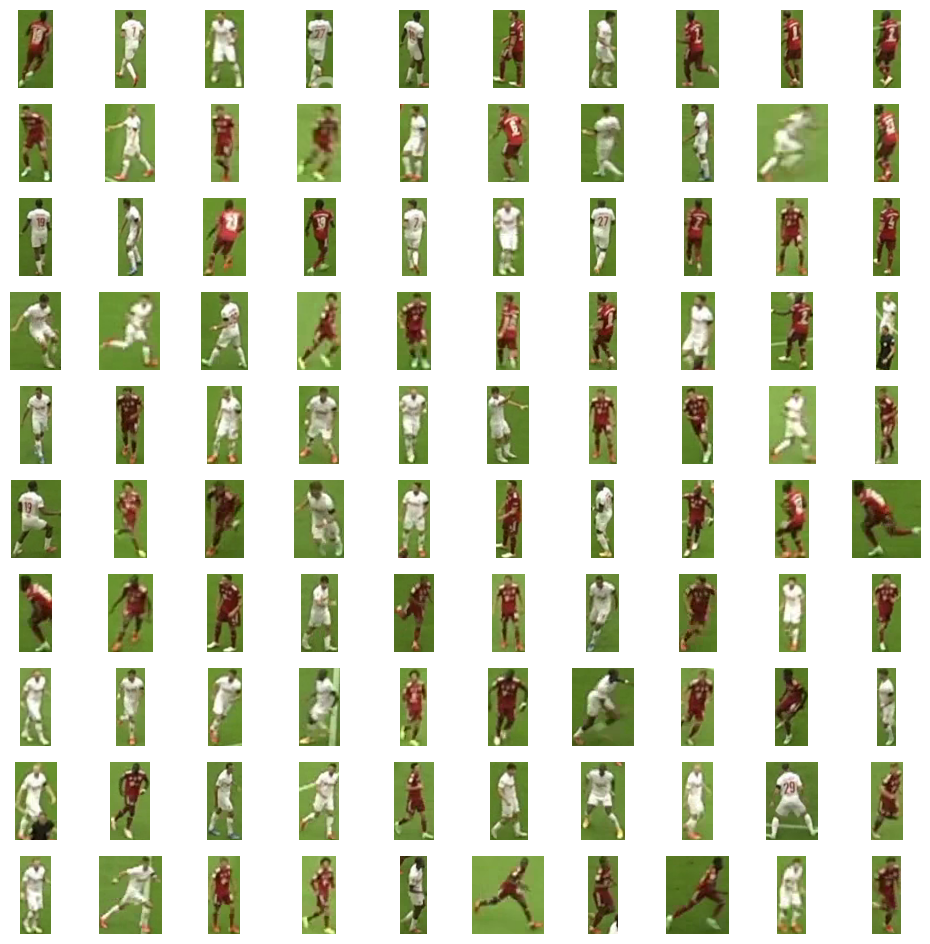

In [ ]:
#Collecting training data by croping the detected players from few frames of the video

#Importing the Libraries
from tqdm import tqdm
import supervision as sv

#Assigning the video path to variable
#ID for the object class representing the Players, 2 indicates the Player in the model’s classes
#Stride 30 means 30th frame in the video is processed, so 0,30,60,90.. frames are processed
S_Video = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"
Player_ID = 2
Stride = 30

#Assigning the pretrained YOLO model to a variable
Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

#Generating the frames with a stride of 30 of the source video
frame_generator = sv.get_video_frames_generator(S_Video,Stride)

#Creating an empty list that will hold the cropped images of detected players
crops = []

#Iterate over each frame in the video and to show the progress bar using tqdm
for frame in tqdm(frame_generator, desc='collecting crops'):

    #Storing the pretrained YOLO model to another variable
    player_detection_model = YOLO(Pretrained_Model)

    #Perform inference on the frame
    results = player_detection_model(frame, conf=0.3)

    #Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
    boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
    confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
    class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

    #To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
    boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
    confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
    class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

    #Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
    detections = sv.Detections(
        xyxy=boxes,
        confidence=confidences,
        class_id=class_ids.astype(int)
      )

    #Applying Non-Maximum Suppression (NMS) to remove redundant and overlapping bounding boxes retaining only the best one
    #Filter out detections to keep only when detected object is a player (class ID 2)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == Player_ID]

    #Crop the area of the frame where a player is detected, based on the bounding box coordinates (xyxy)
    #Appending the new crops to the list
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

#Display 100 instances of the collected detected players
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

##Extracting Features/Embeddings using Google's HuggingFace SigLIP for each crop

In [ ]:
#Utilizing Google's HuggingFace SigLIP for Calculating Embeddings or features for each crop

#Importing the PyTorch Library
#Import two classes from the Hugging Face Transformers library
#AutoProcessor is a flexible interface for handling input preprocessing
#SIGLIP Vision Transformer (ViT) model is used to generate embeddings or features from images used for classifications
import torch
from transformers import AutoProcessor, SiglipVisionModel

#SIGLIP_Model is assigned the model path 'google/siglip-base-patch16-224', a pretrained Model from the Hugging Face
#SIGLIP (Sign Language Image-Text Pretraining) model is provided by Google.
SIGLIP_Model = 'google/siglip-base-patch16-224'

#Use GPU if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#Download and loads the SIGLIP model weights from the Hugging Face Hub to the device
#And Create a processor object using the pre-trained SIGLIP model
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_Model).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_Model)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

##Reducing the features to smaller chunks of batched data

In [ ]:
#Import Libraries
#Import chunked to split a list into smaller chunks of a specified size
import numpy as np
from more_itertools import chunked

#Split the size of each batch so that model processess the data 32 items at a time
BATCH_SIZE = 32

#Converting an image from OpenCV to the Pillow format (used for image manipulation)
#Split the crops list in smaller list of 32 images
#Initialize an empty list data which will store feature vectors
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []

#Disable gradient calculation during inference, Extract features without computing gradients
with torch.no_grad():

    #Iterate over each batch of 32 and show the progress
    for batch in tqdm(batches, desc='embedding extraction'):

        #Convert batch of images into tensors and return PyTorch tensors and move inputs to device
        #SIGLIP model processes the batch of images and returns model outputs
        #Calculate average embedding for all tokens in the image and move the result back to device and convert to NumPy array
        #Append the embeddings to the current batch of data
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

#Concatenate all the embeddings after all batches are processed into a single NumPy array
#Print the shape of the array
data = np.concatenate(data)
data.shape

embedding extraction: 17it [00:07,  2.43it/s]


In [ ]:
#Import UMAP and KMeans for dimensionality reduction and Clustering
import umap
from sklearn.cluster import KMeans

#Initialize an object REDUCER to reduce data to 3 dimensions
#Initialize an object CLUSTERING_MODEL to group the data into 2 clusters
REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

#Apply UMAP using the object REDUCER for dimensionality reduction(3 Dimensions as initiated earlier)
#Apply KMeans using the object CLUSTERING_MODEL to cluster a data point into either of the Football Teams
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


##Classifying Each Players into Either of the Two Different Teams with Clustering(Not Goalkeeper yet)

In [ ]:
#Importing Supervision library for video utilities
#Importing tqdm to create progress bars during iterations
#Importing TeamClassifier module from a sports package by roboflow to classify teams
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

#Assigning the video path to variable
#ID for the object class representing the Players, 2 indicates the Player in the model’s classes
#Stride 30 means 30th frame in the video is processed, so 0,30,60,90.. frames are processed
S_Video = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"
Player_ID = 2
Stride = 30

#Generating the frames with a stride of 30 of the source video
frame_generator = sv.get_video_frames_generator(S_Video, Stride)

#Creating an empty list that will hold the cropped images of detected players
crops = []

#Iterate over each frame in the video and to show the progress bar using tqdm
for frame in tqdm(frame_generator, desc='collecting crops'):

    #Assigning the pretrained YOLO model to a variable
    Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

    #Storing the pretrained YOLO model to another variable
    player_detection_model = YOLO(Pretrained_Model)

    #Perform inference on the frame
    results = player_detection_model(frame, conf=0.3)

    #Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
    boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
    confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
    class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

    #To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
    boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
    confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
    class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

    #Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
    detections = sv.Detections(
        xyxy=boxes,
        confidence=confidences,
        class_id=class_ids.astype(int)
      )

    #Applying Non-Maximum Suppression (NMS) to remove redundant and overlapping bounding boxes retaining only the best one
    #Filter out detections to keep only when detected object is a player (class ID 2)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == Player_ID]

    #Crop the area of the frame where a player is detected, based on the bounding box coordinates (xyxy)
    #Appending the new crops to the list
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

#Initializing a team classifier to classify the cropped images of players into Either of the team
#fit(crops) Trains the team classifier using the player stored in crops
team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 150.2ms
Speed: 12.1ms preprocess, 150.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:02,  2.48s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 151.2ms
Speed: 9.6ms preprocess, 151.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:05,  2.66s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 142.9ms
Speed: 16.3ms preprocess, 142.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:08,  3.11s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 146.4ms
Speed: 9.6ms preprocess, 146.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:13,  3.73s/it]


0: 736x1280 21 Players, 3 Referees, 145.1ms
Speed: 9.5ms preprocess, 145.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:15,  3.24s/it]


0: 736x1280 22 Players, 4 Referees, 147.4ms
Speed: 10.0ms preprocess, 147.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:18,  2.92s/it]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 147.3ms
Speed: 9.7ms preprocess, 147.3ms inference, 4.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:20,  2.81s/it]


0: 736x1280 22 Players, 2 Referees, 144.8ms
Speed: 41.6ms preprocess, 144.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:23,  2.72s/it]


0: 736x1280 22 Players, 2 Referees, 146.7ms
Speed: 9.2ms preprocess, 146.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:28,  3.46s/it]


0: 736x1280 21 Players, 2 Referees, 146.7ms
Speed: 17.5ms preprocess, 146.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:31,  3.22s/it]


0: 736x1280 20 Players, 2 Referees, 152.6ms
Speed: 11.7ms preprocess, 152.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:34,  3.12s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 146.2ms
Speed: 16.2ms preprocess, 146.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:37,  3.29s/it]


0: 736x1280 21 Players, 2 Referees, 141.4ms
Speed: 13.0ms preprocess, 141.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:42,  3.73s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 143.6ms
Speed: 6.4ms preprocess, 143.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:44,  3.13s/it]


0: 736x1280 1 GoalKeeper, 24 Players, 2 Referees, 142.4ms
Speed: 6.3ms preprocess, 142.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:45,  2.66s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 144.2ms
Speed: 6.3ms preprocess, 144.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:47,  2.34s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 144.1ms
Speed: 10.5ms preprocess, 144.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:48,  2.11s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 142.5ms
Speed: 6.1ms preprocess, 142.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:50,  1.95s/it]


0: 736x1280 21 Players, 2 Referees, 141.7ms
Speed: 6.2ms preprocess, 141.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:52,  1.83s/it]


0: 736x1280 20 Players, 2 Referees, 140.8ms
Speed: 9.5ms preprocess, 140.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:53,  1.83s/it]


0: 736x1280 21 Players, 2 Referees, 142.6ms
Speed: 9.4ms preprocess, 142.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:56,  1.96s/it]


0: 736x1280 21 Players, 2 Referees, 145.2ms
Speed: 6.4ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:58,  1.95s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 143.6ms
Speed: 6.1ms preprocess, 143.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:59,  1.84s/it]


0: 736x1280 20 Players, 2 Referees, 145.4ms
Speed: 6.3ms preprocess, 145.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [01:01,  1.76s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 142.5ms
Speed: 6.1ms preprocess, 142.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [01:02,  2.52s/it]
Embedding extraction: 17it [00:07,  2.18it/s]


##Classifying Goalkeeper into Either of the Two Different Teams by Calculating Centroids of each team

In [ ]:
#Importing the NumPy Library for numerical operations
#Importing Supervision library for video utilities
import numpy as np
import supervision as sv

#Defining a function to determine the team to which the Goalkeeper belongs
#players-object representing all detected players on the field
#goalkeepers-object representing detected goalkeepers
#-> specifies the type of the return value where np.ndarray is a NumPy array
def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:

    #Extracting the coordinates of the anchor points at the bottom center of each goalkeeper's bounding box
    #Extracts the bottom-center coordinates of all players' bounding boxes
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    #Filtering the coordinates for players in team 0
    #Filtering the coordinates for players in team 1
    #Calculating the average (centroid) of the positions for both teams along the x and y coordinates.
    #Initializing an empty list to save the team IDs for goalkeepers
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []

    #Run the Loop through the coordinates of each goalkeeper
    #Calculating the Euclidean distance between the goalkeeper and the centroid of team 0
    #Calculating the distance to  team 1's centroid
    #Appending 0 (team 0) or 1 (team 1) depending on which centroid the goalkeeper is closer to
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    #Converting the list of team IDs for goalkeepers into a NumPy array and returns it.
    return np.array(goalkeepers_team_id)

##Classifying Players along with Goalkeepers into Different Teams in the Complete Video

In [ ]:
#Classifying Players along with Goalkeepers into Different Teams in the Complete Video


#Importing the Required Libraries
from ultralytics import YOLO
import numpy as np
import supervision as sv
from tqdm import tqdm

#Assigning the video paths to variables
S_Video = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/A1606b0e6_0 (10).mp4"
S_Video_Output = "/content/drive/MyDrive/Football_Project/Implementation/Source_Videos/Results_Final.mp4"

#IDs for the object classes representing the ball,GK,Players,Referee. Numbers indicate the model’s classes
Ball_ID = 0
GoalKeeper_ID = 1
Player_ID = 2
Referee_ID = 3

#Initializes an object of the EllipseAnnotator from the supervision for drawing the bounding Ellipse with assigned color
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

#Initializes an object of the LabelAnnotator from the supervision for adding text labels at bottom centre with assigned color
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)

#Initializes an object of the TriangleAnnotator from the supervision for drawing the Triangle with assigned color
triangle_annotate = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25, height=20, outline_thickness=2
)

#Initializes the tracker to track objects across frames and the tracker.reset() to reset the tracker state
tracker = sv.ByteTrack()
tracker.reset()

#Assigning the pretrained YOLO model to a variable
Pretrained_Model = "/content/drive/MyDrive/Football_Project/Implementation/50_Epochs_B_R_P_GK.pt"

#Storing the pretrained YOLO model to another variable
player_detection_model = YOLO(Pretrained_Model)


#Retrieves metadata from the video file, such as frame rate, frame size, resolution and total number of frames.
#VideoSink Initializes a video writer for saving the processed video frames.
#Generating the frames of the source video
#And Get the total number of frames using supervision's video info
video_info = sv.VideoInfo.from_video_path(S_Video)
video_sink = sv.VideoSink(S_Video_Output, video_info)
frame_generator = sv.get_video_frames_generator(S_Video)
total_frames = video_info.total_frames


#Opens the video writer context to write frames
with video_sink:

  #Iterate over each frame in the video and to show the progress bar using tqdm
  for frame in tqdm(frame_generator, total=video_info.total_frames):

      #Perform inference on the frame
      results = player_detection_model(frame, conf=0.3)

      #Extracting the bounding boxes coordinates, confidences, ClassIDs for detected objects and store as numpy array
      boxes = np.array([result.boxes.xyxy.cpu().numpy() for result in results])
      confidences = np.array([result.boxes.conf.cpu().numpy() for result in results])
      class_ids = np.array([result.boxes.cls.cpu().numpy() for result in results])

      #To avoid errors it assigns empty arrays with appropriate shapes, if no detections are found
      boxes = boxes[0] if len(boxes) > 0 else np.empty((0, 4))
      confidences = confidences[0] if len(confidences) > 0 else np.empty(0)
      class_ids = class_ids[0] if len(class_ids) > 0 else np.empty(0)

      #Initializes an object of the Detections from the supervision which contains bounding box coordinates, Confidence and ClassIDs
      detections = sv.Detections(
          xyxy=boxes,
          confidence=confidences,
          class_id=class_ids.astype(int)
      )

      #Dividing the detections for ball class alone
      #Filtering the detections for the ball class and pad the bounding box by 10 pixels
      ball_detections = detections[detections.class_id == Ball_ID]
      ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)


      #Filtering all the other detections except ball class
      #Applying Non-Maximum Suppression (NMS) to remove redundant bounding boxes of all other detections
      #And finally tracker is updated with remaining detections
      other_detections = detections[detections.class_id != Ball_ID]
      other_detections = other_detections.with_nms(threshold=0.5, class_agnostic=True)
      other_detections = tracker.update_with_detections(detections=other_detections)

      #Filtering all the other detections and storing them
      goalkeepers_detections = other_detections[other_detections.class_id == GoalKeeper_ID]
      players_detections = other_detections[other_detections.class_id == Player_ID]
      referees_detections = other_detections[other_detections.class_id == Referee_ID]

      #Crop player images for classification
      #Classifing players into teams using team_classifier.predict
      players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
      players_detections.class_id = team_classifier.predict(players_crops)

      #Assigning team IDs to goalkeepers based on the distances to team's centroids using function(resolve_goalkeepers_team_id) defined
      #Adjust the class IDs of referee detections
      goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
      players_detections, goalkeepers_detections)
      referees_detections.class_id -= 1

      #Merging the detections of different categories (players, goalkeepers, and referees) into a single sv.Detections object
      other_detections = sv.Detections.merge([
      players_detections, goalkeepers_detections, referees_detections])

      #Create a list of labels for the detected objects, where each label is the tracker's ID
      labels = [
          f"#{tracker_id}"
          for tracker_id in other_detections.tracker_id
      ]

      #Ensuring that the class_id attribute of the other_detections object is of integer type
      other_detections.class_id = other_detections.class_id.astype(int)


      #Creates a copy of the original frame
      #Modifying it by applying the Ellipitical boxes using the other_detections object
      #Again Modifying it by applying the Triangle using the ball_detections object
      #And then modify the annotated frame by applying the labels for other_detections objects beside bounding boxes using the previously generated labels
      annotated_frame = frame.copy()
      annotated_frame = ellipse_annotator.annotate(annotated_frame,other_detections)
      annotated_frame = triangle_annotate.annotate(annotated_frame,ball_detections)
      annotated_frame = label_annotator.annotate(annotated_frame,other_detections,labels=labels)

      # Write the annotated frame to the output video using videosink writer
      video_sink.write_frame(annotated_frame)


  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 144.8ms
Speed: 8.3ms preprocess, 144.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  0%|          | 1/750 [00:03<44:06,  3.53s/it]


0: 736x1280 2 Balls, 21 Players, 2 Referees, 198.4ms
Speed: 10.8ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  0%|          | 2/750 [00:06<36:53,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 8.8ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
  0%|          | 3/750 [00:08<34:32,  2.77s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 179.9ms
Speed: 12.3ms preprocess, 179.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
  1%|          | 4/750 [00:12<41:02,  3.30s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.4ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
  1%|          | 5/750 [00:15<38:47,  3.12s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 7.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
  1%|          | 6/750 [00:18<36:17,  2.93s/it]


0: 736x1280 20 Players, 2 Referees, 195.9ms
Speed: 8.9ms preprocess, 195.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
  1%|          | 7/750 [00:20<34:47,  2.81s/it]


0: 736x1280 20 Players, 2 Referees, 181.3ms
Speed: 9.3ms preprocess, 181.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
  1%|          | 8/750 [00:23<33:42,  2.73s/it]


0: 736x1280 20 Players, 2 Referees, 196.6ms
Speed: 9.5ms preprocess, 196.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
  1%|          | 9/750 [00:27<40:17,  3.26s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 190.1ms
Speed: 10.2ms preprocess, 190.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  1%|▏         | 10/750 [00:30<37:38,  3.05s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 197.9ms
Speed: 6.9ms preprocess, 197.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
  1%|▏         | 11/750 [00:32<35:39,  2.90s/it]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
  2%|▏         | 12/750 [00:35<34:16,  2.79s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 182.8ms
Speed: 7.2ms preprocess, 182.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
  2%|▏         | 13/750 [00:39<37:52,  3.08s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 192.7ms
Speed: 10.3ms preprocess, 192.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
  2%|▏         | 14/750 [00:42<39:03,  3.18s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 195.2ms
Speed: 9.4ms preprocess, 195.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.59it/s]
  2%|▏         | 15/750 [00:45<36:47,  3.00s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 9.4ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
  2%|▏         | 16/750 [00:47<35:00,  2.86s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 191.6ms
Speed: 10.4ms preprocess, 191.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
  2%|▏         | 17/750 [00:50<36:45,  3.01s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 185.4ms
Speed: 6.7ms preprocess, 185.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.85it/s]
  2%|▏         | 18/750 [00:54<38:25,  3.15s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 196.0ms
Speed: 12.3ms preprocess, 196.0ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
  3%|▎         | 19/750 [00:57<37:08,  3.05s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 195.9ms
Speed: 8.8ms preprocess, 195.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
  3%|▎         | 20/750 [00:59<35:09,  2.89s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 192.5ms
Speed: 9.0ms preprocess, 192.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.56it/s]
  3%|▎         | 21/750 [01:02<36:15,  2.98s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 194.5ms
Speed: 8.0ms preprocess, 194.5ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.66it/s]
  3%|▎         | 22/750 [01:05<34:35,  2.85s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
  3%|▎         | 23/750 [01:09<37:48,  3.12s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 177.1ms
Speed: 10.1ms preprocess, 177.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
  3%|▎         | 24/750 [01:11<35:53,  2.97s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 178.2ms
Speed: 9.0ms preprocess, 178.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
  3%|▎         | 25/750 [01:14<34:13,  2.83s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 9.1ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
  3%|▎         | 26/750 [01:17<35:38,  2.95s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 196.5ms
Speed: 9.5ms preprocess, 196.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.56it/s]
  4%|▎         | 27/750 [01:20<35:21,  2.93s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 180.3ms
Speed: 11.4ms preprocess, 180.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.12it/s]
  4%|▎         | 28/750 [01:24<38:08,  3.17s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 6.8ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  4%|▍         | 29/750 [01:26<35:45,  2.98s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 180.7ms
Speed: 7.1ms preprocess, 180.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
  4%|▍         | 30/750 [01:29<36:34,  3.05s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.2ms
Speed: 9.3ms preprocess, 183.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
  4%|▍         | 31/750 [01:32<34:47,  2.90s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.6ms
Speed: 7.6ms preprocess, 183.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
  4%|▍         | 32/750 [01:35<35:32,  2.97s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 11.6ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
  4%|▍         | 33/750 [01:38<36:41,  3.07s/it]


0: 736x1280 20 Players, 2 Referees, 181.3ms
Speed: 7.7ms preprocess, 181.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
  5%|▍         | 34/750 [01:41<34:41,  2.91s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
  5%|▍         | 35/750 [01:44<35:59,  3.02s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 185.3ms
Speed: 8.3ms preprocess, 185.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
  5%|▍         | 36/750 [01:47<34:07,  2.87s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
  5%|▍         | 37/750 [01:50<36:23,  3.06s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.1ms
Speed: 13.7ms preprocess, 183.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
  5%|▌         | 38/750 [01:53<35:17,  2.97s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 196.3ms
Speed: 8.4ms preprocess, 196.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.62it/s]
  5%|▌         | 39/750 [01:56<36:15,  3.06s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.3ms
Speed: 8.8ms preprocess, 183.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  5%|▌         | 40/750 [01:59<34:13,  2.89s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.3ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
  5%|▌         | 41/750 [02:01<33:01,  2.79s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 193.8ms
Speed: 15.2ms preprocess, 193.8ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
  6%|▌         | 42/750 [02:05<36:25,  3.09s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 180.8ms
Speed: 8.8ms preprocess, 180.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
  6%|▌         | 43/750 [02:08<34:18,  2.91s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
  6%|▌         | 44/750 [02:11<35:35,  3.02s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 191.5ms
Speed: 9.6ms preprocess, 191.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.64it/s]
  6%|▌         | 45/750 [02:13<33:45,  2.87s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]
  6%|▌         | 46/750 [02:17<34:21,  2.93s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.7ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  6%|▋         | 47/750 [02:20<35:57,  3.07s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 7.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.63it/s]
  6%|▋         | 48/750 [02:23<36:35,  3.13s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 196.0ms
Speed: 9.9ms preprocess, 196.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
  7%|▋         | 49/750 [02:26<34:32,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.5ms
Speed: 9.6ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
  7%|▋         | 50/750 [02:28<32:57,  2.83s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 181.1ms
Speed: 7.4ms preprocess, 181.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
  7%|▋         | 51/750 [02:32<34:40,  2.98s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 9.8ms preprocess, 198.5ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
  7%|▋         | 52/750 [02:34<34:12,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 192.6ms
Speed: 8.7ms preprocess, 192.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
  7%|▋         | 53/750 [02:38<35:17,  3.04s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 178.3ms
Speed: 9.4ms preprocess, 178.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
  7%|▋         | 54/750 [02:40<33:33,  2.89s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 193.8ms
Speed: 8.3ms preprocess, 193.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]
  7%|▋         | 55/750 [02:43<32:28,  2.80s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.9ms
Speed: 12.1ms preprocess, 198.9ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
  7%|▋         | 56/750 [02:47<35:41,  3.09s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.5ms
Speed: 12.8ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
  8%|▊         | 57/750 [02:49<33:49,  2.93s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 178.0ms
Speed: 8.1ms preprocess, 178.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
  8%|▊         | 58/750 [02:52<35:03,  3.04s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 7.2ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
  8%|▊         | 59/750 [02:55<33:20,  2.89s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 189.5ms
Speed: 9.0ms preprocess, 189.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
  8%|▊         | 60/750 [02:58<33:02,  2.87s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 12.9ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.10it/s]
  8%|▊         | 61/750 [03:02<35:48,  3.12s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
  8%|▊         | 62/750 [03:04<33:38,  2.93s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 177.3ms
Speed: 9.1ms preprocess, 177.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
  8%|▊         | 63/750 [03:07<34:55,  3.05s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 198.4ms
Speed: 8.0ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.82it/s]
  9%|▊         | 64/750 [03:10<33:01,  2.89s/it]


0: 736x1280 20 Players, 2 Referees, 178.9ms
Speed: 10.4ms preprocess, 178.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
  9%|▊         | 65/750 [03:13<33:36,  2.94s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
  9%|▉         | 66/750 [03:16<34:15,  3.01s/it]


0: 736x1280 20 Players, 2 Referees, 177.1ms
Speed: 8.9ms preprocess, 177.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
  9%|▉         | 67/750 [03:19<32:32,  2.86s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 7.9ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
  9%|▉         | 68/750 [03:22<33:56,  2.99s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 185.1ms
Speed: 9.1ms preprocess, 185.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.56it/s]
  9%|▉         | 69/750 [03:24<32:16,  2.84s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.59it/s]
  9%|▉         | 70/750 [03:28<35:00,  3.09s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 195.6ms
Speed: 14.5ms preprocess, 195.6ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
  9%|▉         | 71/750 [03:31<33:44,  2.98s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 196.1ms
Speed: 10.4ms preprocess, 196.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 10%|▉         | 72/750 [03:34<34:39,  3.07s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.58it/s]
 10%|▉         | 73/750 [03:37<32:46,  2.91s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 177.2ms
Speed: 9.8ms preprocess, 177.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 10%|▉         | 74/750 [03:39<31:38,  2.81s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 180.1ms
Speed: 16.9ms preprocess, 180.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 10%|█         | 75/750 [03:43<34:58,  3.11s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 182.8ms
Speed: 12.6ms preprocess, 182.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 10%|█         | 76/750 [03:46<33:04,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 7.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 10%|█         | 77/750 [03:48<31:39,  2.82s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 195.9ms
Speed: 6.4ms preprocess, 195.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 10%|█         | 78/750 [03:51<33:21,  2.98s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 184.5ms
Speed: 18.3ms preprocess, 184.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 11%|█         | 79/750 [03:54<33:18,  2.98s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 194.2ms
Speed: 9.7ms preprocess, 194.2ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 11%|█         | 80/750 [03:58<35:15,  3.16s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 10.8ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 11%|█         | 81/750 [04:01<33:06,  2.97s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 178.3ms
Speed: 10.0ms preprocess, 178.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 11%|█         | 82/750 [04:04<34:20,  3.08s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 190.7ms
Speed: 6.9ms preprocess, 190.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 11%|█         | 83/750 [04:06<32:28,  2.92s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 8.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 11%|█         | 84/750 [04:10<33:41,  3.04s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 186.3ms
Speed: 11.1ms preprocess, 186.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.05it/s]
 11%|█▏        | 85/750 [04:13<33:31,  3.02s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 192.1ms
Speed: 10.2ms preprocess, 192.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 11%|█▏        | 86/750 [04:15<31:46,  2.87s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 10.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 12%|█▏        | 87/750 [04:18<30:41,  2.78s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 179.5ms
Speed: 10.8ms preprocess, 179.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 12%|█▏        | 88/750 [04:21<32:35,  2.95s/it]


0: 736x1280 1 Ball, 20 Players, 4 Referees, 192.5ms
Speed: 10.0ms preprocess, 192.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 12%|█▏        | 89/750 [04:25<35:03,  3.18s/it]


0: 736x1280 1 Ball, 20 Players, 5 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 12%|█▏        | 90/750 [04:27<32:53,  2.99s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 183.0ms
Speed: 10.2ms preprocess, 183.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 12%|█▏        | 91/750 [04:30<31:20,  2.85s/it]


0: 736x1280 20 Players, 5 Referees, 198.4ms
Speed: 9.7ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 12%|█▏        | 92/750 [04:33<32:54,  3.00s/it]


0: 736x1280 1 Ball, 21 Players, 5 Referees, 186.4ms
Speed: 9.0ms preprocess, 186.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 12%|█▏        | 93/750 [04:36<33:17,  3.04s/it]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 190.3ms
Speed: 9.7ms preprocess, 190.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 13%|█▎        | 94/750 [04:40<33:24,  3.06s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 187.8ms
Speed: 7.8ms preprocess, 187.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 13%|█▎        | 95/750 [04:42<31:42,  2.90s/it]


0: 736x1280 22 Players, 3 Referees, 185.3ms
Speed: 12.2ms preprocess, 185.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 13%|█▎        | 96/750 [04:45<30:34,  2.81s/it]


0: 736x1280 22 Players, 3 Referees, 197.9ms
Speed: 7.2ms preprocess, 197.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 13%|█▎        | 97/750 [04:48<32:01,  2.94s/it]


0: 736x1280 21 Players, 3 Referees, 184.8ms
Speed: 7.2ms preprocess, 184.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 13%|█▎        | 98/750 [04:52<34:36,  3.19s/it]


0: 736x1280 22 Players, 2 Referees, 201.1ms
Speed: 14.8ms preprocess, 201.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 13%|█▎        | 99/750 [04:54<32:52,  3.03s/it]


0: 736x1280 22 Players, 4 Referees, 188.4ms
Speed: 9.6ms preprocess, 188.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 13%|█▎        | 100/750 [04:57<31:08,  2.87s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 7.7ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 13%|█▎        | 101/750 [04:59<30:00,  2.77s/it]


0: 736x1280 21 Players, 3 Referees, 179.4ms
Speed: 7.3ms preprocess, 179.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 14%|█▎        | 102/750 [05:02<29:07,  2.70s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 14%|█▎        | 103/750 [05:07<35:38,  3.30s/it]


0: 736x1280 20 Players, 3 Referees, 176.5ms
Speed: 7.9ms preprocess, 176.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 14%|█▍        | 104/750 [05:09<33:07,  3.08s/it]


0: 736x1280 22 Players, 3 Referees, 194.9ms
Speed: 9.6ms preprocess, 194.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
 14%|█▍        | 105/750 [05:12<31:19,  2.91s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 7.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 14%|█▍        | 106/750 [05:14<30:08,  2.81s/it]


0: 736x1280 20 Players, 3 Referees, 177.9ms
Speed: 6.7ms preprocess, 177.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 14%|█▍        | 107/750 [05:17<29:46,  2.78s/it]


0: 736x1280 21 Players, 3 Referees, 198.5ms
Speed: 11.9ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 14%|█▍        | 108/750 [05:21<34:20,  3.21s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 7.7ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 15%|█▍        | 109/750 [05:24<32:19,  3.03s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 8.5ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 15%|█▍        | 110/750 [05:26<30:44,  2.88s/it]


0: 736x1280 21 Players, 3 Referees, 187.7ms
Speed: 9.1ms preprocess, 187.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 15%|█▍        | 111/750 [05:29<29:42,  2.79s/it]


0: 736x1280 21 Players, 3 Referees, 179.6ms
Speed: 8.2ms preprocess, 179.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 15%|█▍        | 112/750 [05:32<31:15,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 198.4ms
Speed: 13.2ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 15%|█▌        | 113/750 [05:36<34:21,  3.24s/it]


0: 736x1280 22 Players, 4 Referees, 182.8ms
Speed: 7.8ms preprocess, 182.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 15%|█▌        | 114/750 [05:39<32:13,  3.04s/it]


0: 736x1280 22 Players, 3 Referees, 187.7ms
Speed: 7.1ms preprocess, 187.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 15%|█▌        | 115/750 [05:41<30:37,  2.89s/it]


0: 736x1280 21 Players, 3 Referees, 198.5ms
Speed: 11.1ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.59it/s]
 15%|█▌        | 116/750 [05:44<29:32,  2.80s/it]


0: 736x1280 20 Players, 3 Referees, 199.1ms
Speed: 7.4ms preprocess, 199.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 16%|█▌        | 117/750 [05:48<32:32,  3.08s/it]


0: 736x1280 21 Players, 3 Referees, 178.0ms
Speed: 9.6ms preprocess, 178.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 16%|█▌        | 118/750 [05:51<33:27,  3.18s/it]


0: 736x1280 21 Players, 3 Referees, 184.7ms
Speed: 8.5ms preprocess, 184.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 16%|█▌        | 119/750 [05:54<31:40,  3.01s/it]


0: 736x1280 21 Players, 3 Referees, 179.5ms
Speed: 7.9ms preprocess, 179.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 16%|█▌        | 120/750 [05:56<30:09,  2.87s/it]


0: 736x1280 21 Players, 3 Referees, 197.8ms
Speed: 7.4ms preprocess, 197.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 16%|█▌        | 121/750 [05:59<30:45,  2.93s/it]


0: 736x1280 21 Players, 3 Referees, 176.8ms
Speed: 10.6ms preprocess, 176.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 16%|█▋        | 122/750 [06:02<31:40,  3.03s/it]


0: 736x1280 21 Players, 3 Referees, 180.9ms
Speed: 9.5ms preprocess, 180.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 16%|█▋        | 123/750 [06:05<30:04,  2.88s/it]


0: 736x1280 23 Players, 3 Referees, 195.5ms
Speed: 9.0ms preprocess, 195.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 17%|█▋        | 124/750 [06:08<31:54,  3.06s/it]


0: 736x1280 23 Players, 3 Referees, 177.8ms
Speed: 10.0ms preprocess, 177.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 17%|█▋        | 125/750 [06:11<30:18,  2.91s/it]


0: 736x1280 21 Players, 3 Referees, 190.1ms
Speed: 10.2ms preprocess, 190.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 17%|█▋        | 126/750 [06:15<32:57,  3.17s/it]


0: 736x1280 23 Players, 3 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.04it/s]
 17%|█▋        | 127/750 [06:18<31:30,  3.03s/it]


0: 736x1280 22 Players, 3 Referees, 181.2ms
Speed: 6.9ms preprocess, 181.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 17%|█▋        | 128/750 [06:20<29:55,  2.89s/it]


0: 736x1280 21 Players, 3 Referees, 192.1ms
Speed: 9.4ms preprocess, 192.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 17%|█▋        | 129/750 [06:23<31:29,  3.04s/it]


0: 736x1280 21 Players, 3 Referees, 193.4ms
Speed: 7.7ms preprocess, 193.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 17%|█▋        | 130/750 [06:26<30:43,  2.97s/it]


0: 736x1280 21 Players, 3 Referees, 187.7ms
Speed: 13.1ms preprocess, 187.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 17%|█▋        | 131/750 [06:30<33:17,  3.23s/it]


0: 736x1280 21 Players, 3 Referees, 192.9ms
Speed: 9.6ms preprocess, 192.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 18%|█▊        | 132/750 [06:33<31:12,  3.03s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 18%|█▊        | 133/750 [06:35<29:36,  2.88s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 179.1ms
Speed: 7.3ms preprocess, 179.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 18%|█▊        | 134/750 [06:38<28:35,  2.78s/it]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 186.2ms
Speed: 9.9ms preprocess, 186.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 18%|█▊        | 135/750 [06:42<32:26,  3.17s/it]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 180.3ms
Speed: 13.7ms preprocess, 180.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.05it/s]
 18%|█▊        | 136/750 [06:45<32:30,  3.18s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 177.6ms
Speed: 15.0ms preprocess, 177.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 18%|█▊        | 137/750 [06:48<30:25,  2.98s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 18%|█▊        | 138/750 [06:50<29:02,  2.85s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 7.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 19%|█▊        | 139/750 [06:53<28:02,  2.75s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 186.2ms
Speed: 6.8ms preprocess, 186.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 19%|█▊        | 140/750 [06:57<32:46,  3.22s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 200.8ms
Speed: 10.1ms preprocess, 200.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 19%|█▉        | 141/750 [07:00<31:17,  3.08s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 176.5ms
Speed: 9.7ms preprocess, 176.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 19%|█▉        | 142/750 [07:02<29:31,  2.91s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 19%|█▉        | 143/750 [07:05<28:17,  2.80s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 185.9ms
Speed: 7.6ms preprocess, 185.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 19%|█▉        | 144/750 [07:07<27:21,  2.71s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 198.3ms
Speed: 6.4ms preprocess, 198.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.53it/s]
 19%|█▉        | 145/750 [07:12<32:54,  3.26s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 198.4ms
Speed: 8.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.94it/s]
 19%|█▉        | 146/750 [07:14<30:45,  3.06s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 181.7ms
Speed: 12.1ms preprocess, 181.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 20%|█▉        | 147/750 [07:17<29:08,  2.90s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 190.3ms
Speed: 8.7ms preprocess, 190.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 20%|█▉        | 148/750 [07:19<28:00,  2.79s/it]


0: 736x1280 22 Players, 4 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 20%|█▉        | 149/750 [07:22<27:56,  2.79s/it]


0: 736x1280 22 Players, 4 Referees, 198.5ms
Speed: 10.6ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 20%|██        | 150/750 [07:26<30:37,  3.06s/it]


0: 736x1280 22 Players, 4 Referees, 192.2ms
Speed: 9.4ms preprocess, 192.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 20%|██        | 151/750 [07:29<31:32,  3.16s/it]


0: 736x1280 23 Players, 3 Referees, 198.4ms
Speed: 8.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.03it/s]
 20%|██        | 152/750 [07:32<29:54,  3.00s/it]


0: 736x1280 22 Players, 3 Referees, 196.9ms
Speed: 12.1ms preprocess, 196.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 20%|██        | 153/750 [07:34<28:25,  2.86s/it]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 198.4ms
Speed: 7.7ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 21%|██        | 154/750 [07:38<29:18,  2.95s/it]


0: 736x1280 22 Players, 3 Referees, 177.3ms
Speed: 15.3ms preprocess, 177.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.72it/s]
 21%|██        | 155/750 [07:41<29:42,  3.00s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
 21%|██        | 156/750 [07:44<30:48,  3.11s/it]


0: 736x1280 1 Ball, 26 Players, 2 Referees, 198.4ms
Speed: 6.2ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.94it/s]
 21%|██        | 157/750 [07:47<29:22,  2.97s/it]


0: 736x1280 24 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
 21%|██        | 158/750 [07:49<28:11,  2.86s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 8.5ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 21%|██        | 159/750 [07:53<30:57,  3.14s/it]


0: 736x1280 1 Ball, 23 Players, 4 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 21%|██▏       | 160/750 [07:56<29:10,  2.97s/it]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 184.4ms
Speed: 8.2ms preprocess, 184.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 21%|██▏       | 161/750 [07:58<27:45,  2.83s/it]


0: 736x1280 22 Players, 4 Referees, 198.4ms
Speed: 8.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 22%|██▏       | 162/750 [08:02<29:39,  3.03s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 180.4ms
Speed: 7.4ms preprocess, 180.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 22%|██▏       | 163/750 [08:05<29:10,  2.98s/it]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 198.4ms
Speed: 16.1ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 22%|██▏       | 164/750 [08:08<30:59,  3.17s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 8.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 22%|██▏       | 165/750 [08:11<29:07,  2.99s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 176.7ms
Speed: 7.2ms preprocess, 176.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 22%|██▏       | 166/750 [08:13<27:44,  2.85s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 11.0ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 22%|██▏       | 167/750 [08:16<26:45,  2.75s/it]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 195.9ms
Speed: 9.5ms preprocess, 195.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 22%|██▏       | 168/750 [08:20<31:01,  3.20s/it]


0: 736x1280 22 Players, 4 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 23%|██▎       | 169/750 [08:23<30:22,  3.14s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 6.1ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
 23%|██▎       | 170/750 [08:26<28:43,  2.97s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 180.2ms
Speed: 9.5ms preprocess, 180.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 23%|██▎       | 171/750 [08:28<27:19,  2.83s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 23%|██▎       | 172/750 [08:31<26:19,  2.73s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 176.3ms
Speed: 6.9ms preprocess, 176.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 23%|██▎       | 173/750 [08:35<31:34,  3.28s/it]


0: 736x1280 24 Players, 3 Referees, 185.9ms
Speed: 12.7ms preprocess, 185.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 23%|██▎       | 174/750 [08:38<29:35,  3.08s/it]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 188.7ms
Speed: 9.9ms preprocess, 188.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.76it/s]
 23%|██▎       | 175/750 [08:40<28:10,  2.94s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 188.8ms
Speed: 9.2ms preprocess, 188.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 23%|██▎       | 176/750 [08:43<27:01,  2.82s/it]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 198.4ms
Speed: 8.2ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 24%|██▎       | 177/750 [08:46<26:10,  2.74s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.3ms
Speed: 8.0ms preprocess, 198.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 24%|██▎       | 178/750 [08:49<28:55,  3.03s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 188.8ms
Speed: 14.4ms preprocess, 188.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
 24%|██▍       | 179/750 [08:52<27:29,  2.89s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 7.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 24%|██▍       | 180/750 [08:55<29:06,  3.06s/it]


0: 736x1280 1 Ball, 25 Players, 3 Referees, 194.2ms
Speed: 10.8ms preprocess, 194.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 24%|██▍       | 181/750 [08:58<27:25,  2.89s/it]


0: 736x1280 1 Ball, 24 Players, 3 Referees, 183.2ms
Speed: 11.3ms preprocess, 183.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.85it/s]
 24%|██▍       | 182/750 [09:01<27:22,  2.89s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 198.8ms
Speed: 13.9ms preprocess, 198.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.68it/s]
 24%|██▍       | 183/750 [09:04<29:51,  3.16s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 9.0ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 25%|██▍       | 184/750 [09:07<28:02,  2.97s/it]


0: 736x1280 21 Players, 4 Referees, 177.4ms
Speed: 8.1ms preprocess, 177.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 25%|██▍       | 185/750 [09:10<29:20,  3.12s/it]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 196.2ms
Speed: 9.7ms preprocess, 196.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 25%|██▍       | 186/750 [09:13<27:48,  2.96s/it]


0: 736x1280 22 Players, 4 Referees, 181.9ms
Speed: 11.2ms preprocess, 181.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.07it/s]
 25%|██▍       | 187/750 [09:16<28:50,  3.07s/it]


0: 736x1280 22 Players, 3 Referees, 186.9ms
Speed: 14.4ms preprocess, 186.9ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 25%|██▌       | 188/750 [09:20<29:12,  3.12s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 187.8ms
Speed: 12.4ms preprocess, 187.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 25%|██▌       | 189/750 [09:22<27:22,  2.93s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 191.3ms
Speed: 8.6ms preprocess, 191.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.85it/s]
 25%|██▌       | 190/750 [09:25<26:19,  2.82s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 179.6ms
Speed: 8.3ms preprocess, 179.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.90it/s]
 25%|██▌       | 191/750 [09:28<28:07,  3.02s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 8.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 26%|██▌       | 192/750 [09:32<30:14,  3.25s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.5ms
Speed: 13.7ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.57it/s]
 26%|██▌       | 193/750 [09:35<29:19,  3.16s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 186.6ms
Speed: 11.0ms preprocess, 186.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.80it/s]
 26%|██▌       | 194/750 [09:37<27:40,  2.99s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 190.0ms
Speed: 17.3ms preprocess, 190.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 26%|██▌       | 195/750 [09:40<26:25,  2.86s/it]


0: 736x1280 1 Ball, 22 Players, 5 Referees, 198.5ms
Speed: 9.1ms preprocess, 198.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.96it/s]
 26%|██▌       | 196/750 [09:43<25:39,  2.78s/it]


0: 736x1280 1 Ball, 21 Players, 4 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 26%|██▋       | 197/750 [09:47<31:03,  3.37s/it]


0: 736x1280 1 Ball, 23 Players, 3 Referees, 177.6ms
Speed: 7.4ms preprocess, 177.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.94it/s]
 26%|██▋       | 198/750 [09:50<28:55,  3.14s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 178.6ms
Speed: 6.5ms preprocess, 178.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.93it/s]
 27%|██▋       | 199/750 [09:53<27:21,  2.98s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 179.4ms
Speed: 9.8ms preprocess, 179.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.95it/s]
 27%|██▋       | 200/750 [09:55<26:09,  2.85s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 191.4ms
Speed: 11.8ms preprocess, 191.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.91it/s]
 27%|██▋       | 201/750 [09:58<26:52,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.5ms
Speed: 11.5ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.88it/s]
 27%|██▋       | 202/750 [10:01<27:34,  3.02s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.01it/s]
 27%|██▋       | 203/750 [10:05<29:11,  3.20s/it]


0: 736x1280 1 Ball, 22 Players, 4 Referees, 198.3ms
Speed: 8.8ms preprocess, 198.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.94it/s]
 27%|██▋       | 204/750 [10:08<27:36,  3.03s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 11.7ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.02it/s]
 27%|██▋       | 205/750 [10:10<26:24,  2.91s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.5ms
Speed: 9.5ms preprocess, 198.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.71it/s]
 27%|██▋       | 206/750 [10:14<28:46,  3.17s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.7ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.02it/s]
 28%|██▊       | 207/750 [10:17<27:21,  3.02s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 193.5ms
Speed: 8.5ms preprocess, 193.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 28%|██▊       | 208/750 [10:19<25:59,  2.88s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 6.7ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 28%|██▊       | 209/750 [10:22<25:05,  2.78s/it]


0: 736x1280 22 Players, 2 Referees, 178.0ms
Speed: 10.5ms preprocess, 178.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 28%|██▊       | 210/750 [10:26<28:54,  3.21s/it]


0: 736x1280 22 Players, 2 Referees, 181.1ms
Speed: 10.8ms preprocess, 181.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.89it/s]
 28%|██▊       | 211/750 [10:30<29:27,  3.28s/it]


0: 736x1280 22 Players, 2 Referees, 191.6ms
Speed: 10.7ms preprocess, 191.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.93it/s]
 28%|██▊       | 212/750 [10:32<27:34,  3.07s/it]


0: 736x1280 21 Players, 2 Referees, 185.2ms
Speed: 10.1ms preprocess, 185.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 28%|██▊       | 213/750 [10:35<26:12,  2.93s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 179.7ms
Speed: 9.5ms preprocess, 179.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 29%|██▊       | 214/750 [10:37<25:08,  2.81s/it]


0: 736x1280 2 Balls, 22 Players, 2 Referees, 194.8ms
Speed: 10.2ms preprocess, 194.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 29%|██▊       | 215/750 [10:42<29:29,  3.31s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 182.9ms
Speed: 15.2ms preprocess, 182.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 29%|██▉       | 216/750 [10:45<28:13,  3.17s/it]


0: 736x1280 21 Players, 2 Referees, 184.5ms
Speed: 9.9ms preprocess, 184.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 29%|██▉       | 217/750 [10:47<26:36,  3.00s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 176.8ms
Speed: 7.7ms preprocess, 176.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 29%|██▉       | 218/750 [10:50<25:18,  2.85s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 8.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 29%|██▉       | 219/750 [10:52<24:25,  2.76s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 29%|██▉       | 220/750 [10:56<26:39,  3.02s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 14.3ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 29%|██▉       | 221/750 [10:59<26:06,  2.96s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 6.9ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 30%|██▉       | 222/750 [11:02<27:40,  3.14s/it]


0: 736x1280 21 Players, 2 Referees, 187.6ms
Speed: 7.8ms preprocess, 187.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 30%|██▉       | 223/750 [11:05<26:07,  2.97s/it]


0: 736x1280 21 Players, 2 Referees, 179.3ms
Speed: 9.4ms preprocess, 179.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 30%|██▉       | 224/750 [11:08<25:25,  2.90s/it]


0: 736x1280 22 Players, 1 Referee, 198.0ms
Speed: 14.2ms preprocess, 198.0ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.83it/s]
 30%|███       | 225/750 [11:11<27:32,  3.15s/it]


0: 736x1280 22 Players, 2 Referees, 184.6ms
Speed: 8.2ms preprocess, 184.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 30%|███       | 226/750 [11:14<25:53,  2.97s/it]


0: 736x1280 22 Players, 2 Referees, 191.3ms
Speed: 9.4ms preprocess, 191.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 30%|███       | 227/750 [11:16<24:42,  2.83s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 30%|███       | 228/750 [11:20<26:43,  3.07s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 10.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 31%|███       | 229/750 [11:23<27:33,  3.17s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 12.1ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 31%|███       | 230/750 [11:26<26:58,  3.11s/it]


0: 736x1280 21 Players, 2 Referees, 193.5ms
Speed: 11.2ms preprocess, 193.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 31%|███       | 231/750 [11:29<25:27,  2.94s/it]


0: 736x1280 21 Players, 2 Referees, 185.2ms
Speed: 7.8ms preprocess, 185.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 31%|███       | 232/750 [11:31<24:18,  2.82s/it]


0: 736x1280 21 Players, 3 Referees, 198.3ms
Speed: 8.1ms preprocess, 198.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 31%|███       | 233/750 [11:34<23:31,  2.73s/it]


0: 736x1280 21 Players, 3 Referees, 177.4ms
Speed: 9.0ms preprocess, 177.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 31%|███       | 234/750 [11:39<28:25,  3.31s/it]


0: 736x1280 22 Players, 3 Referees, 193.6ms
Speed: 9.5ms preprocess, 193.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 31%|███▏      | 235/750 [11:41<26:25,  3.08s/it]


0: 736x1280 23 Players, 3 Referees, 182.9ms
Speed: 8.5ms preprocess, 182.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 31%|███▏      | 236/750 [11:44<25:01,  2.92s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 7.2ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 32%|███▏      | 237/750 [11:46<24:01,  2.81s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 8.9ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 32%|███▏      | 238/750 [11:49<24:26,  2.86s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 11.2ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.05it/s]
 32%|███▏      | 239/750 [11:53<26:19,  3.09s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 11.0ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 32%|███▏      | 240/750 [11:55<24:50,  2.92s/it]


0: 736x1280 22 Players, 2 Referees, 184.9ms
Speed: 11.3ms preprocess, 184.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 32%|███▏      | 241/750 [11:59<26:40,  3.14s/it]


0: 736x1280 23 Players, 2 Referees, 183.9ms
Speed: 8.5ms preprocess, 183.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 32%|███▏      | 242/750 [12:02<25:08,  2.97s/it]


0: 736x1280 21 Players, 2 Referees, 187.1ms
Speed: 10.0ms preprocess, 187.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 32%|███▏      | 243/750 [12:05<26:26,  3.13s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 11.5ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.01it/s]
 33%|███▎      | 244/750 [12:08<25:54,  3.07s/it]


0: 736x1280 23 Players, 2 Referees, 179.6ms
Speed: 8.5ms preprocess, 179.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 33%|███▎      | 245/750 [12:11<24:32,  2.92s/it]


0: 736x1280 21 Players, 2 Referees, 196.0ms
Speed: 9.7ms preprocess, 196.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 33%|███▎      | 246/750 [12:13<23:31,  2.80s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 195.9ms
Speed: 9.8ms preprocess, 195.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 33%|███▎      | 247/750 [12:17<25:40,  3.06s/it]


0: 736x1280 22 Players, 3 Referees, 196.5ms
Speed: 16.1ms preprocess, 196.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.09it/s]
 33%|███▎      | 248/750 [12:21<27:38,  3.30s/it]


0: 736x1280 22 Players, 2 Referees, 186.8ms
Speed: 22.6ms preprocess, 186.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 33%|███▎      | 249/750 [12:23<25:46,  3.09s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.8ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 33%|███▎      | 250/750 [12:26<24:21,  2.92s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 33%|███▎      | 251/750 [12:28<23:21,  2.81s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 181.1ms
Speed: 9.4ms preprocess, 181.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 34%|███▎      | 252/750 [12:31<22:31,  2.71s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 34%|███▎      | 253/750 [12:35<24:51,  3.00s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 8.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 34%|███▍      | 254/750 [12:38<26:17,  3.18s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 34%|███▍      | 255/750 [12:41<24:40,  2.99s/it]


0: 736x1280 20 Players, 3 Referees, 191.3ms
Speed: 8.0ms preprocess, 191.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 34%|███▍      | 256/750 [12:43<23:27,  2.85s/it]


0: 736x1280 1 Ball, 19 Players, 3 Referees, 193.4ms
Speed: 9.0ms preprocess, 193.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.62it/s]
 34%|███▍      | 257/750 [12:46<24:22,  2.97s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 181.4ms
Speed: 11.1ms preprocess, 181.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 34%|███▍      | 258/750 [12:49<24:21,  2.97s/it]


0: 736x1280 20 Players, 3 Referees, 195.4ms
Speed: 7.5ms preprocess, 195.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 35%|███▍      | 259/750 [12:52<23:14,  2.84s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.0ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 35%|███▍      | 260/750 [12:56<25:06,  3.07s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 7.4ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 35%|███▍      | 261/750 [12:58<24:08,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.4ms
Speed: 11.1ms preprocess, 183.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
 35%|███▍      | 262/750 [13:02<26:03,  3.20s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 35%|███▌      | 263/750 [13:05<24:23,  3.01s/it]


0: 736x1280 20 Players, 2 Referees, 198.3ms
Speed: 9.6ms preprocess, 198.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 35%|███▌      | 264/750 [13:07<23:11,  2.86s/it]


0: 736x1280 20 Players, 2 Referees, 184.0ms
Speed: 7.6ms preprocess, 184.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 35%|███▌      | 265/750 [13:10<22:19,  2.76s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 35%|███▌      | 266/750 [13:12<22:00,  2.73s/it]


0: 736x1280 20 Players, 2 Referees, 198.2ms
Speed: 13.2ms preprocess, 198.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 36%|███▌      | 267/750 [13:17<26:33,  3.30s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 194.0ms
Speed: 8.6ms preprocess, 194.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 36%|███▌      | 268/750 [13:20<24:49,  3.09s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 196.4ms
Speed: 7.9ms preprocess, 196.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 36%|███▌      | 269/750 [13:22<23:32,  2.94s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 9.7ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
 36%|███▌      | 270/750 [13:25<22:33,  2.82s/it]


0: 736x1280 21 Players, 2 Referees, 187.9ms
Speed: 9.8ms preprocess, 187.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 36%|███▌      | 271/750 [13:28<23:04,  2.89s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 11.6ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 36%|███▋      | 272/750 [13:31<23:35,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 180.4ms
Speed: 8.6ms preprocess, 180.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 36%|███▋      | 273/750 [13:33<22:33,  2.84s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 9.1ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 37%|███▋      | 274/750 [13:37<24:26,  3.08s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 191.8ms
Speed: 9.5ms preprocess, 191.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 37%|███▋      | 275/750 [13:40<23:08,  2.92s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.0ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 37%|███▋      | 276/750 [13:43<25:10,  3.19s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.5ms
Speed: 13.1ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 37%|███▋      | 277/750 [13:46<23:45,  3.01s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 37%|███▋      | 278/750 [13:49<22:34,  2.87s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 176.4ms
Speed: 6.2ms preprocess, 176.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 37%|███▋      | 279/750 [13:51<21:40,  2.76s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
 37%|███▋      | 280/750 [13:55<24:46,  3.16s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 180.6ms
Speed: 11.3ms preprocess, 180.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 37%|███▋      | 281/750 [13:59<25:31,  3.27s/it]


0: 736x1280 1 Ball, 18 Players, 2 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.86it/s]
 38%|███▊      | 282/750 [14:01<23:44,  3.04s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 180.5ms
Speed: 10.9ms preprocess, 180.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.73it/s]
 38%|███▊      | 283/750 [14:04<22:32,  2.90s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 196.4ms
Speed: 10.7ms preprocess, 196.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.70it/s]
 38%|███▊      | 284/750 [14:06<21:35,  2.78s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 184.4ms
Speed: 10.1ms preprocess, 184.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 38%|███▊      | 285/750 [14:09<21:34,  2.78s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 189.5ms
Speed: 14.5ms preprocess, 189.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 38%|███▊      | 286/750 [14:13<23:35,  3.05s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 198.4ms
Speed: 7.8ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.75it/s]
 38%|███▊      | 287/750 [14:16<25:05,  3.25s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 184.3ms
Speed: 9.3ms preprocess, 184.3ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.70it/s]
 38%|███▊      | 288/750 [14:19<23:25,  3.04s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 39%|███▊      | 289/750 [14:22<22:17,  2.90s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 39%|███▊      | 290/750 [14:25<23:35,  3.08s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 188.6ms
Speed: 19.1ms preprocess, 188.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 39%|███▉      | 291/750 [14:28<23:01,  3.01s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 179.2ms
Speed: 9.2ms preprocess, 179.2ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 39%|███▉      | 292/750 [14:30<21:51,  2.86s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 11.6ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.84it/s]
 39%|███▉      | 293/750 [14:33<20:58,  2.75s/it]


0: 736x1280 19 Players, 2 Referees, 179.5ms
Speed: 9.6ms preprocess, 179.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 39%|███▉      | 294/750 [14:37<23:18,  3.07s/it]


0: 736x1280 20 Players, 3 Referees, 183.8ms
Speed: 9.9ms preprocess, 183.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 39%|███▉      | 295/750 [14:40<24:49,  3.27s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 9.5ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.76it/s]
 39%|███▉      | 296/750 [14:43<23:20,  3.09s/it]


0: 736x1280 20 Players, 3 Referees, 192.3ms
Speed: 7.1ms preprocess, 192.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 40%|███▉      | 297/750 [14:46<22:03,  2.92s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 8.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 40%|███▉      | 298/750 [14:48<21:09,  2.81s/it]


0: 736x1280 20 Players, 2 Referees, 176.9ms
Speed: 7.8ms preprocess, 176.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 40%|███▉      | 299/750 [14:51<21:31,  2.86s/it]


0: 736x1280 20 Players, 2 Referees, 179.6ms
Speed: 12.1ms preprocess, 179.6ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.05it/s]
 40%|████      | 300/750 [14:55<23:20,  3.11s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 11.2ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 40%|████      | 301/750 [14:59<24:46,  3.31s/it]


0: 736x1280 20 Players, 2 Referees, 181.7ms
Speed: 10.0ms preprocess, 181.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 40%|████      | 302/750 [15:01<23:11,  3.11s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 12.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 40%|████      | 303/750 [15:04<22:04,  2.96s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 14.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 41%|████      | 304/750 [15:08<23:29,  3.16s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 22.5ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 41%|████      | 305/750 [15:10<22:34,  3.04s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 182.4ms
Speed: 9.3ms preprocess, 182.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 41%|████      | 306/750 [15:13<21:29,  2.91s/it]


0: 736x1280 21 Players, 2 Referees, 181.1ms
Speed: 8.9ms preprocess, 181.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 41%|████      | 307/750 [15:17<23:17,  3.16s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 8.9ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 41%|████      | 308/750 [15:20<22:48,  3.10s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 13.5ms preprocess, 198.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 41%|████      | 309/750 [15:23<23:55,  3.25s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 11.3ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 41%|████▏     | 310/750 [15:26<22:23,  3.05s/it]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 198.3ms
Speed: 10.8ms preprocess, 198.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 41%|████▏     | 311/750 [15:28<21:21,  2.92s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 10.9ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 42%|████▏     | 312/750 [15:31<20:35,  2.82s/it]


0: 736x1280 21 Players, 2 Referees, 181.0ms
Speed: 9.0ms preprocess, 181.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 42%|████▏     | 313/750 [15:34<20:58,  2.88s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 183.2ms
Speed: 11.3ms preprocess, 183.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.08it/s]
 42%|████▏     | 314/750 [15:38<22:15,  3.06s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 198.5ms
Speed: 12.2ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.75it/s]
 42%|████▏     | 315/750 [15:41<23:52,  3.29s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.7ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.77it/s]
 42%|████▏     | 316/750 [15:44<22:12,  3.07s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 7.3ms preprocess, 198.4ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.63it/s]
 42%|████▏     | 317/750 [15:46<21:08,  2.93s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 42%|████▏     | 318/750 [15:50<22:51,  3.18s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 177.2ms
Speed: 15.9ms preprocess, 177.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.02it/s]
 43%|████▎     | 319/750 [15:53<21:45,  3.03s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.9ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 43%|████▎     | 320/750 [15:55<20:41,  2.89s/it]


0: 736x1280 20 Players, 2 Referees, 176.4ms
Speed: 10.4ms preprocess, 176.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 43%|████▎     | 321/750 [15:58<19:57,  2.79s/it]


0: 736x1280 19 Players, 3 Referees, 186.8ms
Speed: 7.3ms preprocess, 186.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.69it/s]
 43%|████▎     | 322/750 [16:02<22:50,  3.20s/it]


0: 736x1280 19 Players, 3 Referees, 198.5ms
Speed: 11.9ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 43%|████▎     | 323/750 [16:06<23:43,  3.33s/it]


0: 736x1280 19 Players, 2 Referees, 198.3ms
Speed: 9.9ms preprocess, 198.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.67it/s]
 43%|████▎     | 324/750 [16:08<22:04,  3.11s/it]


0: 736x1280 19 Players, 2 Referees, 198.5ms
Speed: 10.9ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.73it/s]
 43%|████▎     | 325/750 [16:11<20:52,  2.95s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 43%|████▎     | 326/750 [16:14<20:01,  2.83s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 176.7ms
Speed: 6.5ms preprocess, 176.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.66it/s]
 44%|████▎     | 327/750 [16:17<20:16,  2.88s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.0ms
Speed: 10.5ms preprocess, 183.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.90it/s]
 44%|████▎     | 328/750 [16:21<24:16,  3.45s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 191.3ms
Speed: 10.9ms preprocess, 191.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 44%|████▍     | 329/750 [16:24<22:24,  3.19s/it]


0: 736x1280 21 Players, 2 Referees, 195.7ms
Speed: 8.5ms preprocess, 195.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 44%|████▍     | 330/750 [16:27<21:03,  3.01s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 44%|████▍     | 331/750 [16:29<20:00,  2.87s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 181.8ms
Speed: 9.3ms preprocess, 181.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 44%|████▍     | 332/750 [16:33<21:43,  3.12s/it]


0: 736x1280 24 Players, 2 Referees, 198.4ms
Speed: 26.3ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 44%|████▍     | 333/750 [16:36<20:54,  3.01s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 45%|████▍     | 334/750 [16:38<19:54,  2.87s/it]


0: 736x1280 20 Players, 2 Referees, 182.6ms
Speed: 9.8ms preprocess, 182.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 45%|████▍     | 335/750 [16:42<21:38,  3.13s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.9ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 45%|████▍     | 336/750 [16:45<21:11,  3.07s/it]


0: 736x1280 20 Players, 2 Referees, 193.5ms
Speed: 12.3ms preprocess, 193.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.04it/s]
 45%|████▍     | 337/750 [16:48<22:21,  3.25s/it]


0: 736x1280 24 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 45%|████▌     | 338/750 [16:51<21:02,  3.06s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 9.2ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 45%|████▌     | 339/750 [16:54<20:16,  2.96s/it]


0: 736x1280 22 Players, 2 Referees, 177.0ms
Speed: 9.7ms preprocess, 177.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 45%|████▌     | 340/750 [16:56<19:21,  2.83s/it]


0: 736x1280 22 Players, 2 Referees, 196.5ms
Speed: 10.1ms preprocess, 196.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 45%|████▌     | 341/750 [16:59<19:37,  2.88s/it]


0: 736x1280 2 Balls, 20 Players, 2 Referees, 198.5ms
Speed: 11.6ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 46%|████▌     | 342/750 [17:03<20:33,  3.02s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 46%|████▌     | 343/750 [17:07<22:18,  3.29s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 195.0ms
Speed: 10.9ms preprocess, 195.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 46%|████▌     | 344/750 [17:09<20:46,  3.07s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
 46%|████▌     | 345/750 [17:12<19:42,  2.92s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.7ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 46%|████▌     | 346/750 [17:15<21:18,  3.16s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 188.0ms
Speed: 8.0ms preprocess, 188.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.53it/s]
 46%|████▋     | 347/750 [17:18<19:59,  2.98s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 8.1ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 46%|████▋     | 348/750 [17:20<19:03,  2.84s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 180.5ms
Speed: 9.7ms preprocess, 180.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 47%|████▋     | 349/750 [17:23<18:34,  2.78s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 193.5ms
Speed: 12.5ms preprocess, 193.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 47%|████▋     | 350/750 [17:27<21:38,  3.25s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 190.7ms
Speed: 13.2ms preprocess, 190.7ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 47%|████▋     | 351/750 [17:30<21:07,  3.18s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 187.2ms
Speed: 11.6ms preprocess, 187.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
 47%|████▋     | 352/750 [17:33<19:55,  3.00s/it]


0: 736x1280 21 Players, 3 Referees, 194.8ms
Speed: 9.2ms preprocess, 194.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 47%|████▋     | 353/750 [17:36<19:01,  2.88s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 47%|████▋     | 354/750 [17:38<18:23,  2.79s/it]


0: 736x1280 19 Players, 2 Referees, 198.4ms
Speed: 8.9ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]
 47%|████▋     | 355/750 [17:42<19:51,  3.02s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 183.4ms
Speed: 16.2ms preprocess, 183.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 47%|████▋     | 356/750 [17:45<19:18,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 186.7ms
Speed: 9.9ms preprocess, 186.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 48%|████▊     | 357/750 [17:47<18:30,  2.83s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 48%|████▊     | 358/750 [17:51<20:33,  3.15s/it]


0: 736x1280 20 Players, 1 Referee, 178.6ms
Speed: 11.6ms preprocess, 178.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 48%|████▊     | 359/750 [17:54<20:24,  3.13s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 12.0ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
 48%|████▊     | 360/750 [17:58<21:16,  3.27s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 48%|████▊     | 361/750 [18:00<19:53,  3.07s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 10.2ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 48%|████▊     | 362/750 [18:03<18:55,  2.93s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 48%|████▊     | 363/750 [18:05<18:13,  2.83s/it]


0: 736x1280 20 Players, 2 Referees, 178.9ms
Speed: 9.5ms preprocess, 178.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 49%|████▊     | 364/750 [18:09<18:40,  2.90s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 12.6ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 49%|████▊     | 365/750 [18:12<19:49,  3.09s/it]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 177.7ms
Speed: 9.2ms preprocess, 177.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 49%|████▉     | 366/750 [18:16<21:15,  3.32s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 195.9ms
Speed: 9.3ms preprocess, 195.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 49%|████▉     | 367/750 [18:19<19:47,  3.10s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 178.6ms
Speed: 9.5ms preprocess, 178.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 49%|████▉     | 368/750 [18:21<18:42,  2.94s/it]


0: 736x1280 1 Ball, 23 Players, 2 Referees, 187.3ms
Speed: 9.4ms preprocess, 187.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 49%|████▉     | 369/750 [18:25<20:08,  3.17s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 12.6ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 49%|████▉     | 370/750 [18:28<19:17,  3.05s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 181.1ms
Speed: 11.9ms preprocess, 181.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 49%|████▉     | 371/750 [18:30<18:20,  2.90s/it]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 184.9ms
Speed: 9.3ms preprocess, 184.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 50%|████▉     | 372/750 [18:33<17:33,  2.79s/it]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 198.4ms
Speed: 8.5ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 50%|████▉     | 373/750 [18:37<20:11,  3.21s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 201.7ms
Speed: 16.3ms preprocess, 201.7ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 50%|████▉     | 374/750 [18:40<20:44,  3.31s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 179.5ms
Speed: 9.3ms preprocess, 179.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 50%|█████     | 375/750 [18:43<19:17,  3.09s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 193.9ms
Speed: 6.8ms preprocess, 193.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 50%|█████     | 376/750 [18:45<18:14,  2.93s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 50%|█████     | 377/750 [18:48<17:31,  2.82s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 10.7ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 50%|█████     | 378/750 [18:51<17:51,  2.88s/it]


0: 736x1280 1 Ball, 19 Players, 2 Referees, 198.5ms
Speed: 16.0ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 51%|█████     | 379/750 [18:55<19:02,  3.08s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 181.1ms
Speed: 9.3ms preprocess, 181.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 51%|█████     | 380/750 [18:58<20:25,  3.31s/it]


0: 736x1280 1 Ball, 22 Players, 187.7ms
Speed: 6.9ms preprocess, 187.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 51%|█████     | 381/750 [19:01<19:01,  3.09s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 176.9ms
Speed: 14.5ms preprocess, 176.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 51%|█████     | 382/750 [19:04<18:00,  2.94s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 189.6ms
Speed: 9.7ms preprocess, 189.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 51%|█████     | 383/750 [19:07<19:23,  3.17s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 199.0ms
Speed: 10.6ms preprocess, 199.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 51%|█████     | 384/750 [19:10<18:42,  3.07s/it]


0: 736x1280 1 Ball, 22 Players, 1 Referee, 198.4ms
Speed: 9.0ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 51%|█████▏    | 385/750 [19:13<17:46,  2.92s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 198.4ms
Speed: 7.7ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 51%|█████▏    | 386/750 [19:15<17:04,  2.81s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 179.1ms
Speed: 10.2ms preprocess, 179.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 52%|█████▏    | 387/750 [19:18<16:25,  2.71s/it]


0: 736x1280 1 Ball, 21 Players, 1 Referee, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 52%|█████▏    | 388/750 [19:23<20:17,  3.36s/it]


0: 736x1280 1 Ball, 20 Players, 1 Referee, 194.5ms
Speed: 13.2ms preprocess, 194.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 52%|█████▏    | 389/750 [19:25<18:48,  3.13s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 52%|█████▏    | 390/750 [19:28<17:44,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 52%|█████▏    | 391/750 [19:30<16:55,  2.83s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 189.2ms
Speed: 9.4ms preprocess, 189.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 52%|█████▏    | 392/750 [19:33<17:22,  2.91s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 10.4ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 52%|█████▏    | 393/750 [19:37<18:19,  3.08s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 9.4ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 53%|█████▎    | 394/750 [19:39<17:20,  2.92s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 13.7ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 53%|█████▎    | 395/750 [19:42<16:34,  2.80s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 187.0ms
Speed: 10.4ms preprocess, 187.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 53%|█████▎    | 396/750 [19:46<18:26,  3.13s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 12.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 53%|█████▎    | 397/750 [19:50<19:30,  3.31s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 182.4ms
Speed: 19.5ms preprocess, 182.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.98it/s]
 53%|█████▎    | 398/750 [19:52<18:14,  3.11s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 178.4ms
Speed: 15.8ms preprocess, 178.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.05it/s]
 53%|█████▎    | 399/750 [19:55<17:19,  2.96s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 177.7ms
Speed: 11.0ms preprocess, 177.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 53%|█████▎    | 400/750 [19:57<16:33,  2.84s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 193.4ms
Speed: 9.9ms preprocess, 193.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 53%|█████▎    | 401/750 [20:00<15:57,  2.74s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 11.1ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.96it/s]
 54%|█████▎    | 402/750 [20:04<17:46,  3.07s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.5ms
Speed: 15.0ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.09it/s]
 54%|█████▎    | 403/750 [20:06<16:55,  2.93s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 54%|█████▍    | 404/750 [20:10<18:47,  3.26s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 10.3ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 54%|█████▍    | 405/750 [20:13<17:35,  3.06s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 7.1ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 54%|█████▍    | 406/750 [20:16<17:54,  3.12s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 202.4ms
Speed: 16.4ms preprocess, 202.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 54%|█████▍    | 407/750 [20:19<17:51,  3.12s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 179.3ms
Speed: 9.5ms preprocess, 179.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 54%|█████▍    | 408/750 [20:22<16:50,  2.95s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 183.9ms
Speed: 10.7ms preprocess, 183.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 55%|█████▍    | 409/750 [20:25<16:13,  2.85s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 182.8ms
Speed: 11.9ms preprocess, 182.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 55%|█████▍    | 410/750 [20:27<15:43,  2.77s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 189.2ms
Speed: 9.6ms preprocess, 189.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 55%|█████▍    | 411/750 [20:31<16:57,  3.00s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 198.5ms
Speed: 15.0ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.96it/s]
 55%|█████▍    | 412/750 [20:35<19:05,  3.39s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 187.1ms
Speed: 10.5ms preprocess, 187.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 55%|█████▌    | 413/750 [20:38<17:47,  3.17s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 179.3ms
Speed: 15.1ms preprocess, 179.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 55%|█████▌    | 414/750 [20:40<16:49,  3.00s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 177.3ms
Speed: 12.3ms preprocess, 177.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 55%|█████▌    | 415/750 [20:43<16:30,  2.96s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.4ms
Speed: 13.7ms preprocess, 198.4ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
 55%|█████▌    | 416/750 [20:47<17:43,  3.18s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 193.2ms
Speed: 9.3ms preprocess, 193.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 56%|█████▌    | 417/750 [20:49<16:41,  3.01s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.4ms
Speed: 11.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 56%|█████▌    | 418/750 [20:52<15:58,  2.89s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 10.6ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 56%|█████▌    | 419/750 [20:56<17:59,  3.26s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 196.0ms
Speed: 10.4ms preprocess, 196.0ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 56%|█████▌    | 420/750 [21:00<18:58,  3.45s/it]


0: 736x1280 1 GoalKeeper, 24 Players, 2 Referees, 198.4ms
Speed: 20.1ms preprocess, 198.4ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 56%|█████▌    | 421/750 [21:03<17:36,  3.21s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 188.2ms
Speed: 8.6ms preprocess, 188.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 56%|█████▋    | 422/750 [21:05<16:31,  3.02s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 10.1ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 56%|█████▋    | 423/750 [21:08<15:48,  2.90s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 196.7ms
Speed: 9.5ms preprocess, 196.7ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 57%|█████▋    | 424/750 [21:11<15:21,  2.83s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 186.3ms
Speed: 12.2ms preprocess, 186.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 57%|█████▋    | 425/750 [21:14<16:48,  3.10s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 9.5ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.68it/s]
 57%|█████▋    | 426/750 [21:17<15:53,  2.94s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 10.0ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 57%|█████▋    | 427/750 [21:21<17:32,  3.26s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 7.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 57%|█████▋    | 428/750 [21:24<16:34,  3.09s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 9.9ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 57%|█████▋    | 429/750 [21:27<17:42,  3.31s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 188.9ms
Speed: 19.4ms preprocess, 188.9ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 57%|█████▋    | 430/750 [21:30<16:40,  3.13s/it]


0: 736x1280 2 Balls, 1 GoalKeeper, 22 Players, 2 Referees, 180.0ms
Speed: 12.1ms preprocess, 180.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 57%|█████▋    | 431/750 [21:33<15:41,  2.95s/it]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 189.3ms
Speed: 9.5ms preprocess, 189.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 58%|█████▊    | 432/750 [21:35<15:03,  2.84s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 9.2ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 58%|█████▊    | 433/750 [21:38<14:38,  2.77s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 199.0ms
Speed: 10.6ms preprocess, 199.0ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 58%|█████▊    | 434/750 [21:42<16:07,  3.06s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 13.8ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 58%|█████▊    | 435/750 [21:46<17:55,  3.41s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 7.7ms preprocess, 198.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 58%|█████▊    | 436/750 [21:48<16:36,  3.17s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 58%|█████▊    | 437/750 [21:51<15:41,  3.01s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 8.9ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 58%|█████▊    | 438/750 [21:54<16:03,  3.09s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 189.2ms
Speed: 12.4ms preprocess, 189.2ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 59%|█████▊    | 439/750 [21:58<16:20,  3.15s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 189.6ms
Speed: 9.5ms preprocess, 189.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 59%|█████▊    | 440/750 [22:00<15:23,  2.98s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 177.0ms
Speed: 13.1ms preprocess, 177.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 59%|█████▉    | 441/750 [22:03<14:43,  2.86s/it]


0: 736x1280 1 GoalKeeper, 23 Players, 3 Referees, 185.4ms
Speed: 11.3ms preprocess, 185.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 59%|█████▉    | 442/750 [22:05<14:13,  2.77s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 3 Referees, 198.5ms
Speed: 8.9ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 59%|█████▉    | 443/750 [22:09<14:55,  2.92s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 187.4ms
Speed: 13.9ms preprocess, 187.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.12it/s]
 59%|█████▉    | 444/750 [22:13<17:26,  3.42s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 194.7ms
Speed: 10.8ms preprocess, 194.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 59%|█████▉    | 445/750 [22:16<16:10,  3.18s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 186.5ms
Speed: 9.9ms preprocess, 186.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 59%|█████▉    | 446/750 [22:18<15:14,  3.01s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 189.8ms
Speed: 9.8ms preprocess, 189.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 60%|█████▉    | 447/750 [22:21<15:17,  3.03s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 178.1ms
Speed: 10.5ms preprocess, 178.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 60%|█████▉    | 448/750 [22:25<16:04,  3.19s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 182.6ms
Speed: 9.7ms preprocess, 182.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 60%|█████▉    | 449/750 [22:28<15:06,  3.01s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 191.6ms
Speed: 14.4ms preprocess, 191.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 60%|██████    | 450/750 [22:30<14:22,  2.87s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.7ms
Speed: 9.4ms preprocess, 198.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 60%|██████    | 451/750 [22:33<13:51,  2.78s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 14.6ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 60%|██████    | 452/750 [22:38<17:08,  3.45s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 12.4ms preprocess, 198.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
 60%|██████    | 453/750 [22:40<15:56,  3.22s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 61%|██████    | 454/750 [22:43<14:59,  3.04s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 9.3ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 61%|██████    | 455/750 [22:46<14:16,  2.90s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 11.4ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 61%|██████    | 456/750 [22:48<13:49,  2.82s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 17.1ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 61%|██████    | 457/750 [22:52<15:17,  3.13s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 187.8ms
Speed: 14.0ms preprocess, 187.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.08it/s]
 61%|██████    | 458/750 [22:55<14:30,  2.98s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 187.6ms
Speed: 11.7ms preprocess, 187.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 61%|██████    | 459/750 [22:57<13:54,  2.87s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 187.9ms
Speed: 10.1ms preprocess, 187.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 61%|██████▏   | 460/750 [23:02<15:43,  3.25s/it]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 61%|██████▏   | 461/750 [23:05<16:10,  3.36s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 16.2ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.01it/s]
 62%|██████▏   | 462/750 [23:08<15:28,  3.22s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 185.0ms
Speed: 9.4ms preprocess, 185.0ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 62%|██████▏   | 463/750 [23:11<14:34,  3.05s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 179.1ms
Speed: 10.2ms preprocess, 179.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 62%|██████▏   | 464/750 [23:13<13:55,  2.92s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 182.6ms
Speed: 7.4ms preprocess, 182.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 62%|██████▏   | 465/750 [23:16<13:22,  2.82s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 183.0ms
Speed: 10.9ms preprocess, 183.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 62%|██████▏   | 466/750 [23:20<14:39,  3.10s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 22 Players, 2 Referees, 191.4ms
Speed: 21.2ms preprocess, 191.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.86it/s]
 62%|██████▏   | 467/750 [23:22<14:12,  3.01s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 195.7ms
Speed: 15.0ms preprocess, 195.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 62%|██████▏   | 468/750 [23:25<13:33,  2.89s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 63%|██████▎   | 469/750 [23:29<15:11,  3.24s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 185.6ms
Speed: 10.4ms preprocess, 185.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 63%|██████▎   | 470/750 [23:32<15:00,  3.22s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 196.2ms
Speed: 17.2ms preprocess, 196.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 63%|██████▎   | 471/750 [23:36<15:04,  3.24s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 176.4ms
Speed: 10.8ms preprocess, 176.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 63%|██████▎   | 472/750 [23:38<14:03,  3.03s/it]


0: 736x1280 2 Balls, 1 GoalKeeper, 19 Players, 2 Referees, 195.6ms
Speed: 9.5ms preprocess, 195.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.71it/s]
 63%|██████▎   | 473/750 [23:41<13:17,  2.88s/it]


0: 736x1280 2 Balls, 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 10.1ms preprocess, 198.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.68it/s]
 63%|██████▎   | 474/750 [23:43<12:44,  2.77s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 191.8ms
Speed: 8.9ms preprocess, 191.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.61it/s]
 63%|██████▎   | 475/750 [23:46<13:15,  2.89s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 194.1ms
Speed: 17.8ms preprocess, 194.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 63%|██████▎   | 476/750 [23:49<13:26,  2.95s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 186.3ms
Speed: 9.3ms preprocess, 186.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 64%|██████▎   | 477/750 [23:53<14:54,  3.28s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 181.7ms
Speed: 9.8ms preprocess, 181.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 64%|██████▎   | 478/750 [23:56<13:58,  3.08s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 191.7ms
Speed: 11.8ms preprocess, 191.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 64%|██████▍   | 479/750 [23:59<13:41,  3.03s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 202.1ms
Speed: 14.7ms preprocess, 202.1ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 64%|██████▍   | 480/750 [24:03<14:29,  3.22s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 183.8ms
Speed: 10.1ms preprocess, 183.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 64%|██████▍   | 481/750 [24:05<13:31,  3.02s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 12.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 64%|██████▍   | 482/750 [24:08<12:52,  2.88s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.6ms
Speed: 11.0ms preprocess, 198.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 64%|██████▍   | 483/750 [24:10<12:24,  2.79s/it]


0: 736x1280 2 Balls, 1 GoalKeeper, 21 Players, 2 Referees, 187.6ms
Speed: 11.0ms preprocess, 187.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 65%|██████▍   | 484/750 [24:13<12:24,  2.80s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 191.5ms
Speed: 11.6ms preprocess, 191.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.79it/s]
 65%|██████▍   | 485/750 [24:18<15:26,  3.50s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 193.4ms
Speed: 9.8ms preprocess, 193.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 65%|██████▍   | 486/750 [24:21<14:09,  3.22s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 10.9ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 65%|██████▍   | 487/750 [24:24<13:22,  3.05s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 188.0ms
Speed: 11.7ms preprocess, 188.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 65%|██████▌   | 488/750 [24:26<12:46,  2.93s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 183.4ms
Speed: 10.5ms preprocess, 183.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 65%|██████▌   | 489/750 [24:30<13:47,  3.17s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 198.5ms
Speed: 14.5ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 65%|██████▌   | 490/750 [24:32<12:57,  2.99s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 14.6ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 65%|██████▌   | 491/750 [24:35<12:19,  2.86s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 178.5ms
Speed: 11.4ms preprocess, 178.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 66%|██████▌   | 492/750 [24:38<11:49,  2.75s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.62it/s]
 66%|██████▌   | 493/750 [24:40<11:29,  2.68s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 177.9ms
Speed: 9.5ms preprocess, 177.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.56it/s]
 66%|██████▌   | 494/750 [24:45<14:42,  3.45s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 21 Players, 2 Referees, 176.9ms
Speed: 9.3ms preprocess, 176.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.62it/s]
 66%|██████▌   | 495/750 [24:48<13:29,  3.18s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 194.2ms
Speed: 11.6ms preprocess, 194.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 66%|██████▌   | 496/750 [24:50<12:41,  3.00s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.68it/s]
 66%|██████▋   | 497/750 [24:53<12:04,  2.86s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 198.3ms
Speed: 11.2ms preprocess, 198.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
 66%|██████▋   | 498/750 [24:56<12:20,  2.94s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 184.1ms
Speed: 18.7ms preprocess, 184.1ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 67%|██████▋   | 499/750 [24:59<12:37,  3.02s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 193.9ms
Speed: 10.1ms preprocess, 193.9ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 67%|██████▋   | 500/750 [25:02<12:00,  2.88s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.6ms
Speed: 9.5ms preprocess, 198.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.67it/s]
 67%|██████▋   | 501/750 [25:04<11:33,  2.79s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 11.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 67%|██████▋   | 502/750 [25:07<11:14,  2.72s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 176.7ms
Speed: 9.6ms preprocess, 176.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.54it/s]
 67%|██████▋   | 503/750 [25:12<14:16,  3.47s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 176.7ms
Speed: 15.4ms preprocess, 176.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 67%|██████▋   | 504/750 [25:15<13:06,  3.20s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 189.7ms
Speed: 9.4ms preprocess, 189.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.50it/s]
 67%|██████▋   | 505/750 [25:17<12:17,  3.01s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.68it/s]
 67%|██████▋   | 506/750 [25:20<11:41,  2.88s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 198.4ms
Speed: 11.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 68%|██████▊   | 507/750 [25:23<11:25,  2.82s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 195.1ms
Speed: 15.2ms preprocess, 195.1ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 68%|██████▊   | 508/750 [25:26<12:22,  3.07s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 181.2ms
Speed: 10.6ms preprocess, 181.2ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 68%|██████▊   | 509/750 [25:29<11:40,  2.91s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 198.4ms
Speed: 9.9ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.69it/s]
 68%|██████▊   | 510/750 [25:31<11:08,  2.79s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 19 Players, 2 Referees, 177.1ms
Speed: 17.0ms preprocess, 177.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 68%|██████▊   | 511/750 [25:35<12:37,  3.17s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 18 Players, 2 Referees, 193.5ms
Speed: 10.2ms preprocess, 193.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 68%|██████▊   | 512/750 [25:39<13:06,  3.30s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 13.1ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.45it/s]
 68%|██████▊   | 513/750 [25:42<12:37,  3.20s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 184.4ms
Speed: 11.1ms preprocess, 184.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 69%|██████▊   | 514/750 [25:44<11:51,  3.01s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 191.3ms
Speed: 9.3ms preprocess, 191.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 69%|██████▊   | 515/750 [25:47<11:19,  2.89s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 191.0ms
Speed: 10.4ms preprocess, 191.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 69%|██████▉   | 516/750 [25:50<10:53,  2.79s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 69%|██████▉   | 517/750 [25:53<11:48,  3.04s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.5ms
Speed: 14.3ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
 69%|██████▉   | 518/750 [25:56<11:35,  3.00s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 184.8ms
Speed: 9.5ms preprocess, 184.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 69%|██████▉   | 519/750 [25:59<11:03,  2.87s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 190.4ms
Speed: 11.8ms preprocess, 190.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 69%|██████▉   | 520/750 [26:03<12:27,  3.25s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.7ms
Speed: 11.4ms preprocess, 198.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 69%|██████▉   | 521/750 [26:06<12:17,  3.22s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 181.8ms
Speed: 18.4ms preprocess, 181.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.04it/s]
 70%|██████▉   | 522/750 [26:09<12:32,  3.30s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 10.5ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 70%|██████▉   | 523/750 [26:12<11:40,  3.08s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 196.0ms
Speed: 9.9ms preprocess, 196.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 70%|██████▉   | 524/750 [26:15<11:01,  2.93s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 178.0ms
Speed: 9.3ms preprocess, 178.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 70%|███████   | 525/750 [26:17<10:34,  2.82s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 192.6ms
Speed: 9.4ms preprocess, 192.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 70%|███████   | 526/750 [26:20<10:47,  2.89s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 183.4ms
Speed: 15.4ms preprocess, 183.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.79it/s]
 70%|███████   | 527/750 [26:24<11:23,  3.06s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 70%|███████   | 528/750 [26:26<10:46,  2.91s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 182.8ms
Speed: 10.9ms preprocess, 182.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 71%|███████   | 529/750 [26:31<12:11,  3.31s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 177.5ms
Speed: 10.3ms preprocess, 177.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 71%|███████   | 530/750 [26:33<11:20,  3.09s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 187.2ms
Speed: 9.1ms preprocess, 187.2ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 71%|███████   | 531/750 [26:37<12:06,  3.32s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 177.0ms
Speed: 13.0ms preprocess, 177.0ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.89it/s]
 71%|███████   | 532/750 [26:40<11:17,  3.11s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 178.6ms
Speed: 10.1ms preprocess, 178.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 71%|███████   | 533/750 [26:42<10:39,  2.95s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 185.3ms
Speed: 9.5ms preprocess, 185.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 71%|███████   | 534/750 [26:45<10:12,  2.83s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 197.6ms
Speed: 10.1ms preprocess, 197.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 71%|███████▏  | 535/750 [26:47<09:52,  2.76s/it]


0: 736x1280 1 GoalKeeper, 23 Players, 2 Referees, 198.5ms
Speed: 10.4ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 71%|███████▏  | 536/750 [26:51<10:52,  3.05s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 177.6ms
Speed: 11.2ms preprocess, 177.6ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.92it/s]
 72%|███████▏  | 537/750 [26:54<10:22,  2.92s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 180.1ms
Speed: 9.1ms preprocess, 180.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.19it/s]
 72%|███████▏  | 538/750 [26:56<09:54,  2.80s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 197.2ms
Speed: 10.6ms preprocess, 197.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 72%|███████▏  | 539/750 [27:00<11:23,  3.24s/it]


0: 736x1280 21 Players, 2 Referees, 188.3ms
Speed: 10.6ms preprocess, 188.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 72%|███████▏  | 540/750 [27:04<11:31,  3.29s/it]


0: 736x1280 21 Players, 2 Referees, 183.9ms
Speed: 18.3ms preprocess, 183.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 72%|███████▏  | 541/750 [27:07<11:07,  3.19s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 10.2ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 72%|███████▏  | 542/750 [27:09<10:24,  3.00s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 72%|███████▏  | 543/750 [27:12<09:55,  2.88s/it]


0: 736x1280 21 Players, 2 Referees, 189.4ms
Speed: 9.6ms preprocess, 189.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 73%|███████▎  | 544/750 [27:15<09:36,  2.80s/it]


0: 736x1280 21 Players, 2 Referees, 195.9ms
Speed: 9.7ms preprocess, 195.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 73%|███████▎  | 545/750 [27:18<10:21,  3.03s/it]


0: 736x1280 21 Players, 2 Referees, 178.3ms
Speed: 10.8ms preprocess, 178.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.07it/s]
 73%|███████▎  | 546/750 [27:21<10:03,  2.96s/it]


0: 736x1280 21 Players, 2 Referees, 184.8ms
Speed: 9.5ms preprocess, 184.8ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 73%|███████▎  | 547/750 [27:23<09:35,  2.83s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 10.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 73%|███████▎  | 548/750 [27:28<10:55,  3.24s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 73%|███████▎  | 549/750 [27:31<10:40,  3.19s/it]


0: 736x1280 21 Players, 2 Referees, 193.3ms
Speed: 17.9ms preprocess, 193.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.00it/s]
 73%|███████▎  | 550/750 [27:34<10:57,  3.29s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 11.3ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 73%|███████▎  | 551/750 [27:37<10:12,  3.08s/it]


0: 736x1280 21 Players, 2 Referees, 182.5ms
Speed: 10.2ms preprocess, 182.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 74%|███████▎  | 552/750 [27:39<09:38,  2.92s/it]


0: 736x1280 21 Players, 3 Referees, 187.3ms
Speed: 11.0ms preprocess, 187.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 74%|███████▎  | 553/750 [27:42<09:14,  2.81s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 10.1ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 74%|███████▍  | 554/750 [27:45<09:24,  2.88s/it]


0: 736x1280 21 Players, 2 Referees, 193.8ms
Speed: 9.2ms preprocess, 193.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 74%|███████▍  | 555/750 [27:48<09:57,  3.06s/it]


0: 736x1280 20 Players, 2 Referees, 177.7ms
Speed: 10.3ms preprocess, 177.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 74%|███████▍  | 556/750 [27:51<09:25,  2.92s/it]


0: 736x1280 20 Players, 2 Referees, 185.2ms
Speed: 9.6ms preprocess, 185.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 74%|███████▍  | 557/750 [27:55<10:36,  3.30s/it]


0: 736x1280 20 Players, 2 Referees, 194.2ms
Speed: 10.6ms preprocess, 194.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 74%|███████▍  | 558/750 [27:58<09:54,  3.10s/it]


0: 736x1280 21 Players, 2 Referees, 190.8ms
Speed: 9.3ms preprocess, 190.8ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 75%|███████▍  | 559/750 [28:02<10:32,  3.31s/it]


0: 736x1280 20 Players, 2 Referees, 189.9ms
Speed: 13.3ms preprocess, 189.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 75%|███████▍  | 560/750 [28:04<09:47,  3.09s/it]


0: 736x1280 22 Players, 2 Referees, 196.7ms
Speed: 9.9ms preprocess, 196.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 75%|███████▍  | 561/750 [28:07<09:14,  2.94s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.0ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.65it/s]
 75%|███████▍  | 562/750 [28:09<08:48,  2.81s/it]


0: 736x1280 19 Players, 2 Referees, 179.6ms
Speed: 9.0ms preprocess, 179.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.60it/s]
 75%|███████▌  | 563/750 [28:12<08:29,  2.72s/it]


0: 736x1280 19 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 75%|███████▌  | 564/750 [28:16<09:20,  3.01s/it]


0: 736x1280 20 Players, 2 Referees, 177.1ms
Speed: 21.6ms preprocess, 177.1ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 75%|███████▌  | 565/750 [28:18<08:57,  2.90s/it]


0: 736x1280 21 Players, 2 Referees, 177.1ms
Speed: 9.1ms preprocess, 177.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 75%|███████▌  | 566/750 [28:22<10:09,  3.31s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 8.5ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 76%|███████▌  | 567/750 [28:25<09:27,  3.10s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 76%|███████▌  | 568/750 [28:28<09:35,  3.16s/it]


0: 736x1280 21 Players, 2 Referees, 192.6ms
Speed: 9.3ms preprocess, 192.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 76%|███████▌  | 569/750 [28:32<09:42,  3.22s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 9.1ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 76%|███████▌  | 570/750 [28:34<09:04,  3.02s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 12.4ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 76%|███████▌  | 571/750 [28:37<08:36,  2.89s/it]


0: 736x1280 22 Players, 2 Referees, 176.8ms
Speed: 9.4ms preprocess, 176.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
 76%|███████▋  | 572/750 [28:39<08:16,  2.79s/it]


0: 736x1280 21 Players, 2 Referees, 193.8ms
Speed: 9.3ms preprocess, 193.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 76%|███████▋  | 573/750 [28:43<08:34,  2.90s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 16.6ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 77%|███████▋  | 574/750 [28:46<08:55,  3.04s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 77%|███████▋  | 575/750 [28:50<09:57,  3.42s/it]


0: 736x1280 20 Players, 2 Referees, 193.5ms
Speed: 14.6ms preprocess, 193.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 77%|███████▋  | 576/750 [28:53<09:12,  3.17s/it]


0: 736x1280 20 Players, 2 Referees, 196.7ms
Speed: 14.1ms preprocess, 196.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 77%|███████▋  | 577/750 [28:56<08:46,  3.05s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 13.6ms preprocess, 198.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.07it/s]
 77%|███████▋  | 578/750 [28:59<09:26,  3.29s/it]


0: 736x1280 20 Players, 2 Referees, 196.6ms
Speed: 11.3ms preprocess, 196.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.48it/s]
 77%|███████▋  | 579/750 [29:02<08:47,  3.08s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 11.6ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 77%|███████▋  | 580/750 [29:05<08:20,  2.94s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 19.6ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 77%|███████▋  | 581/750 [29:07<07:57,  2.82s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 78%|███████▊  | 582/750 [29:10<07:48,  2.79s/it]


0: 736x1280 20 Players, 2 Referees, 194.1ms
Speed: 8.5ms preprocess, 194.1ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 78%|███████▊  | 583/750 [29:14<08:34,  3.08s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 12.9ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 78%|███████▊  | 584/750 [29:16<08:04,  2.92s/it]


0: 736x1280 20 Players, 2 Referees, 179.4ms
Speed: 10.3ms preprocess, 179.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 78%|███████▊  | 585/750 [29:21<09:09,  3.33s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 78%|███████▊  | 586/750 [29:23<08:34,  3.14s/it]


0: 736x1280 20 Players, 2 Referees, 188.5ms
Speed: 9.6ms preprocess, 188.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 78%|███████▊  | 587/750 [29:27<08:57,  3.30s/it]


0: 736x1280 20 Players, 2 Referees, 178.6ms
Speed: 14.2ms preprocess, 178.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.07it/s]
 78%|███████▊  | 588/750 [29:30<08:38,  3.20s/it]


0: 736x1280 20 Players, 2 Referees, 180.3ms
Speed: 15.5ms preprocess, 180.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 79%|███████▊  | 589/750 [29:32<08:06,  3.02s/it]


0: 736x1280 20 Players, 2 Referees, 183.6ms
Speed: 9.8ms preprocess, 183.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 79%|███████▊  | 590/750 [29:35<07:42,  2.89s/it]


0: 736x1280 20 Players, 2 Referees, 193.2ms
Speed: 10.4ms preprocess, 193.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 79%|███████▉  | 591/750 [29:38<07:22,  2.78s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 79%|███████▉  | 592/750 [29:41<08:01,  3.05s/it]


0: 736x1280 20 Players, 2 Referees, 200.2ms
Speed: 15.4ms preprocess, 200.2ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 79%|███████▉  | 593/750 [29:44<07:51,  3.00s/it]


0: 736x1280 21 Players, 2 Referees, 177.1ms
Speed: 9.7ms preprocess, 177.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 79%|███████▉  | 594/750 [29:48<08:47,  3.38s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 79%|███████▉  | 595/750 [29:51<08:09,  3.16s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 79%|███████▉  | 596/750 [29:54<08:11,  3.19s/it]


0: 736x1280 20 Players, 2 Referees, 194.6ms
Speed: 16.0ms preprocess, 194.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 80%|███████▉  | 597/750 [29:57<08:07,  3.19s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 80%|███████▉  | 598/750 [30:00<07:41,  3.04s/it]


0: 736x1280 20 Players, 2 Referees, 186.7ms
Speed: 10.2ms preprocess, 186.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 80%|███████▉  | 599/750 [30:03<07:18,  2.91s/it]


0: 736x1280 20 Players, 2 Referees, 191.8ms
Speed: 8.8ms preprocess, 191.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 80%|████████  | 600/750 [30:05<07:01,  2.81s/it]


0: 736x1280 21 Players, 2 Referees, 196.3ms
Speed: 13.1ms preprocess, 196.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 80%|████████  | 601/750 [30:09<07:31,  3.03s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 3.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.11it/s]
 80%|████████  | 602/750 [30:12<07:26,  3.02s/it]


0: 736x1280 20 Players, 2 Referees, 186.0ms
Speed: 9.5ms preprocess, 186.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 80%|████████  | 603/750 [30:14<07:03,  2.88s/it]


0: 736x1280 22 Players, 2 Referees, 181.5ms
Speed: 11.1ms preprocess, 181.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 81%|████████  | 604/750 [30:19<08:04,  3.32s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 81%|████████  | 605/750 [30:22<07:54,  3.27s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 15.0ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 81%|████████  | 606/750 [30:25<08:01,  3.34s/it]


0: 736x1280 21 Players, 2 Referees, 186.0ms
Speed: 10.5ms preprocess, 186.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.38it/s]
 81%|████████  | 607/750 [30:28<07:26,  3.12s/it]


0: 736x1280 21 Players, 2 Referees, 194.0ms
Speed: 9.4ms preprocess, 194.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 81%|████████  | 608/750 [30:31<07:03,  2.98s/it]


0: 736x1280 21 Players, 2 Referees, 182.4ms
Speed: 9.1ms preprocess, 182.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 81%|████████  | 609/750 [30:33<06:41,  2.85s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 13.6ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 81%|████████▏ | 610/750 [30:36<06:50,  2.93s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 11.8ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 81%|████████▏ | 611/750 [30:40<07:04,  3.06s/it]


0: 736x1280 22 Players, 2 Referees, 184.4ms
Speed: 13.8ms preprocess, 184.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 82%|████████▏ | 612/750 [30:42<06:41,  2.91s/it]


0: 736x1280 22 Players, 2 Referees, 196.2ms
Speed: 11.9ms preprocess, 196.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 82%|████████▏ | 613/750 [30:45<06:25,  2.82s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 11.9ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 82%|████████▏ | 614/750 [30:49<07:35,  3.35s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.04it/s]
 82%|████████▏ | 615/750 [30:53<07:53,  3.50s/it]


0: 736x1280 21 Players, 3 Referees, 194.4ms
Speed: 9.2ms preprocess, 194.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 82%|████████▏ | 616/750 [30:56<07:13,  3.23s/it]


0: 736x1280 21 Players, 3 Referees, 195.3ms
Speed: 9.8ms preprocess, 195.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 82%|████████▏ | 617/750 [30:59<06:46,  3.06s/it]


0: 736x1280 20 Players, 3 Referees, 185.7ms
Speed: 9.7ms preprocess, 185.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 82%|████████▏ | 618/750 [31:01<06:25,  2.92s/it]


0: 736x1280 21 Players, 2 Referees, 189.5ms
Speed: 11.6ms preprocess, 189.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 83%|████████▎ | 619/750 [31:04<06:19,  2.90s/it]


0: 736x1280 21 Players, 2 Referees, 178.7ms
Speed: 15.0ms preprocess, 178.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.88it/s]
 83%|████████▎ | 620/750 [31:08<06:51,  3.16s/it]


0: 736x1280 21 Players, 2 Referees, 188.7ms
Speed: 10.2ms preprocess, 188.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 83%|████████▎ | 621/750 [31:10<06:25,  2.98s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 10.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 83%|████████▎ | 622/750 [31:13<06:06,  2.87s/it]


0: 736x1280 21 Players, 3 Referees, 198.5ms
Speed: 9.5ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 83%|████████▎ | 623/750 [31:16<05:51,  2.77s/it]


0: 736x1280 20 Players, 3 Referees, 195.9ms
Speed: 11.7ms preprocess, 195.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 83%|████████▎ | 624/750 [31:21<07:31,  3.59s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 17.8ms preprocess, 198.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.04it/s]
 83%|████████▎ | 625/750 [31:24<06:53,  3.31s/it]


0: 736x1280 20 Players, 3 Referees, 195.0ms
Speed: 9.9ms preprocess, 195.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 83%|████████▎ | 626/750 [31:26<06:22,  3.08s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 84%|████████▎ | 627/750 [31:29<06:02,  2.95s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 84%|████████▎ | 628/750 [31:31<05:46,  2.84s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.7ms preprocess, 198.4ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.12it/s]
 84%|████████▍ | 629/750 [31:35<06:18,  3.13s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 11.6ms preprocess, 198.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.09it/s]
 84%|████████▍ | 630/750 [31:38<06:00,  3.00s/it]


0: 736x1280 21 Players, 2 Referees, 181.8ms
Speed: 11.4ms preprocess, 181.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 84%|████████▍ | 631/750 [31:41<05:41,  2.87s/it]


0: 736x1280 21 Players, 3 Referees, 195.0ms
Speed: 9.7ms preprocess, 195.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 84%|████████▍ | 632/750 [31:43<05:28,  2.79s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 9.1ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 84%|████████▍ | 633/750 [31:48<06:34,  3.37s/it]


0: 736x1280 21 Players, 3 Referees, 200.4ms
Speed: 9.8ms preprocess, 200.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 85%|████████▍ | 634/750 [31:51<06:21,  3.29s/it]


0: 736x1280 21 Players, 3 Referees, 196.1ms
Speed: 9.4ms preprocess, 196.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 85%|████████▍ | 635/750 [31:54<05:54,  3.08s/it]


0: 736x1280 22 Players, 3 Referees, 198.4ms
Speed: 10.3ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 85%|████████▍ | 636/750 [31:56<05:34,  2.94s/it]


0: 736x1280 22 Players, 3 Referees, 198.4ms
Speed: 15.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 85%|████████▍ | 637/750 [31:59<05:20,  2.84s/it]


0: 736x1280 22 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 85%|████████▌ | 638/750 [32:02<05:46,  3.09s/it]


0: 736x1280 21 Players, 2 Referees, 187.3ms
Speed: 19.0ms preprocess, 187.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 85%|████████▌ | 639/750 [32:05<05:31,  2.99s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 10.9ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 85%|████████▌ | 640/750 [32:08<05:16,  2.88s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 85%|████████▌ | 641/750 [32:10<05:04,  2.79s/it]


0: 736x1280 20 Players, 3 Referees, 198.5ms
Speed: 10.6ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 86%|████████▌ | 642/750 [32:13<04:55,  2.73s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 8.1ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.12it/s]
 86%|████████▌ | 643/750 [32:19<06:24,  3.60s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 86%|████████▌ | 644/750 [32:21<05:49,  3.30s/it]


0: 736x1280 20 Players, 3 Referees, 198.5ms
Speed: 9.4ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 86%|████████▌ | 645/750 [32:24<05:25,  3.10s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 86%|████████▌ | 646/750 [32:27<05:08,  2.97s/it]


0: 736x1280 21 Players, 3 Referees, 198.5ms
Speed: 10.7ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 86%|████████▋ | 647/750 [32:30<05:23,  3.14s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.29it/s]
 86%|████████▋ | 648/750 [32:33<05:12,  3.06s/it]


0: 736x1280 20 Players, 3 Referees, 197.3ms
Speed: 9.4ms preprocess, 197.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 87%|████████▋ | 649/750 [32:36<04:54,  2.92s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 87%|████████▋ | 650/750 [32:38<04:41,  2.82s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 12.9ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 87%|████████▋ | 651/750 [32:41<04:31,  2.74s/it]


0: 736x1280 21 Players, 3 Referees, 185.0ms
Speed: 12.1ms preprocess, 185.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 87%|████████▋ | 652/750 [32:44<04:58,  3.05s/it]


0: 736x1280 21 Players, 2 Referees, 186.6ms
Speed: 12.9ms preprocess, 186.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.08it/s]
 87%|████████▋ | 653/750 [32:47<04:48,  2.98s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 186.4ms
Speed: 9.2ms preprocess, 186.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 87%|████████▋ | 654/750 [32:52<05:27,  3.41s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 185.1ms
Speed: 11.0ms preprocess, 185.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 87%|████████▋ | 655/750 [32:54<05:01,  3.17s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 185.8ms
Speed: 9.3ms preprocess, 185.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 87%|████████▋ | 656/750 [32:58<05:01,  3.21s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.5ms
Speed: 14.3ms preprocess, 198.5ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.14it/s]
 88%|████████▊ | 657/750 [33:01<04:59,  3.22s/it]


0: 736x1280 20 Players, 2 Referees, 198.5ms
Speed: 10.1ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 88%|████████▊ | 658/750 [33:03<04:38,  3.03s/it]


0: 736x1280 21 Players, 2 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.35it/s]
 88%|████████▊ | 659/750 [33:06<04:23,  2.90s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 88%|████████▊ | 660/750 [33:09<04:12,  2.80s/it]


0: 736x1280 1 Ball, 22 Players, 2 Referees, 184.6ms
Speed: 9.4ms preprocess, 184.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 88%|████████▊ | 661/750 [33:12<04:26,  2.99s/it]


0: 736x1280 1 Ball, 21 Players, 2 Referees, 198.4ms
Speed: 12.6ms preprocess, 198.4ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 88%|████████▊ | 662/750 [33:15<04:32,  3.09s/it]


0: 736x1280 21 Players, 2 Referees, 187.6ms
Speed: 10.5ms preprocess, 187.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 88%|████████▊ | 663/750 [33:18<04:14,  2.93s/it]


0: 736x1280 21 Players, 3 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.46it/s]
 89%|████████▊ | 664/750 [33:22<04:51,  3.39s/it]


0: 736x1280 20 Players, 3 Referees, 193.7ms
Speed: 11.1ms preprocess, 193.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 89%|████████▊ | 665/750 [33:25<04:40,  3.30s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 197.9ms
Speed: 13.7ms preprocess, 197.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 89%|████████▉ | 666/750 [33:29<04:42,  3.37s/it]


0: 736x1280 21 Players, 3 Referees, 196.5ms
Speed: 9.6ms preprocess, 196.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 89%|████████▉ | 667/750 [33:32<04:20,  3.14s/it]


0: 736x1280 20 Players, 3 Referees, 198.4ms
Speed: 11.3ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 89%|████████▉ | 668/750 [33:34<04:05,  2.99s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 189.2ms
Speed: 9.5ms preprocess, 189.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 89%|████████▉ | 669/750 [33:37<03:51,  2.85s/it]


0: 736x1280 1 Ball, 20 Players, 3 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 89%|████████▉ | 670/750 [33:40<03:53,  2.91s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 195.6ms
Speed: 16.6ms preprocess, 195.6ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.06it/s]
 89%|████████▉ | 671/750 [33:43<04:02,  3.07s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 191.4ms
Speed: 8.4ms preprocess, 191.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 90%|████████▉ | 672/750 [33:46<03:46,  2.91s/it]


0: 736x1280 1 Ball, 22 Players, 3 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 90%|████████▉ | 673/750 [33:48<03:36,  2.82s/it]


0: 736x1280 1 Ball, 21 Players, 3 Referees, 198.4ms
Speed: 9.5ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 90%|████████▉ | 674/750 [33:53<04:14,  3.34s/it]


0: 736x1280 21 Players, 2 Referees, 177.6ms
Speed: 12.5ms preprocess, 177.6ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.02it/s]
 90%|█████████ | 675/750 [33:57<04:21,  3.49s/it]


0: 736x1280 21 Players, 2 Referees, 189.5ms
Speed: 10.4ms preprocess, 189.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.15it/s]
 90%|█████████ | 676/750 [33:59<03:57,  3.21s/it]


0: 736x1280 21 Players, 2 Referees, 179.3ms
Speed: 12.1ms preprocess, 179.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 90%|█████████ | 677/750 [34:02<03:40,  3.03s/it]


0: 736x1280 20 Players, 3 Referees, 187.6ms
Speed: 10.7ms preprocess, 187.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.37it/s]
 90%|█████████ | 678/750 [34:05<03:28,  2.90s/it]


0: 736x1280 20 Players, 3 Referees, 192.5ms
Speed: 9.1ms preprocess, 192.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.47it/s]
 91%|█████████ | 679/750 [34:07<03:21,  2.83s/it]


0: 736x1280 21 Players, 2 Referees, 195.9ms
Speed: 9.6ms preprocess, 195.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 91%|█████████ | 680/750 [34:11<03:37,  3.11s/it]


0: 736x1280 21 Players, 2 Referees, 189.3ms
Speed: 10.5ms preprocess, 189.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.00it/s]
 91%|█████████ | 681/750 [34:14<03:23,  2.95s/it]


0: 736x1280 21 Players, 2 Referees, 198.1ms
Speed: 7.1ms preprocess, 198.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 91%|█████████ | 682/750 [34:16<03:12,  2.83s/it]


0: 736x1280 21 Players, 3 Referees, 198.5ms
Speed: 10.1ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 91%|█████████ | 683/750 [34:19<03:03,  2.73s/it]


0: 736x1280 21 Players, 2 Referees, 190.4ms
Speed: 9.5ms preprocess, 190.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 91%|█████████ | 684/750 [34:24<03:53,  3.53s/it]


0: 736x1280 21 Players, 2 Referees, 192.6ms
Speed: 20.2ms preprocess, 192.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 91%|█████████▏| 685/750 [34:27<03:36,  3.33s/it]


0: 736x1280 21 Players, 2 Referees, 181.6ms
Speed: 9.7ms preprocess, 181.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 91%|█████████▏| 686/750 [34:29<03:18,  3.10s/it]


0: 736x1280 22 Players, 2 Referees, 198.3ms
Speed: 9.7ms preprocess, 198.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.39it/s]
 92%|█████████▏| 687/750 [34:32<03:04,  2.93s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 92%|█████████▏| 688/750 [34:35<02:55,  2.83s/it]


0: 736x1280 1 Ball, 20 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 92%|█████████▏| 689/750 [34:38<03:08,  3.09s/it]


0: 736x1280 20 Players, 2 Referees, 191.9ms
Speed: 13.1ms preprocess, 191.9ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 92%|█████████▏| 690/750 [34:41<03:00,  3.00s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 8.9ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 92%|█████████▏| 691/750 [34:44<02:49,  2.87s/it]


0: 736x1280 20 Players, 2 Referees, 198.3ms
Speed: 8.9ms preprocess, 198.3ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.40it/s]
 92%|█████████▏| 692/750 [34:46<02:40,  2.77s/it]


0: 736x1280 20 Players, 3 Referees, 178.5ms
Speed: 10.7ms preprocess, 178.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 92%|█████████▏| 693/750 [34:49<02:33,  2.69s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 93%|█████████▎| 694/750 [34:54<03:16,  3.50s/it]


0: 736x1280 20 Players, 2 Referees, 199.2ms
Speed: 15.2ms preprocess, 199.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 93%|█████████▎| 695/750 [34:57<02:57,  3.22s/it]


0: 736x1280 20 Players, 2 Referees, 198.4ms
Speed: 10.0ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 93%|█████████▎| 696/750 [34:59<02:44,  3.04s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 9.7ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 93%|█████████▎| 697/750 [35:02<02:33,  2.91s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 179.5ms
Speed: 9.4ms preprocess, 179.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 93%|█████████▎| 698/750 [35:05<02:36,  3.01s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 18.3ms preprocess, 198.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.01it/s]
 93%|█████████▎| 699/750 [35:08<02:36,  3.06s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 196.0ms
Speed: 10.8ms preprocess, 196.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.20it/s]
 93%|█████████▎| 700/750 [35:11<02:25,  2.91s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 179.5ms
Speed: 14.4ms preprocess, 179.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 93%|█████████▎| 701/750 [35:13<02:17,  2.80s/it]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 198.1ms
Speed: 6.9ms preprocess, 198.1ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.51it/s]
 94%|█████████▎| 702/750 [35:16<02:10,  2.72s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 195.8ms
Speed: 10.7ms preprocess, 195.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.32it/s]
 94%|█████████▎| 703/750 [35:19<02:16,  2.90s/it]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 188.8ms
Speed: 9.5ms preprocess, 188.8ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 94%|█████████▍| 704/750 [35:22<02:15,  2.95s/it]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 177.7ms
Speed: 13.2ms preprocess, 177.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.18it/s]
 94%|█████████▍| 705/750 [35:27<02:33,  3.41s/it]


0: 736x1280 2 GoalKeepers, 19 Players, 2 Referees, 198.4ms
Speed: 11.4ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.63it/s]
 94%|█████████▍| 706/750 [35:29<02:19,  3.16s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 198.4ms
Speed: 13.8ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 94%|█████████▍| 707/750 [35:33<02:16,  3.17s/it]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 181.1ms
Speed: 10.6ms preprocess, 181.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.12it/s]
 94%|█████████▍| 708/750 [35:36<02:15,  3.24s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 179.3ms
Speed: 9.5ms preprocess, 179.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 95%|█████████▍| 709/750 [35:38<02:04,  3.03s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 192.1ms
Speed: 9.6ms preprocess, 192.1ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.21it/s]
 95%|█████████▍| 710/750 [35:41<01:55,  2.90s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 198.4ms
Speed: 9.2ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 95%|█████████▍| 711/750 [35:44<01:49,  2.80s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 9.6ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 95%|█████████▍| 712/750 [35:47<01:50,  2.90s/it]


0: 736x1280 20 Players, 3 Referees, 182.5ms
Speed: 18.2ms preprocess, 182.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.91it/s]
 95%|█████████▌| 713/750 [35:50<01:52,  3.05s/it]


0: 736x1280 20 Players, 3 Referees, 181.7ms
Speed: 9.9ms preprocess, 181.7ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 95%|█████████▌| 714/750 [35:53<01:44,  2.90s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 4 Referees, 196.3ms
Speed: 12.5ms preprocess, 196.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
 95%|█████████▌| 715/750 [35:57<01:58,  3.37s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 183.2ms
Speed: 9.5ms preprocess, 183.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.22it/s]
 95%|█████████▌| 716/750 [36:00<01:48,  3.19s/it]


0: 736x1280 20 Players, 3 Referees, 194.8ms
Speed: 12.2ms preprocess, 194.8ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.36it/s]
 96%|█████████▌| 717/750 [36:04<01:51,  3.39s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 188.7ms
Speed: 10.9ms preprocess, 188.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.43it/s]
 96%|█████████▌| 718/750 [36:06<01:40,  3.15s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 194.6ms
Speed: 9.7ms preprocess, 194.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.44it/s]
 96%|█████████▌| 719/750 [36:09<01:32,  2.98s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 3 Referees, 198.4ms
Speed: 10.1ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
 96%|█████████▌| 720/750 [36:12<01:25,  2.86s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 198.4ms
Speed: 9.9ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.34it/s]
 96%|█████████▌| 721/750 [36:14<01:22,  2.83s/it]


0: 736x1280 1 Ball, 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 14.2ms preprocess, 198.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 96%|█████████▋| 722/750 [36:18<01:27,  3.12s/it]


0: 736x1280 21 Players, 2 Referees, 181.2ms
Speed: 9.4ms preprocess, 181.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.24it/s]
 96%|█████████▋| 723/750 [36:21<01:19,  2.95s/it]


0: 736x1280 1 Ball, 2 GoalKeepers, 20 Players, 2 Referees, 186.3ms
Speed: 9.2ms preprocess, 186.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.57it/s]
 97%|█████████▋| 724/750 [36:23<01:13,  2.82s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 198.4ms
Speed: 10.4ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.58it/s]
 97%|█████████▋| 725/750 [36:26<01:08,  2.75s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 9.0ms preprocess, 198.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.52it/s]
 97%|█████████▋| 726/750 [36:31<01:24,  3.54s/it]


0: 736x1280 20 Players, 2 Referees, 189.7ms
Speed: 13.7ms preprocess, 189.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.08it/s]
 97%|█████████▋| 727/750 [36:34<01:16,  3.31s/it]


0: 736x1280 21 Players, 2 Referees, 180.5ms
Speed: 16.0ms preprocess, 180.5ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.23it/s]
 97%|█████████▋| 728/750 [36:37<01:08,  3.10s/it]


0: 736x1280 21 Players, 2 Referees, 191.5ms
Speed: 9.4ms preprocess, 191.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.10it/s]
 97%|█████████▋| 729/750 [36:39<01:02,  2.97s/it]


0: 736x1280 20 Players, 2 Referees, 183.6ms
Speed: 12.7ms preprocess, 183.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.26it/s]
 97%|█████████▋| 730/750 [36:42<00:56,  2.85s/it]


0: 736x1280 20 Players, 2 Referees, 183.8ms
Speed: 8.6ms preprocess, 183.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 97%|█████████▋| 731/750 [36:46<00:59,  3.11s/it]


0: 736x1280 21 Players, 2 Referees, 198.5ms
Speed: 18.6ms preprocess, 198.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.03it/s]
 98%|█████████▊| 732/750 [36:48<00:53,  2.96s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.5ms
Speed: 9.9ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 98%|█████████▊| 733/750 [36:51<00:48,  2.84s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 198.4ms
Speed: 13.3ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.55it/s]
 98%|█████████▊| 734/750 [36:53<00:44,  2.76s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 177.1ms
Speed: 11.5ms preprocess, 177.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.49it/s]
 98%|█████████▊| 735/750 [36:56<00:40,  2.70s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 196.8ms
Speed: 15.8ms preprocess, 196.8ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.41it/s]
 98%|█████████▊| 736/750 [37:00<00:41,  3.00s/it]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 193.6ms
Speed: 13.1ms preprocess, 193.6ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.99it/s]
 98%|█████████▊| 737/750 [37:04<00:45,  3.50s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 10.8ms preprocess, 198.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.63it/s]
 98%|█████████▊| 738/750 [37:07<00:38,  3.23s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.5ms
Speed: 10.2ms preprocess, 198.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.25it/s]
 99%|█████████▊| 739/750 [37:09<00:33,  3.04s/it]


0: 736x1280 2 GoalKeepers, 22 Players, 2 Referees, 198.4ms
Speed: 9.4ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.28it/s]
 99%|█████████▊| 740/750 [37:13<00:32,  3.25s/it]


0: 736x1280 2 GoalKeepers, 21 Players, 2 Referees, 183.3ms
Speed: 9.1ms preprocess, 183.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  2.97it/s]
 99%|█████████▉| 741/750 [37:16<00:28,  3.12s/it]


0: 736x1280 2 GoalKeepers, 20 Players, 2 Referees, 187.5ms
Speed: 9.8ms preprocess, 187.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
 99%|█████████▉| 742/750 [37:18<00:23,  2.95s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 3 Referees, 198.5ms
Speed: 9.4ms preprocess, 198.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.31it/s]
 99%|█████████▉| 743/750 [37:21<00:19,  2.85s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 13.0ms preprocess, 198.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.42it/s]
 99%|█████████▉| 744/750 [37:24<00:16,  2.77s/it]


0: 736x1280 1 GoalKeeper, 22 Players, 2 Referees, 198.4ms
Speed: 9.8ms preprocess, 198.4ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.30it/s]
 99%|█████████▉| 745/750 [37:27<00:15,  3.07s/it]


0: 736x1280 1 GoalKeeper, 21 Players, 2 Referees, 198.4ms
Speed: 14.3ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.13it/s]
 99%|█████████▉| 746/750 [37:30<00:11,  2.98s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 181.3ms
Speed: 9.4ms preprocess, 181.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.16it/s]
100%|█████████▉| 747/750 [37:33<00:08,  2.86s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 182.5ms
Speed: 9.1ms preprocess, 182.5ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.33it/s]
100%|█████████▉| 748/750 [37:38<00:06,  3.47s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 191.5ms
Speed: 8.9ms preprocess, 191.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.17it/s]
100%|█████████▉| 749/750 [37:41<00:03,  3.50s/it]


0: 736x1280 1 GoalKeeper, 20 Players, 2 Referees, 179.2ms
Speed: 10.0ms preprocess, 179.2ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)



Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:00,  3.27it/s]
100%|██████████| 750/750 [37:44<00:00,  3.02s/it]
